In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install xlstm pandas numpy nltk

  Using cached xlstm-1.0.6-py3-none-any.whl.metadata (46 kB)
  Using cached numpy-2.1.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
Using cached xlstm-1.0.6-py3-none-any.whl (95 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 16.5 MB/s eta 0:00:00a 0:00:01
Using cached numpy-2.1.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.3 MB)
Using cached nltk-3.9.1-py3-none-any.whl (1.5 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 782.7/782.7 kB 19.8 MB/s eta 0:00:00
Using cached tzdata-2024.1-py2.py3-none-any.whl (345 kB)
Using cached click-8.1.7-py3-none-any.whl (97 kB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)


In [4]:
!pip install numpy

In [5]:
!pip install -U scikit-learn scipy matplotlib

  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pillow-10.4.0-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (9.2 kB)
  Using cached pyparsing-3.1.4-py3-none-any.whl.metadata (5.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 22.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 32.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 33.2 MB/s eta 0:00:00a 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.1 MB/s eta 0:00:00
Using cached pillow-10.4.0-cp310-cp310-manylinux_2_28_x86_64.whl (4.5 MB)
Using cached pyparsing-3.1.4-py3-none-any.whl (104 kB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)


In [9]:
!apt-get install ninja-build

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


## Imports

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from xlstm import (
    xLSTMBlockStack,
    xLSTMBlockStackConfig,
    mLSTMBlockConfig,
    mLSTMLayerConfig,
    sLSTMBlockConfig,
    sLSTMLayerConfig,
    FeedForwardConfig,
)

nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/and/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [36]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /home/and/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [37]:
import matplotlib.pyplot as plt

In [38]:
print('CUDA available', torch.cuda.is_available())
print('CUDA version', torch.version.cuda)
print('cuDNN enabled', torch.backends.cudnn.enabled)
print('cuDNN version', torch.backends.cudnn.version())

n_cuda_devices = torch.cuda.device_count()
for i in range(n_cuda_devices):
    print(f'Device {i} name:', torch.cuda.get_device_name(i))

CUDA available True
CUDA version 12.1
cuDNN enabled True
cuDNN version 90100
Device 0 name: NVIDIA GeForce RTX 4070 Laptop GPU


## Case 1

In [39]:
# Завантаження та попередня обробка даних
path_to_dataset = "../datasets/HateSpeechDatasetBalanced.csv"
df = pd.read_csv(path_to_dataset)
df = df.sample(frac=0.05, random_state=42)  # Використання частини даних для швидкості
df = df[['Content', 'Label']]

def preprocess(text):
    return word_tokenize(text.lower())

df['Content'] = df['Content'].apply(preprocess)

In [40]:
# Розділення на тренувальну та тестову вибірки
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Побудова словника
all_words = [word for tweet in train_df['Content'] for word in tweet]
vocab = sorted(set(all_words))
word_to_idx = {word: idx+1 for idx, word in enumerate(vocab)}
vocab_size = len(vocab) + 1  # +1 для padding

# Кодування твітів
def encode_tweet(tweet):
    return [word_to_idx[word] for word in tweet if word in word_to_idx]

train_df['Content'] = train_df['Content'].apply(encode_tweet)
test_df['Content'] = test_df['Content'].apply(encode_tweet)

# Додавання padding
def pad_sequences(sequences, max_len):
    return np.array([seq + [0]*(max_len-len(seq)) if len(seq) < max_len else seq[:max_len] for seq in sequences])

MAX_LEN = 100
X_train = pad_sequences(train_df['Content'], MAX_LEN)
X_test = pad_sequences(test_df['Content'], MAX_LEN)

# Кодування міток
le = LabelEncoder()
y_train = le.fit_transform(train_df['Label'])
y_test = le.transform(test_df['Label'])

# Створення датасетів та DataLoader
class HateSpeechDataset(Dataset):
    def __init__(self, tweets, labels):
        self.tweets = tweets
        self.labels = labels

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        return torch.tensor(self.tweets[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

train_dataset = HateSpeechDataset(X_train, y_train)
test_dataset = HateSpeechDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [41]:
# Конфігурація xLSTM
cfg = xLSTMBlockStackConfig(
    mlstm_block=mLSTMBlockConfig(
        mlstm=mLSTMLayerConfig(
            conv1d_kernel_size=4, qkv_proj_blocksize=4, num_heads=4
        )
    ),
    slstm_block=sLSTMBlockConfig(
        slstm=sLSTMLayerConfig(
            # backend="vanilla",
            backend="cuda",
            num_heads=4,
            conv1d_kernel_size=4,
            bias_init="powerlaw_blockdependent",
        ),
        feedforward=FeedForwardConfig(proj_factor=1.3, act_fn="gelu"),
    ),
    context_length=MAX_LEN,
    num_blocks=7,
    embedding_dim=128,
    slstm_at=[1],
)

In [42]:
# Ініціалізація xLSTM стеку
xlstm_stack = xLSTMBlockStack(cfg).to("cuda")

/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:546: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, training, *inputs):
/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:571: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_s):


In [43]:
# Модель для виявлення мови ворожнечі
class HateSpeechModel(nn.Module):
    def __init__(self, xlstm_stack, vocab_size, embedding_dim):
        super(HateSpeechModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.xlstm = xlstm_stack
        self.fc = nn.Linear(embedding_dim, 2)

    def forward(self, x):
        x = self.embedding(x)
        x = self.xlstm(x)
        x = self.fc(x.mean(dim=1))
        return x

In [44]:
# Ініціалізація моделі
model = HateSpeechModel(xlstm_stack, vocab_size, 128).to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [51]:
from tqdm import tqdm

# Навчання моделі з прогрес-баром
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for tweets, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            tweets, labels = tweets.to("cuda"), labels.to("cuda")
            optimizer.zero_grad()
            outputs = model(tweets)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_loss = total_loss / len(train_loader)
        accuracy = correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)

        # Валідація
        val_loss, val_accuracy = validate_model(model, test_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    return train_losses, train_accuracies, val_losses, val_accuracies

# Тестування моделі з прогрес-баром
def test_model(model, test_loader):
    model.eval()
    all_preds = []
    with torch.no_grad():
        # Додаємо прогрес-бар для тестування
        for tweets, labels in tqdm(test_loader, desc='Testing'):
            tweets, labels = tweets.to("cuda"), labels.to("cuda")
            outputs = model(tweets)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
    return all_preds

def validate_model(model, test_loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for tweets, labels in test_loader:
            tweets, labels = tweets.to("cuda"), labels.to("cuda")
            outputs = model(tweets)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    avg_loss = total_loss / len(test_loader)
    accuracy = correct / total
    return avg_loss, accuracy

In [53]:
# Запуск навчання
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer)

Epoch 1/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:33<00:00, 13.39it/s]


Epoch [1/10], Loss: 0.0373, Accuracy: 0.9862, Val Loss: 1.1028, Val Accuracy: 0.7886


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:33<00:00, 13.46it/s]


Epoch [2/10], Loss: 0.0281, Accuracy: 0.9897, Val Loss: 1.0087, Val Accuracy: 0.7875


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:33<00:00, 13.44it/s]


Epoch [3/10], Loss: 0.0203, Accuracy: 0.9933, Val Loss: 1.2812, Val Accuracy: 0.7881


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:34<00:00, 13.24it/s]


Epoch [4/10], Loss: 0.0192, Accuracy: 0.9937, Val Loss: 1.3193, Val Accuracy: 0.7900


Epoch 5/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:34<00:00, 13.18it/s]


Epoch [5/10], Loss: 0.0203, Accuracy: 0.9931, Val Loss: 1.2052, Val Accuracy: 0.7755


Epoch 6/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:34<00:00, 13.33it/s]


Epoch [6/10], Loss: 0.0194, Accuracy: 0.9933, Val Loss: 1.0327, Val Accuracy: 0.7861


Epoch 7/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:33<00:00, 13.35it/s]


Epoch [7/10], Loss: 0.0169, Accuracy: 0.9938, Val Loss: 1.0109, Val Accuracy: 0.7910


Epoch 8/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:34<00:00, 13.18it/s]


Epoch [8/10], Loss: 0.0162, Accuracy: 0.9947, Val Loss: 0.9759, Val Accuracy: 0.7872


Epoch 9/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:34<00:00, 13.25it/s]


Epoch [9/10], Loss: 0.0152, Accuracy: 0.9951, Val Loss: 1.0910, Val Accuracy: 0.7871


Epoch 10/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:34<00:00, 12.97it/s]


Epoch [10/10], Loss: 0.0192, Accuracy: 0.9934, Val Loss: 1.1158, Val Accuracy: 0.7788


In [55]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))

    # Графік втрат
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')  
    plt.legend()

    # Графік точності
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

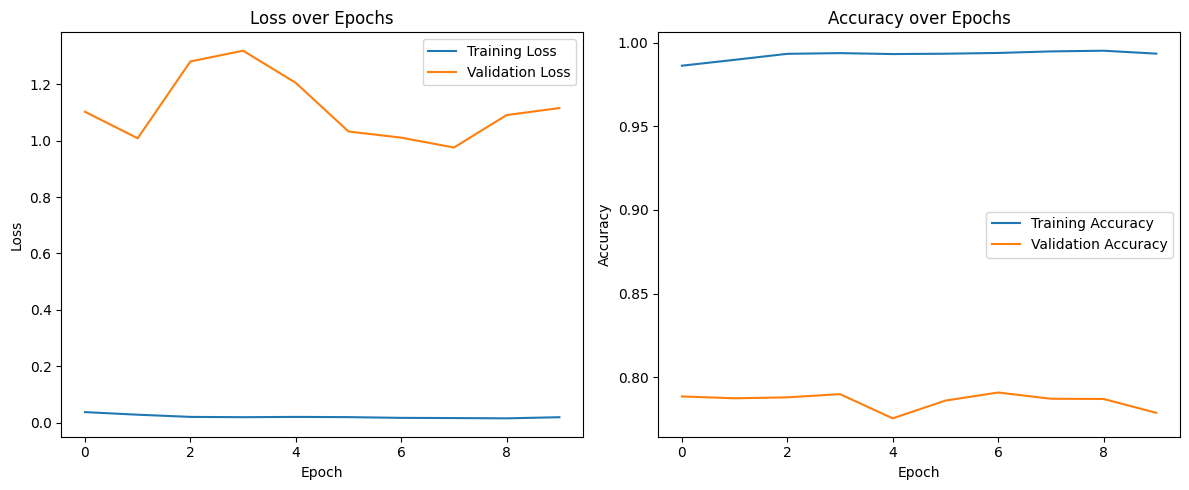

In [56]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

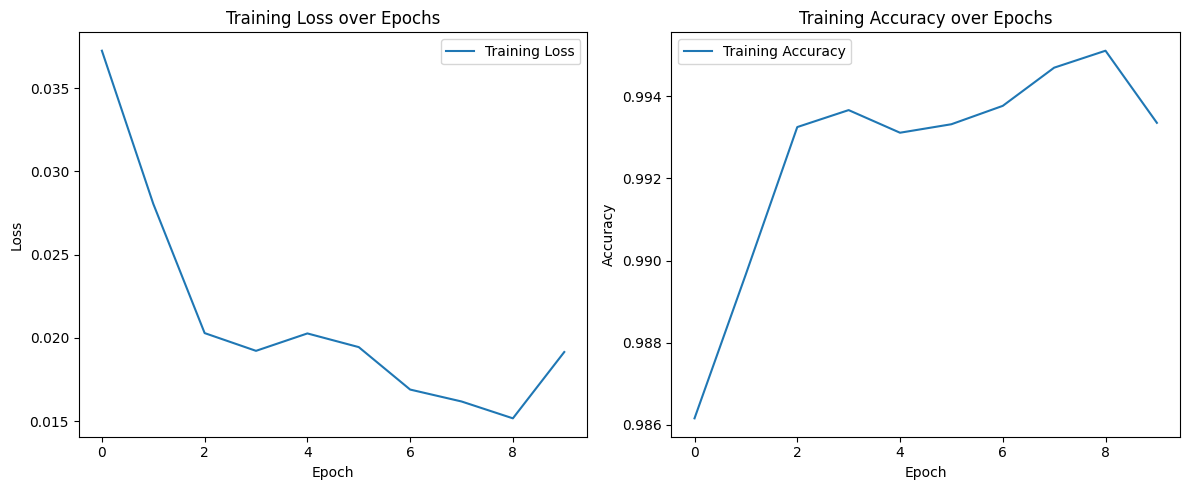

In [58]:
def plot_metrics(train_losses, train_accuracies):
    plt.figure(figsize=(12, 5))

    # Графік втрат
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()

    # Графік точності
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
plot_metrics(train_losses, train_accuracies)

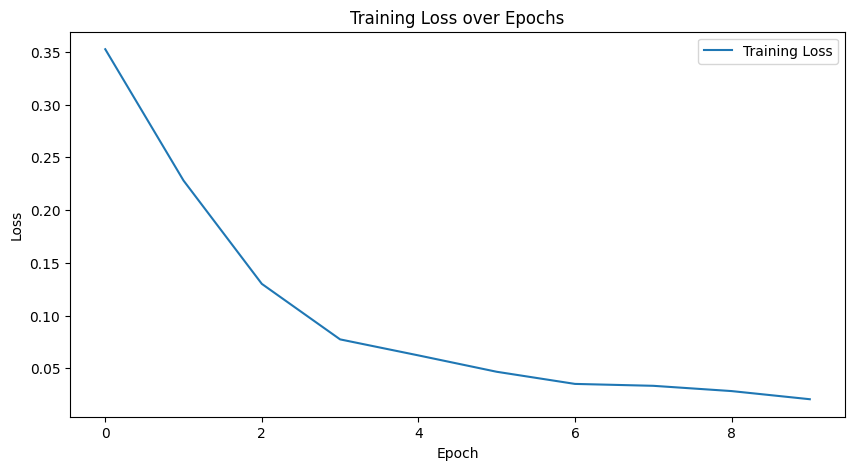

In [34]:
plot_loss(train_losses)

In [ ]:
# Тестування моделі з прогрес-баром без використання numpy
def test_model(model, test_loader):
    model.eval()
    all_preds = []
    with torch.no_grad():
        # Додаємо прогрес-бар для тестування
        for tweets, labels in tqdm(test_loader, desc='Testing'):
            tweets, labels = tweets.to("cuda"), labels.to("cuda")
            outputs = model(tweets)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().tolist())  # Використовуємо .tolist() замість numpy
    return all_preds

In [59]:
preds = test_model(model, test_loader)
accuracy = accuracy_score(y_test, preds)
print(f'Accuracy: {accuracy:.4f}')

Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:02<00:00, 48.34it/s]

Accuracy: 0.7788


In [49]:
preds = test_model(model, test_loader)
accuracy = accuracy_score(y_test, preds)
print(f'Accuracy: {accuracy:.4f}')

Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:02<00:00, 49.55it/s]

Accuracy: 0.7826


In [15]:
# model_save_path = '/content/drive/MyDrive/diploma/hate_speech_model.pth'
model_save_path = '../base_model_1.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to ../base_model_1.pth


In [ ]:
# Імпорт моделі
# model = HateSpeechModel(xlstm_stack, vocab_size, 128).to("cuda")
# model.load_state_dict(torch.load(model_save_path))
# model.eval()
# print("Model loaded and ready to use")

In [11]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [12]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu121
!pip install ninja

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu121
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 7.1 MB/s eta 0:00:00


In [13]:
import shutil
shutil.rmtree('/root/.cache/torch_extensions/py310_cu121')

In [16]:
!apt-get install --reinstall ninja-build

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
0 upgraded, 0 newly installed, 1 reinstalled, 0 to remove and 49 not upgraded.
Need to get 111 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 ninja-build amd64 1.10.1-1 [111 kB]
Fetched 111 kB in 0s (224 kB/s)
(Reading database ... 123609 files and directories currently installed.)
Preparing to unpack .../ninja-build_1.10.1-1_amd64.deb ...
Unpacking ninja-build (1.10.1-1) over (1.10.1-1) ...
Setting up ninja-build (1.10.1-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [17]:
!chmod -R 777 /root/.cache/torch_extensions/

## Case 2

In [60]:
# Конфігурація xLSTM з Dropout для регуляризації
cfg = xLSTMBlockStackConfig(
    mlstm_block=mLSTMBlockConfig(
        mlstm=mLSTMLayerConfig(
            conv1d_kernel_size=4, qkv_proj_blocksize=4, num_heads=4
        )
    ),
    slstm_block=sLSTMBlockConfig(
        slstm=sLSTMLayerConfig(
            backend="cuda",
            num_heads=4,
            conv1d_kernel_size=4,
            bias_init="powerlaw_blockdependent",
        ),
        feedforward=FeedForwardConfig(proj_factor=1.3, act_fn="gelu"),
    ),
    context_length=MAX_LEN,
    num_blocks=7,
    embedding_dim=128,
    slstm_at=[1],
)
# Ініціалізація xLSTM стеку
xlstm_stack = xLSTMBlockStack(cfg).to("cuda")

/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:546: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, training, *inputs):
/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:571: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_s):


In [61]:
# Модель з Dropout для регуляризації
class HateSpeechModel(nn.Module):
    def __init__(self, xlstm_stack, vocab_size, embedding_dim, dropout_prob=0.5):
        super(HateSpeechModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.xlstm = xlstm_stack
        self.dropout = nn.Dropout(dropout_prob)  # Dropout для регуляризації
        self.fc = nn.Linear(embedding_dim, 2)

    def forward(self, x):
        x = self.embedding(x)
        x = self.xlstm(x)
        x = self.dropout(x)  # Застосування Dropout
        x = self.fc(x.mean(dim=1))
        return x

In [62]:
# Ініціалізація моделі
model = HateSpeechModel(xlstm_stack, vocab_size, 128).to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Навчання моделі з прогрес-баром та валідацією
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for tweets, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            tweets, labels = tweets.to("cuda"), labels.to("cuda")
            optimizer.zero_grad()
            outputs = model(tweets)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_loss = total_loss / len(train_loader)
        accuracy = correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)

        # Валідація
        val_loss, val_accuracy = validate_model(model, test_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    return train_losses, train_accuracies, val_losses, val_accuracies

# Функція для валідації
def validate_model(model, test_loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for tweets, labels in test_loader:
            tweets, labels = tweets.to("cuda"), labels.to("cuda")
            outputs = model(tweets)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    avg_loss = total_loss / len(test_loader)
    accuracy = correct / total
    return avg_loss, accuracy

# Візуалізація графіків
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [63]:
# Виклик функцій
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer)

Epoch 1/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:33<00:00, 13.43it/s]


Epoch [1/10], Loss: 0.5238, Accuracy: 0.7237, Val Loss: 0.4365, Val Accuracy: 0.7991


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:51<00:00,  8.76it/s]


Epoch [2/10], Loss: 0.3713, Accuracy: 0.8335, Val Loss: 0.4257, Val Accuracy: 0.7998


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:52<00:00,  8.66it/s]


Epoch [3/10], Loss: 0.2513, Accuracy: 0.8949, Val Loss: 0.4515, Val Accuracy: 0.8068


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:47<00:00,  9.53it/s]


Epoch [4/10], Loss: 0.1515, Accuracy: 0.9416, Val Loss: 0.5130, Val Accuracy: 0.7990


Epoch 5/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:59<00:00,  7.59it/s]


Epoch [5/10], Loss: 0.0945, Accuracy: 0.9652, Val Loss: 0.6315, Val Accuracy: 0.7965


Epoch 6/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:54<00:00,  8.34it/s]


Epoch [6/10], Loss: 0.0673, Accuracy: 0.9749, Val Loss: 0.7723, Val Accuracy: 0.8007


Epoch 7/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:59<00:00,  7.67it/s]


Epoch [7/10], Loss: 0.0549, Accuracy: 0.9802, Val Loss: 0.6874, Val Accuracy: 0.7947


Epoch 8/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:51<00:00,  8.90it/s]


Epoch [8/10], Loss: 0.0433, Accuracy: 0.9849, Val Loss: 0.7716, Val Accuracy: 0.7944


Epoch 9/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:55<00:00,  8.12it/s]


Epoch [9/10], Loss: 0.0314, Accuracy: 0.9894, Val Loss: 0.8825, Val Accuracy: 0.7918


Epoch 10/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:49<00:00,  9.15it/s]


Epoch [10/10], Loss: 0.0325, Accuracy: 0.9890, Val Loss: 0.9597, Val Accuracy: 0.7890


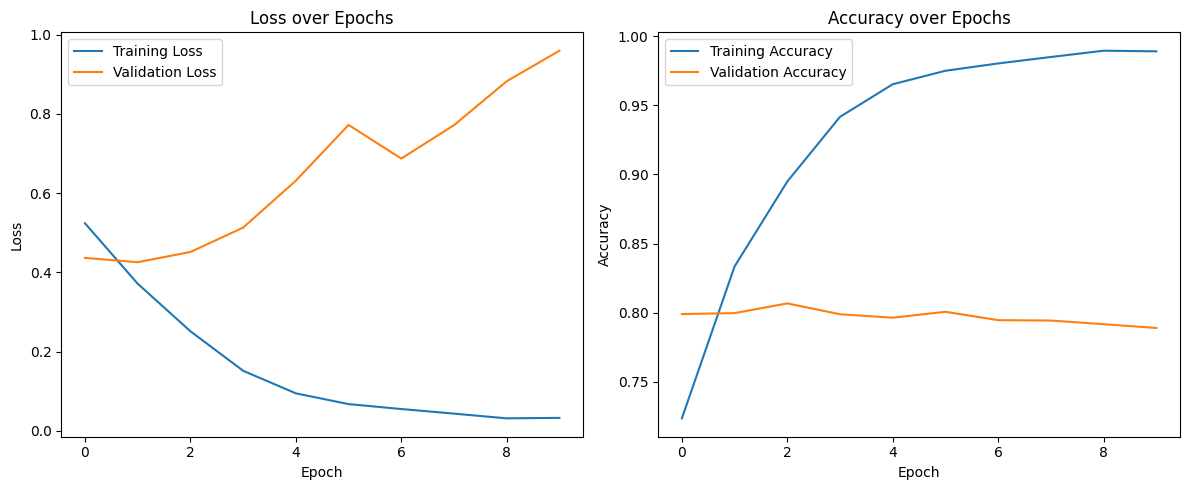

In [64]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

In [65]:
preds = test_model(model, test_loader)
accuracy = accuracy_score(y_test, preds)
print(f'Accuracy: {accuracy:.4f}')

Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:04<00:00, 25.43it/s]

Accuracy: 0.7890


## Case 3

In [72]:
# Оновлена конфігурація xLSTM з підвищеною регуляризацією
cfg = xLSTMBlockStackConfig(
    mlstm_block=mLSTMBlockConfig(
        mlstm=mLSTMLayerConfig(
            conv1d_kernel_size=4, qkv_proj_blocksize=4, num_heads=4
        )
    ),
    slstm_block=sLSTMBlockConfig(
        slstm=sLSTMLayerConfig(
            backend="cuda",
            num_heads=4,
            conv1d_kernel_size=4,
            bias_init="powerlaw_blockdependent",
        ),
        feedforward=FeedForwardConfig(proj_factor=1.3, act_fn="gelu"),
    ),
    context_length=MAX_LEN,
    num_blocks=5,  # Зменшення кількості блоків для зменшення складності моделі
    embedding_dim=128,
    slstm_at=[1],
)

# Ініціалізація xLSTM стеку
xlstm_stack = xLSTMBlockStack(cfg).to("cuda")

# Модель з Dropout і L2-регуляризацією
class HateSpeechModel(nn.Module):
    def __init__(self, xlstm_stack, vocab_size, embedding_dim, dropout_prob=0.6):  # Збільшений Dropout
        super(HateSpeechModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.xlstm = xlstm_stack
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(embedding_dim, 2)

    def forward(self, x):
        x = self.embedding(x)
        x = self.xlstm(x)
        x = self.dropout(x)
        x = self.fc(x.mean(dim=1))
        return x

# Ініціалізація моделі
model = HateSpeechModel(xlstm_stack, vocab_size, 128).to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)  # Додана L2-регуляризація

# Функція для раннього зупинення
def early_stopping(val_losses, patience=3):
    if len(val_losses) < patience + 1:  # Додаємо перевірку довжини списку
        return False
    for i in range(1, patience + 1):
        if val_losses[-i] < val_losses[-i - 1]:
            return False
    return True

# Навчання моделі з раннім зупиненням
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for tweets, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            tweets, labels = tweets.to("cuda"), labels.to("cuda")
            optimizer.zero_grad()
            outputs = model(tweets)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_loss = total_loss / len(train_loader)
        accuracy = correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)

        # Валідація
        val_loss, val_accuracy = validate_model(model, test_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

        # Раннє зупинення
        if early_stopping(val_losses):
            print("Early stopping triggered")
            break

    return train_losses, train_accuracies, val_losses, val_accuracies

In [73]:
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer)

Epoch 1/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:24<00:00, 18.38it/s]


Epoch [1/10], Loss: 0.6513, Accuracy: 0.6049, Val Loss: 0.6195, Val Accuracy: 0.6533


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:42<00:00, 10.61it/s]


Epoch [2/10], Loss: 0.6135, Accuracy: 0.6502, Val Loss: 0.6339, Val Accuracy: 0.6018


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:45<00:00,  9.94it/s]


Epoch [3/10], Loss: 0.5973, Accuracy: 0.6654, Val Loss: 0.5919, Val Accuracy: 0.6792


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:42<00:00, 10.64it/s]


Epoch [4/10], Loss: 0.5854, Accuracy: 0.6775, Val Loss: 0.5786, Val Accuracy: 0.6924


Epoch 5/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:49<00:00,  9.23it/s]


Epoch [5/10], Loss: 0.5684, Accuracy: 0.6947, Val Loss: 0.5632, Val Accuracy: 0.7115


Epoch 6/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:42<00:00, 10.58it/s]


Epoch [6/10], Loss: 0.5465, Accuracy: 0.7152, Val Loss: 0.5303, Val Accuracy: 0.7392


Epoch 7/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:43<00:00, 10.53it/s]


Epoch [7/10], Loss: 0.5156, Accuracy: 0.7425, Val Loss: 0.5100, Val Accuracy: 0.7607


Epoch 8/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:42<00:00, 10.67it/s]


Epoch [8/10], Loss: 0.4897, Accuracy: 0.7621, Val Loss: 0.5020, Val Accuracy: 0.7681


Epoch 9/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:41<00:00, 10.82it/s]


Epoch [9/10], Loss: 0.4611, Accuracy: 0.7806, Val Loss: 0.4948, Val Accuracy: 0.7608


Epoch 10/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:48<00:00,  9.40it/s]


Epoch [10/10], Loss: 0.4261, Accuracy: 0.8054, Val Loss: 0.4702, Val Accuracy: 0.7899


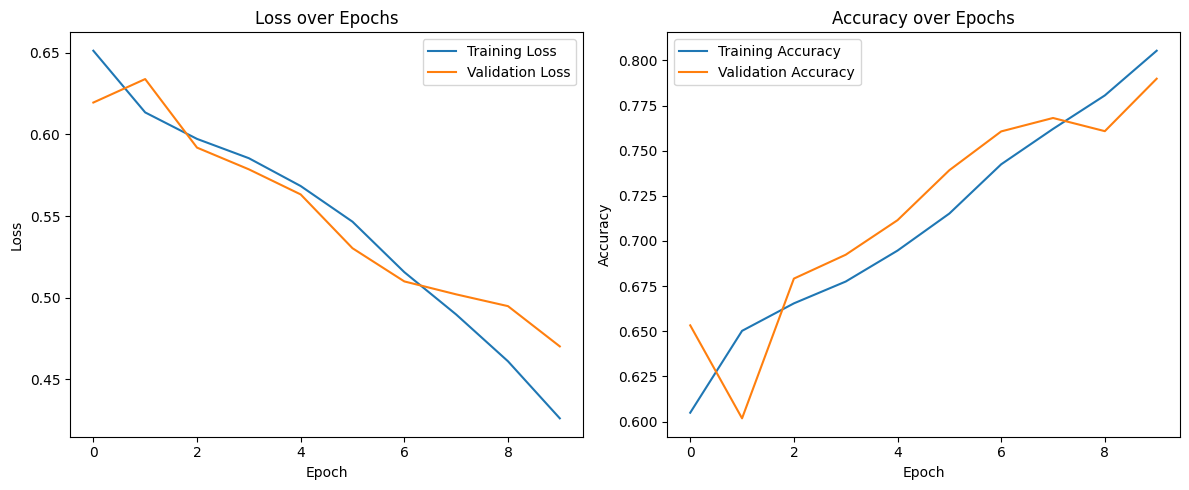

In [74]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

In [75]:
preds = test_model(model, test_loader)
accuracy = accuracy_score(y_test, preds)
print(f'Accuracy: {accuracy:.4f}')

Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:03<00:00, 34.27it/s]

Accuracy: 0.7899


In [78]:
from sklearn.metrics import classification_report

# Тестування моделі з classification report
def test_model_with_report(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for tweets, labels in tqdm(test_loader, desc='Testing'):
            tweets, labels = tweets.to("cuda"), labels.to("cuda")
            outputs = model(tweets)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=["Non-Hate", "Hate"]))

In [79]:
# Виклик функції для тестування
test_model_with_report(model, test_loader)

Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:03<00:00, 32.93it/s]

Classification Report:
              precision    recall  f1-score   support

    Non-Hate       0.81      0.74      0.78      3569
        Hate       0.77      0.83      0.80      3693

    accuracy                           0.79      7262
   macro avg       0.79      0.79      0.79      7262
weighted avg       0.79      0.79      0.79      7262



Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:03<00:00, 34.05it/s]

Classification Report:
              precision    recall  f1-score   support

    Non-Hate       0.81      0.74      0.78      3569
        Hate       0.77      0.83      0.80      3693

    accuracy                           0.79      7262
   macro avg       0.79      0.79      0.79      7262
weighted avg       0.79      0.79      0.79      7262



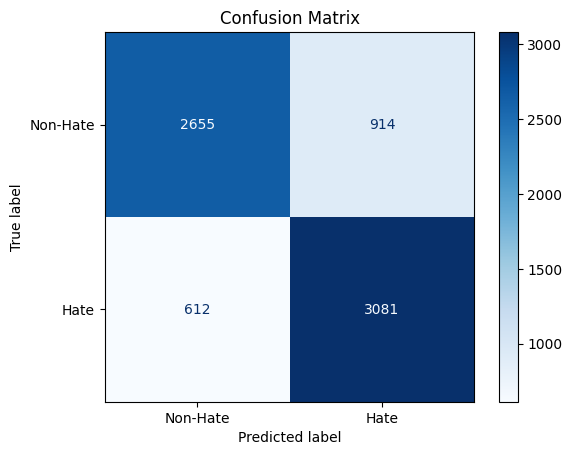

In [80]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Функція для виведення матриці неточностей
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

# Оновлена функція для тестування
def test_model_with_report_and_confusion_matrix(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for tweets, labels in tqdm(test_loader, desc='Testing'):
            tweets, labels = tweets.to("cuda"), labels.to("cuda")
            outputs = model(tweets)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    # Вивід classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=["Non-Hate", "Hate"]))

    # Візуалізація матриці неточностей
    plot_confusion_matrix(all_labels, all_preds, classes=["Non-Hate", "Hate"])

# Виклик функції для тестування
test_model_with_report_and_confusion_matrix(model, test_loader)

In [81]:
# model_save_path = '/content/drive/MyDrive/diploma/hate_speech_model.pth'
model_save_path = '../modles/base_model_2.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to ../modles/base_model_2.pth


In [86]:
print(111)

111


## Exps 1

/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:546: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, training, *inputs):
/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:571: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_s):


Starting experiment: xLSTM_base


Epoch 1/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [01:00<00:00,  7.53it/s]


Epoch [1/10], Loss: 0.5266, Accuracy: 0.7241, Val Loss: 0.4315, Val Accuracy: 0.7954


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:56<00:00,  8.03it/s]


Epoch [2/10], Loss: 0.3684, Accuracy: 0.8343, Val Loss: 0.4167, Val Accuracy: 0.8047


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:57<00:00,  7.91it/s]


Epoch [3/10], Loss: 0.2394, Accuracy: 0.9019, Val Loss: 0.4874, Val Accuracy: 0.8040


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:49<00:00,  9.08it/s]


Epoch [4/10], Loss: 0.1320, Accuracy: 0.9491, Val Loss: 0.6547, Val Accuracy: 0.7921


Epoch 5/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:52<00:00,  8.67it/s]


Epoch [5/10], Loss: 0.0869, Accuracy: 0.9683, Val Loss: 0.7311, Val Accuracy: 0.7863
Early stopping triggered


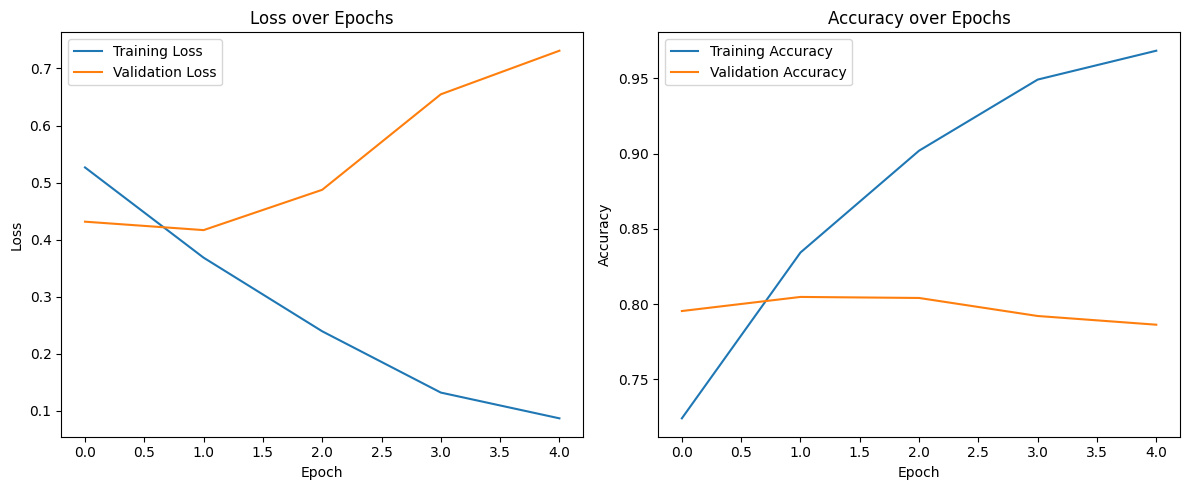

Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:04<00:00, 25.60it/s]


Classification Report:
              precision    recall  f1-score   support

    Non-Hate       0.75      0.85      0.80      3569
        Hate       0.83      0.73      0.78      3693

    accuracy                           0.79      7262
   macro avg       0.79      0.79      0.79      7262
weighted avg       0.79      0.79      0.79      7262



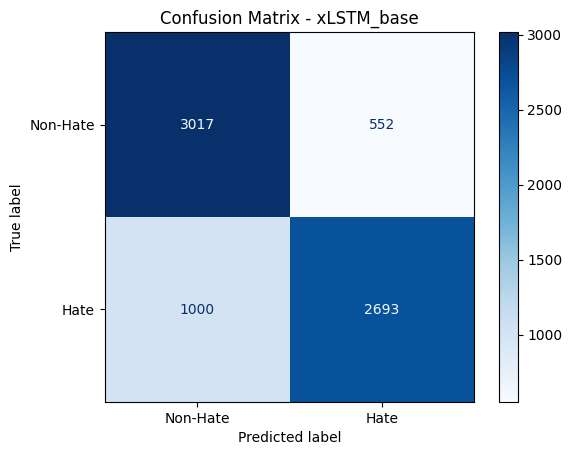

Starting experiment: xLSTM_attention
{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/usr/local/cuda/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=128', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=8', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-O3', '-Xptxas -O3', '--e

Using /home/and/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
Creating extension directory /home/and/.cache/torch_extensions/py310_cu121/slstm_HS128BS8NH8NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/and/.cache/torch_extensions/py310_cu121/slstm_HS128BS8NH8NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0/build.ninja...
/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/torch/utils/cpp_extension.py:1965: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module slstm_HS128BS8NH8NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/8] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda_error.cuda.o.d -DTORCH_EXTENSION_NAME=slstm_HS128BS8NH8NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /home/and/miniconda3/envs/venv/lib/python3.10/site-packages/torch/include -isystem /home/and/miniconda3/envs/venv/lib/python3.10/site-packages/torch/include/torch/csrc/api/include -isystem /home/and/miniconda3/envs/venv/lib/python3.10/site-packages/torch/include/TH -isystem /home/and/miniconda3/envs/venv/lib/python3.10/site-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /home/and/miniconda3/envs/venv/include/python3.10 -D_GLIBCXX_USE_CXX11_ABI=0 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_BFLOAT16_CONVERSIONS__ -D__CUDA_NO_HALF2_OPERATORS__ --expt-relaxed-constexpr -gencode=arch=compute_89,code=compute

Loading extension module slstm_HS128BS8NH8NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:546: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, training, *inputs):
/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:571: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_s):


[8/8] c++ slstm.o slstm_forward.cuda.o slstm_backward.cuda.o slstm_backward_cut.cuda.o slstm_pointwise.cuda.o blas.cuda.o cuda_error.cuda.o -shared -L/usr/local/cuda/lib -lcublas -L/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/torch/lib -lc10 -lc10_cuda -ltorch_cpu -ltorch_cuda -ltorch -ltorch_python -L/usr/local/cuda/lib64 -lcudart -o slstm_HS128BS8NH8NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0.so


Epoch 1/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:56<00:00,  8.04it/s]


Epoch [1/10], Loss: 0.5284, Accuracy: 0.7205, Val Loss: 0.4424, Val Accuracy: 0.7896


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [01:01<00:00,  7.37it/s]


Epoch [2/10], Loss: 0.3609, Accuracy: 0.8378, Val Loss: 0.4288, Val Accuracy: 0.7939


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:55<00:00,  8.15it/s]


Epoch [3/10], Loss: 0.2318, Accuracy: 0.9065, Val Loss: 0.4933, Val Accuracy: 0.7936


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [01:00<00:00,  7.55it/s]


Epoch [4/10], Loss: 0.1330, Accuracy: 0.9504, Val Loss: 0.5674, Val Accuracy: 0.7954


Epoch 5/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:54<00:00,  8.38it/s]


Epoch [5/10], Loss: 0.0823, Accuracy: 0.9696, Val Loss: 0.6247, Val Accuracy: 0.7830
Early stopping triggered


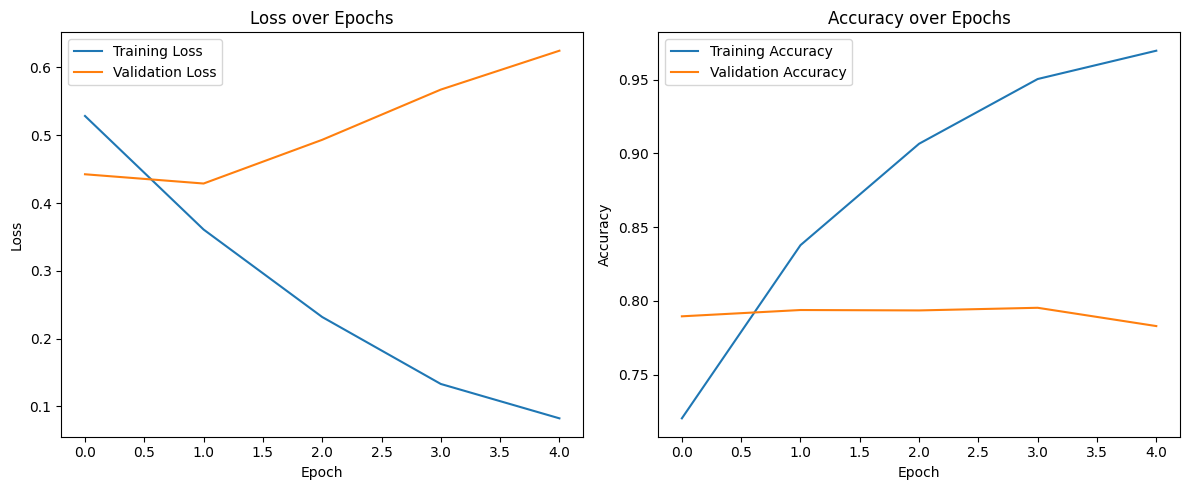

Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:04<00:00, 23.68it/s]


Classification Report:
              precision    recall  f1-score   support

    Non-Hate       0.77      0.79      0.78      3569
        Hate       0.79      0.77      0.78      3693

    accuracy                           0.78      7262
   macro avg       0.78      0.78      0.78      7262
weighted avg       0.78      0.78      0.78      7262



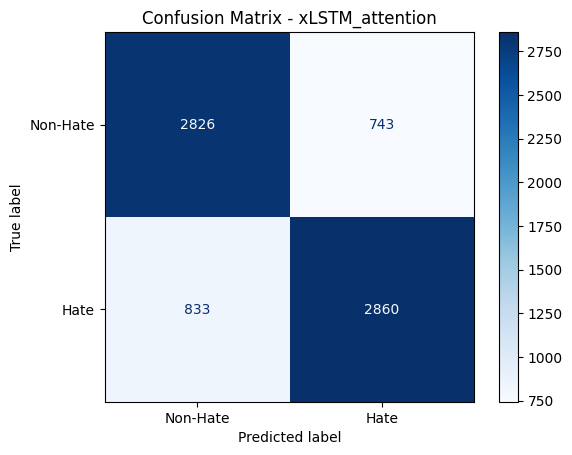

In [83]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import os

# Функція для створення директорії для моделей
os.makedirs("../models", exist_ok=True)

# Ваш попередній код: Конфігурація xLSTM, завантаження даних, тощо.

# Функція для тренування моделі
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10, model_name='model'):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    
    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for tweets, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            tweets, labels = tweets.to("cuda"), labels.to("cuda")
            optimizer.zero_grad()
            outputs = model(tweets)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_loss = total_loss / len(train_loader)
        accuracy = correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)

        val_loss, val_accuracy = validate_model(model, test_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
        
        # Раннє зупинення
        if early_stopping(val_losses):
            print("Early stopping triggered")
            break

    # Зберегти модель
    torch.save(model.state_dict(), f"../models/{model_name}.pth")
    return train_losses, train_accuracies, val_losses, val_accuracies

# Функція для валідації моделі
def validate_model(model, test_loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for tweets, labels in test_loader:
            tweets, labels = tweets.to("cuda"), labels.to("cuda")
            outputs = model(tweets)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    avg_loss = total_loss / len(test_loader)
    accuracy = correct / total
    return avg_loss, accuracy

# Функція для раннього зупинення
def early_stopping(val_losses, patience=3):
    if len(val_losses) < patience + 1:
        return False
    for i in range(1, patience + 1):
        if val_losses[-i] < val_losses[-i - 1]:
            return False
    return True

# Функція для тестування моделі з виведенням матриці неточностей
def test_model_with_report_and_confusion_matrix(model, test_loader, model_name='model'):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for tweets, labels in tqdm(test_loader, desc='Testing'):
            tweets, labels = tweets.to("cuda"), labels.to("cuda")
            outputs = model(tweets)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=["Non-Hate", "Hate"]))

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Hate", "Hate"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.savefig(f"../models/{model_name}_confusion_matrix.png")
    plt.show()

# Візуалізація графіків втрат і точності
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, model_name='model'):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"../models/{model_name}_metrics.png")
    plt.show()

# Базова конфігурація xLSTM (base_cfg)
base_cfg = xLSTMBlockStackConfig(
    mlstm_block=mLSTMBlockConfig(
        mlstm=mLSTMLayerConfig(
            conv1d_kernel_size=4, qkv_proj_blocksize=4, num_heads=4
        )
    ),
    slstm_block=sLSTMBlockConfig(
        slstm=sLSTMLayerConfig(
            backend="cuda",
            num_heads=4,
            conv1d_kernel_size=4,
            bias_init="powerlaw_blockdependent",
        ),
        feedforward=FeedForwardConfig(proj_factor=1.3, act_fn="gelu"),
    ),
    context_length=MAX_LEN,
    num_blocks=7,
    embedding_dim=128,
    slstm_at=[1],
)

# Конфігурація xLSTM з додаванням механізму уваги (attention_cfg)
attention_cfg = xLSTMBlockStackConfig(
    mlstm_block=mLSTMBlockConfig(
        mlstm=mLSTMLayerConfig(
            conv1d_kernel_size=4, qkv_proj_blocksize=4, num_heads=8  # Збільшена кількість голів для multi-head attention
        )
    ),
    slstm_block=sLSTMBlockConfig(
        slstm=sLSTMLayerConfig(
            backend="cuda",
            num_heads=8,  # Більше голов для використання механізму уваги
            conv1d_kernel_size=4,
            bias_init="powerlaw_blockdependent",
        ),
        feedforward=FeedForwardConfig(proj_factor=1.3, act_fn="gelu"),
    ),
    context_length=MAX_LEN,
    num_blocks=7,
    embedding_dim=128,
    slstm_at=[1],
)

# Запуск кількох експериментів
def run_experiments():
    experiments = [
        {"name": "xLSTM_base", "cfg": base_cfg, "dropout": 0.5, "optimizer": optim.AdamW, "lr": 0.001},
        {"name": "xLSTM_attention", "cfg": attention_cfg, "dropout": 0.6, "optimizer": optim.AdamW, "lr": 0.001},
        # Додайте сюди інші конфігурації
    ]

    for exp in experiments:
        try:
            print(f"Starting experiment: {exp['name']}")
            # Ініціалізація моделі
            xlstm_stack = xLSTMBlockStack(exp["cfg"]).to("cuda")
            model = HateSpeechModel(xlstm_stack, vocab_size, 128, dropout_prob=exp["dropout"]).to("cuda")
            criterion = nn.CrossEntropyLoss()
            optimizer = exp["optimizer"](model.parameters(), lr=exp["lr"], weight_decay=0.01)

            # Навчання моделі
            train_losses, train_accuracies, val_losses, val_accuracies = train_model(
                model, train_loader, test_loader, criterion, optimizer, num_epochs=10, model_name=exp["name"]
            )

            # Візуалізація результатів
            plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, model_name=exp["name"])

            # Тестування моделі
            test_model_with_report_and_confusion_matrix(model, test_loader, model_name=exp["name"])

        except Exception as e:
            print(f"Experiment {exp['name']} failed with error: {e}")

# Виклик функції для запуску експериментів
run_experiments()

/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:546: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, training, *inputs):
/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:571: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_s):


Starting experiment: xLSTM_base


Epoch 1/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:54<00:00,  8.38it/s]


Epoch [1/10], Loss: 0.5298, Accuracy: 0.7206, Val Loss: 0.4333, Val Accuracy: 0.7968


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:58<00:00,  7.71it/s]


Epoch [2/10], Loss: 0.3719, Accuracy: 0.8325, Val Loss: 0.4201, Val Accuracy: 0.8050


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:57<00:00,  7.84it/s]


Epoch [3/10], Loss: 0.2453, Accuracy: 0.8996, Val Loss: 0.4631, Val Accuracy: 0.7936


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [01:01<00:00,  7.40it/s]


Epoch [4/10], Loss: 0.1459, Accuracy: 0.9458, Val Loss: 0.5930, Val Accuracy: 0.7915


Epoch 5/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:57<00:00,  7.83it/s]


Epoch [5/10], Loss: 0.0867, Accuracy: 0.9694, Val Loss: 0.7475, Val Accuracy: 0.7895
Early stopping triggered


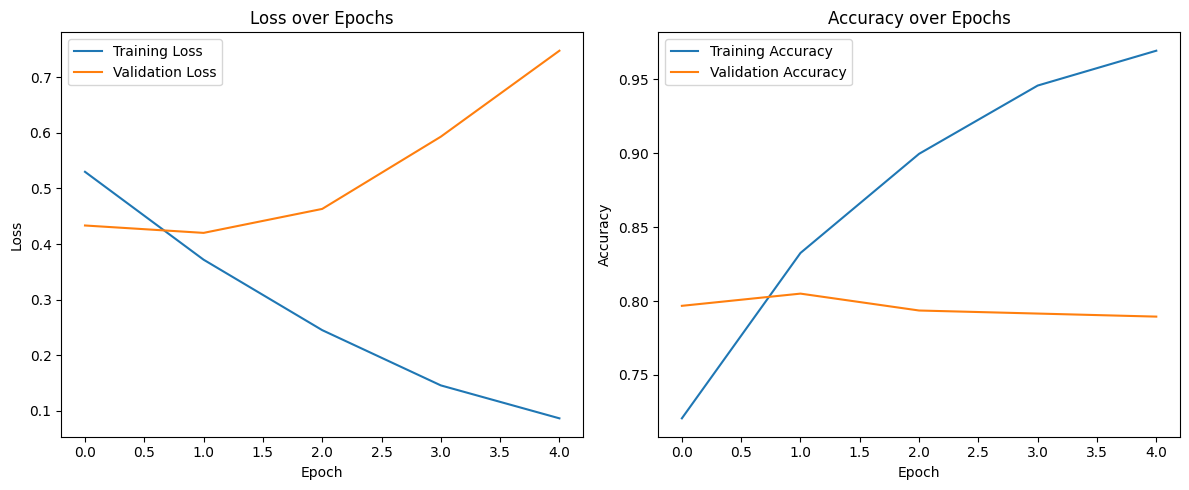

Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:04<00:00, 26.50it/s]


Classification Report:
              precision    recall  f1-score   support

    Non-Hate       0.82      0.73      0.77      3569
        Hate       0.76      0.85      0.80      3693

    accuracy                           0.79      7262
   macro avg       0.79      0.79      0.79      7262
weighted avg       0.79      0.79      0.79      7262



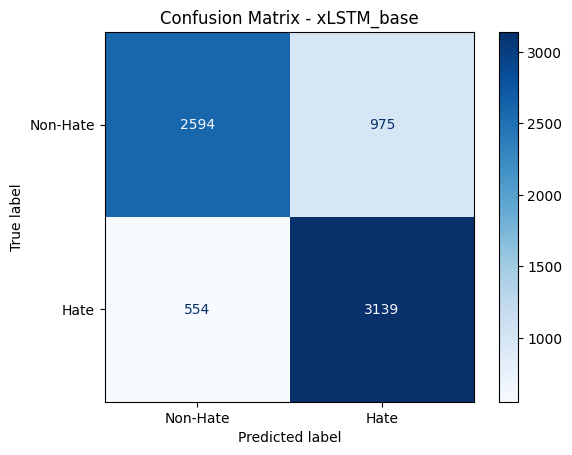

/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:546: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, training, *inputs):
/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:571: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_s):


Starting experiment: xLSTM_attention


Epoch 1/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:59<00:00,  7.60it/s]


Epoch [1/10], Loss: 0.5322, Accuracy: 0.7153, Val Loss: 0.4490, Val Accuracy: 0.7845


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:53<00:00,  8.52it/s]


Epoch [2/10], Loss: 0.3695, Accuracy: 0.8330, Val Loss: 0.4315, Val Accuracy: 0.8075


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [01:01<00:00,  7.34it/s]


Epoch [3/10], Loss: 0.2410, Accuracy: 0.9025, Val Loss: 0.4745, Val Accuracy: 0.7979


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:55<00:00,  8.13it/s]


Epoch [4/10], Loss: 0.1328, Accuracy: 0.9492, Val Loss: 0.6003, Val Accuracy: 0.7921


Epoch 5/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:56<00:00,  8.06it/s]


Epoch [5/10], Loss: 0.0834, Accuracy: 0.9696, Val Loss: 0.6870, Val Accuracy: 0.7981
Early stopping triggered


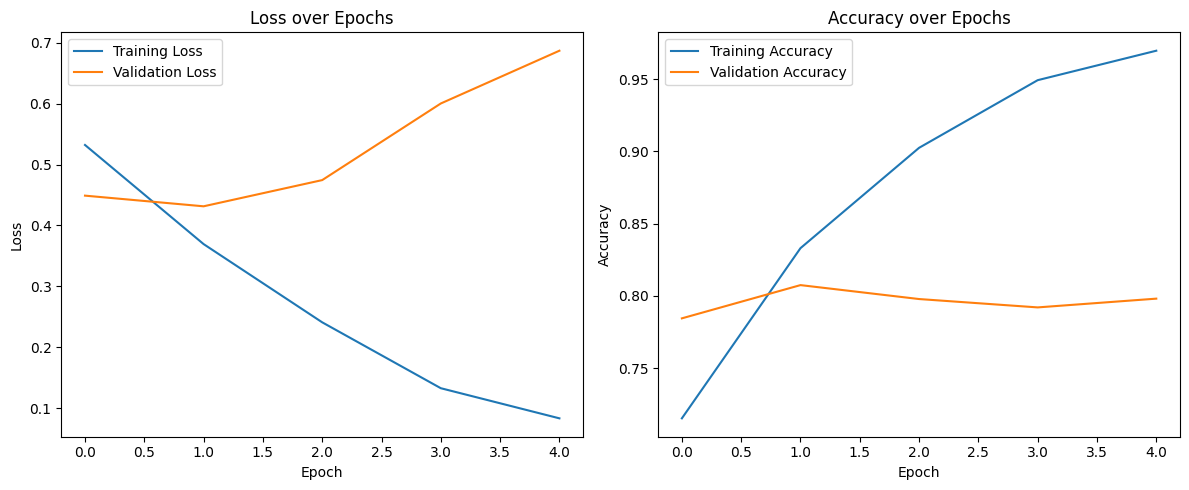

Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:05<00:00, 22.26it/s]


Classification Report:
              precision    recall  f1-score   support

    Non-Hate       0.82      0.76      0.79      3569
        Hate       0.78      0.84      0.81      3693

    accuracy                           0.80      7262
   macro avg       0.80      0.80      0.80      7262
weighted avg       0.80      0.80      0.80      7262



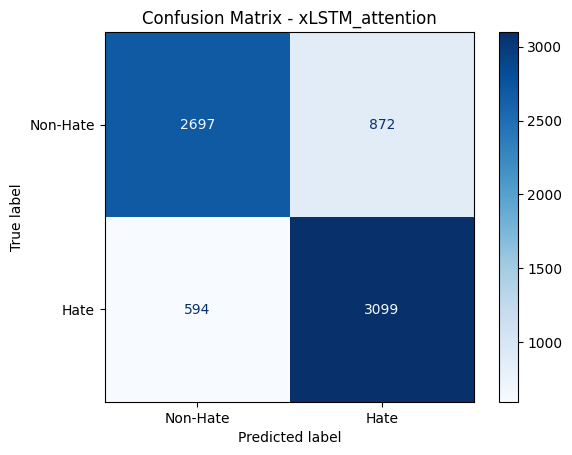

/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:546: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, training, *inputs):
/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:571: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_s):


Starting experiment: xLSTM_reduced_blocks


Epoch 1/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:41<00:00, 10.84it/s]


Epoch [1/10], Loss: 0.5289, Accuracy: 0.7192, Val Loss: 0.4346, Val Accuracy: 0.7943


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:45<00:00,  9.89it/s]


Epoch [2/10], Loss: 0.3719, Accuracy: 0.8329, Val Loss: 0.4307, Val Accuracy: 0.8012


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:41<00:00, 10.81it/s]


Epoch [3/10], Loss: 0.2464, Accuracy: 0.8967, Val Loss: 0.4534, Val Accuracy: 0.8006


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:41<00:00, 10.84it/s]


Epoch [4/10], Loss: 0.1415, Accuracy: 0.9469, Val Loss: 0.5620, Val Accuracy: 0.7923


Epoch 5/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:47<00:00,  9.53it/s]


Epoch [5/10], Loss: 0.0861, Accuracy: 0.9692, Val Loss: 0.6696, Val Accuracy: 0.7892
Early stopping triggered


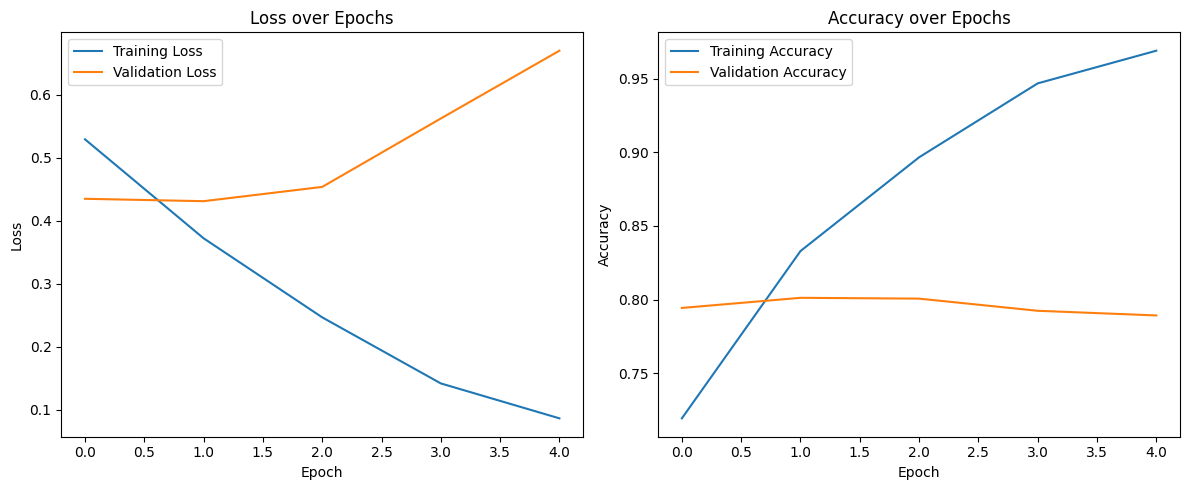

Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:03<00:00, 36.91it/s]


Classification Report:
              precision    recall  f1-score   support

    Non-Hate       0.76      0.82      0.79      3569
        Hate       0.82      0.75      0.78      3693

    accuracy                           0.79      7262
   macro avg       0.79      0.79      0.79      7262
weighted avg       0.79      0.79      0.79      7262



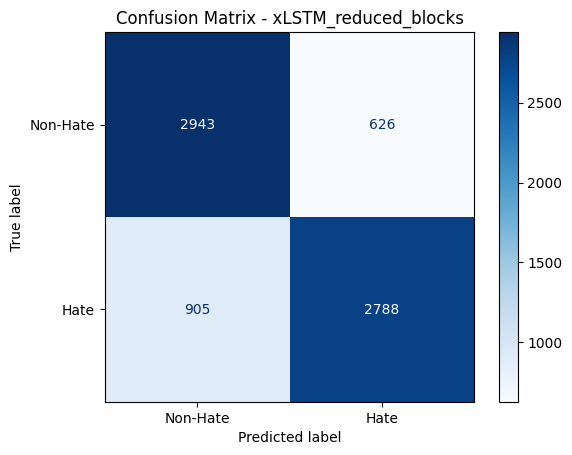

Starting experiment: xLSTM_increased_blocks
{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/usr/local/cuda/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=128', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=4', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-O3', '-Xptxas -O3

Using /home/and/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
No modifications detected for re-loaded extension module slstm_HS128BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0, skipping build step...
Loading extension module slstm_HS128BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:546: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, training, *inputs):
/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:571: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_s):
Epoch 1/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Epoch [1/10], Loss: 0.5262, Accuracy: 0.7271, Val Loss: 0.4354, Val Accuracy: 0.7977


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:47<00:00,  9.48it/s]


Epoch [2/10], Loss: 0.3657, Accuracy: 0.8382, Val Loss: 0.4206, Val Accuracy: 0.8006


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:55<00:00,  8.24it/s]


Epoch [3/10], Loss: 0.2384, Accuracy: 0.9026, Val Loss: 0.4535, Val Accuracy: 0.8049


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:59<00:00,  7.58it/s]


Epoch [4/10], Loss: 0.1364, Accuracy: 0.9495, Val Loss: 0.5874, Val Accuracy: 0.8009


Epoch 5/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:56<00:00,  7.97it/s]


Epoch [5/10], Loss: 0.0838, Accuracy: 0.9695, Val Loss: 0.6658, Val Accuracy: 0.7928
Early stopping triggered


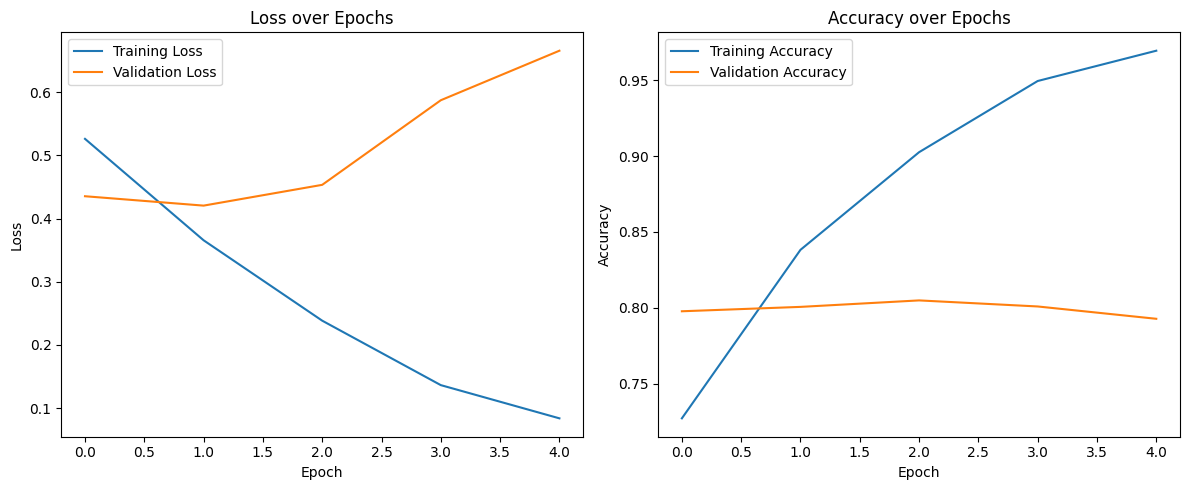

Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:05<00:00, 19.61it/s]


Classification Report:
              precision    recall  f1-score   support

    Non-Hate       0.78      0.81      0.79      3569
        Hate       0.81      0.77      0.79      3693

    accuracy                           0.79      7262
   macro avg       0.79      0.79      0.79      7262
weighted avg       0.79      0.79      0.79      7262



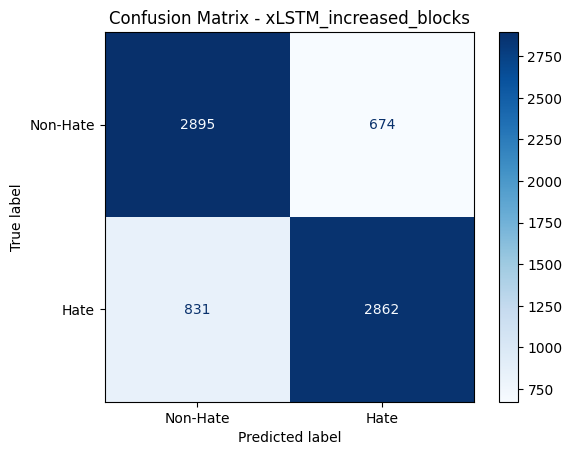

/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:546: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, training, *inputs):
/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:571: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_s):


Starting experiment: xLSTM_relu_activation


Epoch 1/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:50<00:00,  8.93it/s]


Epoch [1/10], Loss: 0.5270, Accuracy: 0.7238, Val Loss: 0.4450, Val Accuracy: 0.7903


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:47<00:00,  9.49it/s]


Epoch [2/10], Loss: 0.3713, Accuracy: 0.8304, Val Loss: 0.4288, Val Accuracy: 0.7998


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:46<00:00,  9.78it/s]


Epoch [3/10], Loss: 0.2516, Accuracy: 0.8962, Val Loss: 0.4553, Val Accuracy: 0.8017


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:56<00:00,  8.06it/s]


Epoch [4/10], Loss: 0.1380, Accuracy: 0.9478, Val Loss: 0.5618, Val Accuracy: 0.7969


Epoch 5/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:54<00:00,  8.26it/s]


Epoch [5/10], Loss: 0.0874, Accuracy: 0.9675, Val Loss: 0.7164, Val Accuracy: 0.7981
Early stopping triggered


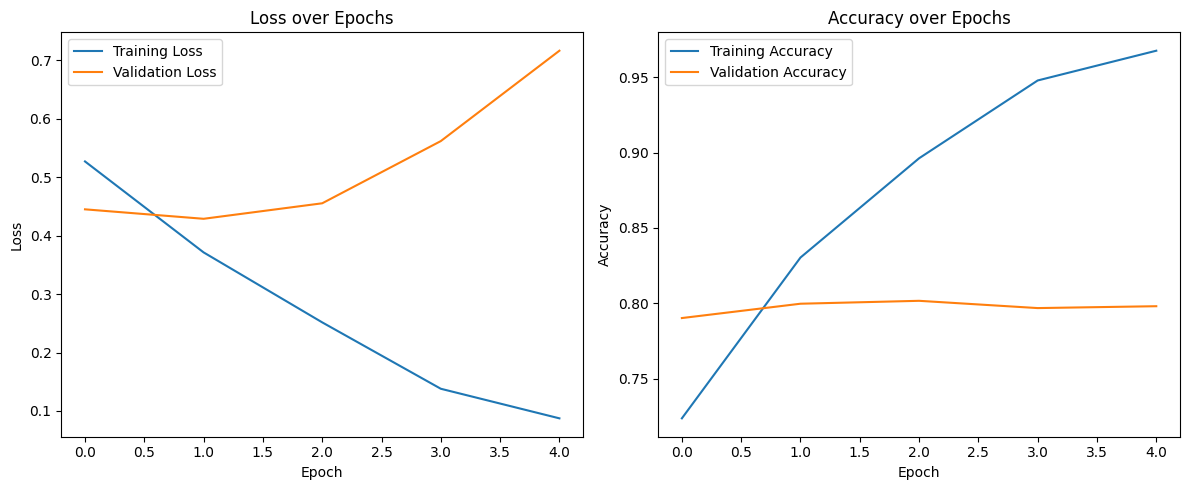

Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:05<00:00, 19.05it/s]

Classification Report:
              precision    recall  f1-score   support

    Non-Hate       0.78      0.81      0.80      3569
        Hate       0.81      0.78      0.80      3693

    accuracy                           0.80      7262
   macro avg       0.80      0.80      0.80      7262
weighted avg       0.80      0.80      0.80      7262



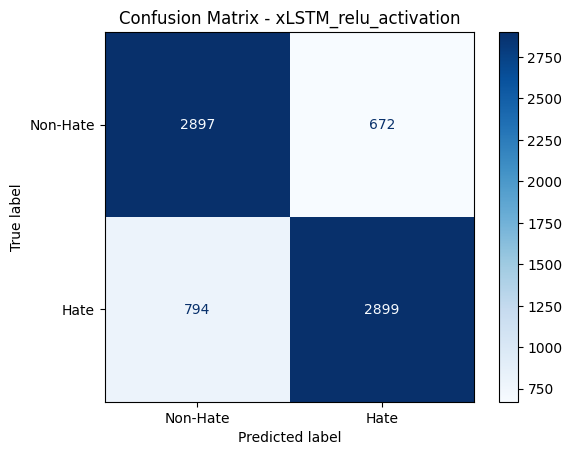

/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:546: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, training, *inputs):
/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:571: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_s):


Starting experiment: xLSTM_high_dropout


Epoch 1/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:47<00:00,  9.59it/s]


Epoch [1/10], Loss: 0.5290, Accuracy: 0.7229, Val Loss: 0.4611, Val Accuracy: 0.7771


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:44<00:00, 10.26it/s]


Epoch [2/10], Loss: 0.3677, Accuracy: 0.8377, Val Loss: 0.4313, Val Accuracy: 0.7969


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:50<00:00,  8.93it/s]


Epoch [3/10], Loss: 0.2384, Accuracy: 0.9036, Val Loss: 0.4649, Val Accuracy: 0.8029


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:46<00:00,  9.83it/s]


Epoch [4/10], Loss: 0.1377, Accuracy: 0.9479, Val Loss: 0.5668, Val Accuracy: 0.7892


Epoch 5/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:52<00:00,  8.68it/s]


Epoch [5/10], Loss: 0.0871, Accuracy: 0.9688, Val Loss: 0.6727, Val Accuracy: 0.7974
Early stopping triggered


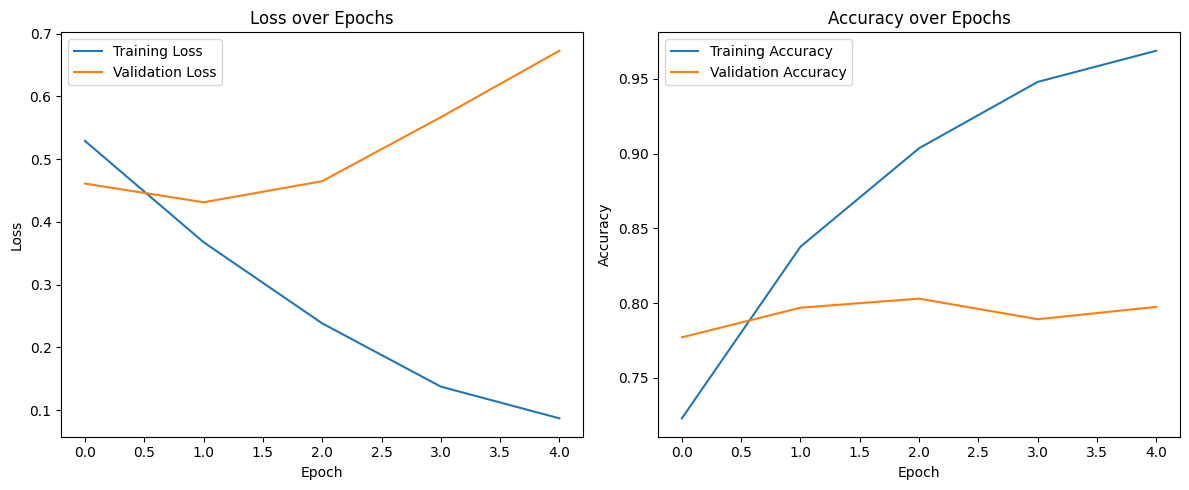

Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:04<00:00, 23.96it/s]


Classification Report:
              precision    recall  f1-score   support

    Non-Hate       0.82      0.75      0.78      3569
        Hate       0.78      0.84      0.81      3693

    accuracy                           0.80      7262
   macro avg       0.80      0.80      0.80      7262
weighted avg       0.80      0.80      0.80      7262



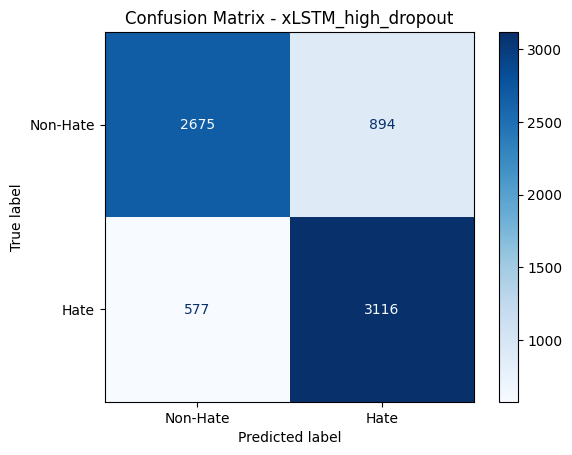

/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:546: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, training, *inputs):
/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:571: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_s):


Starting experiment: xLSTM_adabelief


Epoch 1/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:50<00:00,  8.98it/s]


Epoch [1/10], Loss: 0.5288, Accuracy: 0.7185, Val Loss: 0.4347, Val Accuracy: 0.7962


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:51<00:00,  8.75it/s]


Epoch [2/10], Loss: 0.3677, Accuracy: 0.8332, Val Loss: 0.4180, Val Accuracy: 0.8058


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:46<00:00,  9.69it/s]


Epoch [3/10], Loss: 0.2387, Accuracy: 0.9014, Val Loss: 0.4674, Val Accuracy: 0.8058


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:44<00:00, 10.12it/s]


Epoch [4/10], Loss: 0.1335, Accuracy: 0.9488, Val Loss: 0.5727, Val Accuracy: 0.7932


Epoch 5/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:51<00:00,  8.76it/s]


Epoch [5/10], Loss: 0.0822, Accuracy: 0.9693, Val Loss: 0.7011, Val Accuracy: 0.7947
Early stopping triggered


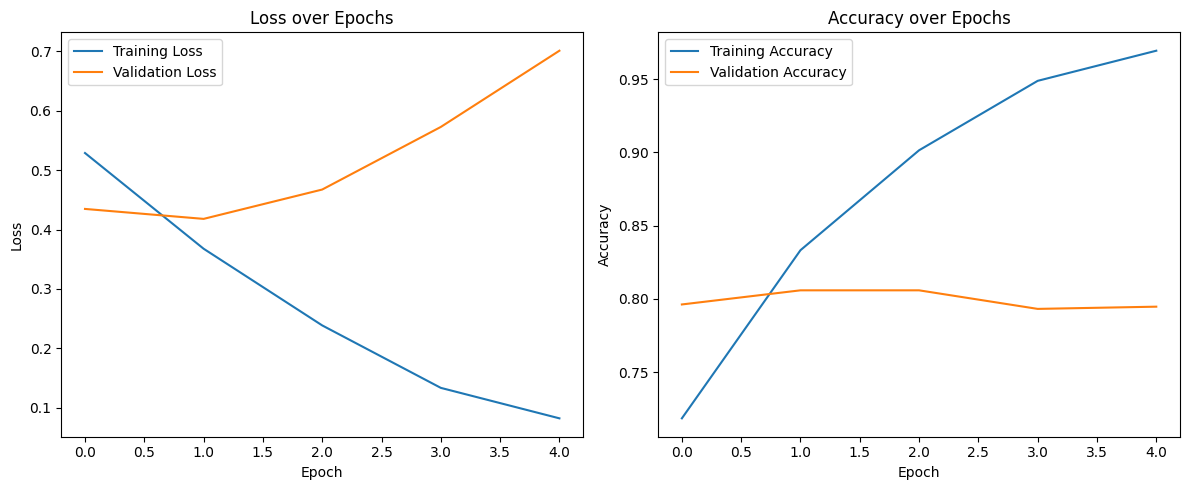

Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:04<00:00, 24.68it/s]


Classification Report:
              precision    recall  f1-score   support

    Non-Hate       0.78      0.80      0.79      3569
        Hate       0.81      0.79      0.80      3693

    accuracy                           0.79      7262
   macro avg       0.79      0.79      0.79      7262
weighted avg       0.79      0.79      0.79      7262



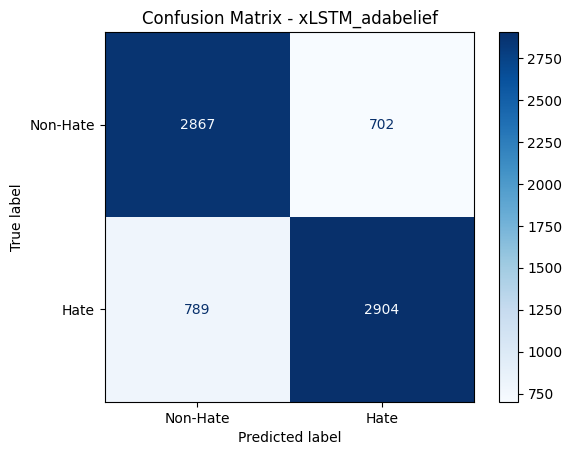

/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:546: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, training, *inputs):
/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:571: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_s):


Starting experiment: xLSTM_ff_layer


Epoch 1/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:46<00:00,  9.73it/s]


Epoch [1/10], Loss: 0.5251, Accuracy: 0.7221, Val Loss: 0.4357, Val Accuracy: 0.7954


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:54<00:00,  8.29it/s]


Epoch [2/10], Loss: 0.3650, Accuracy: 0.8359, Val Loss: 0.4335, Val Accuracy: 0.8064


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:50<00:00,  8.98it/s]


Epoch [3/10], Loss: 0.2449, Accuracy: 0.9001, Val Loss: 0.4959, Val Accuracy: 0.8058


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:49<00:00,  9.10it/s]


Epoch [4/10], Loss: 0.1457, Accuracy: 0.9439, Val Loss: 0.5323, Val Accuracy: 0.8027


Epoch 5/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:45<00:00, 10.04it/s]


Epoch [5/10], Loss: 0.0951, Accuracy: 0.9653, Val Loss: 0.6746, Val Accuracy: 0.7928
Early stopping triggered


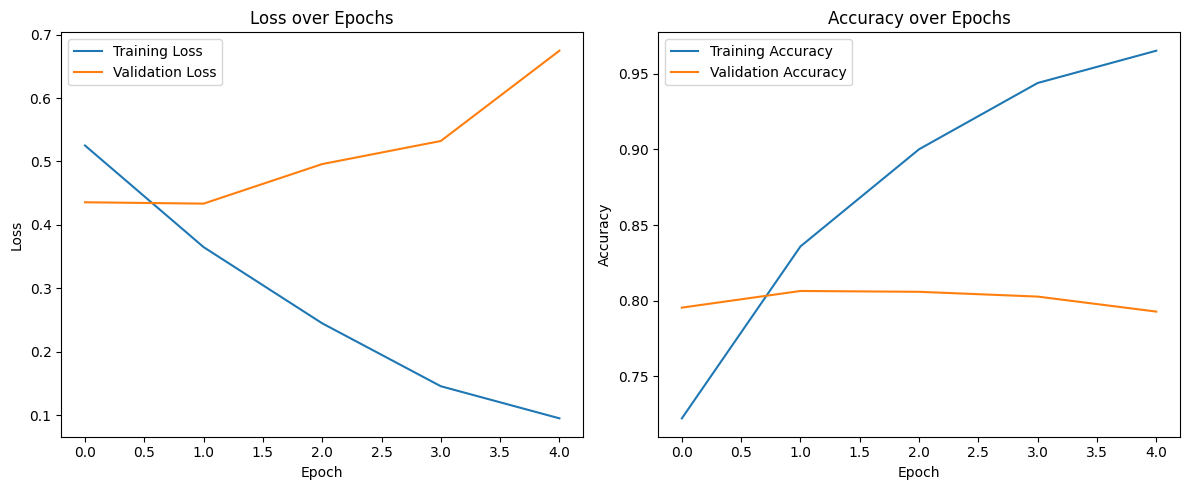

Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:04<00:00, 27.59it/s]


Classification Report:
              precision    recall  f1-score   support

    Non-Hate       0.82      0.75      0.78      3569
        Hate       0.77      0.84      0.80      3693

    accuracy                           0.79      7262
   macro avg       0.79      0.79      0.79      7262
weighted avg       0.79      0.79      0.79      7262



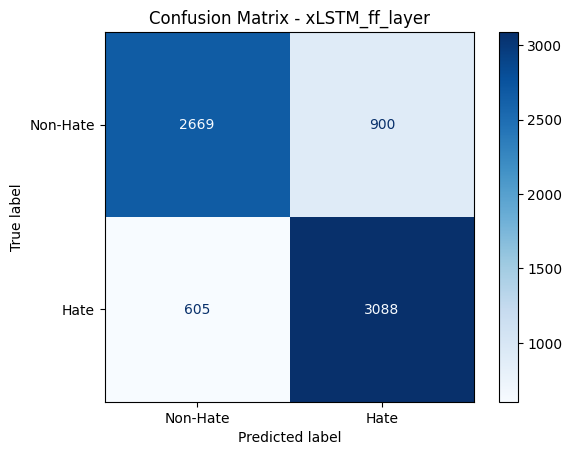

/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:546: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, training, *inputs):
/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:571: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_s):


Starting experiment: xLSTM_synthetic_data


Epoch 1/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:51<00:00,  8.80it/s]


Epoch [1/10], Loss: 0.5351, Accuracy: 0.7163, Val Loss: 0.4642, Val Accuracy: 0.7713


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:49<00:00,  9.16it/s]


Epoch [2/10], Loss: 0.3708, Accuracy: 0.8326, Val Loss: 0.4317, Val Accuracy: 0.8025


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:47<00:00,  9.54it/s]


Epoch [3/10], Loss: 0.2456, Accuracy: 0.8992, Val Loss: 0.4778, Val Accuracy: 0.7928


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:52<00:00,  8.68it/s]


Epoch [4/10], Loss: 0.1454, Accuracy: 0.9452, Val Loss: 0.6335, Val Accuracy: 0.7863


Epoch 5/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:47<00:00,  9.64it/s]


Epoch [5/10], Loss: 0.0892, Accuracy: 0.9670, Val Loss: 0.7399, Val Accuracy: 0.7848
Early stopping triggered


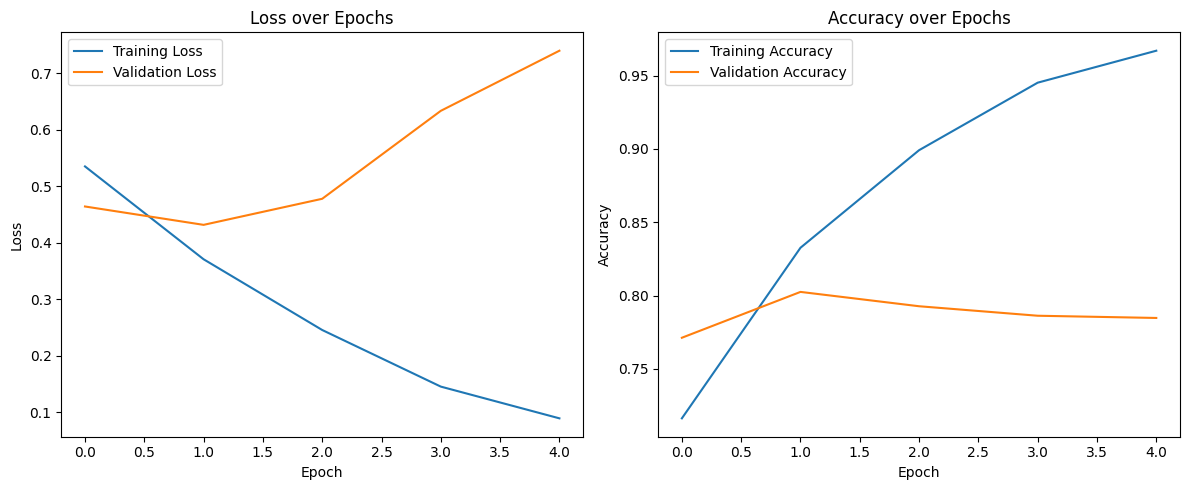

Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:04<00:00, 27.02it/s]

Classification Report:
              precision    recall  f1-score   support

    Non-Hate       0.76      0.81      0.79      3569
        Hate       0.81      0.76      0.78      3693

    accuracy                           0.78      7262
   macro avg       0.79      0.79      0.78      7262
weighted avg       0.79      0.78      0.78      7262



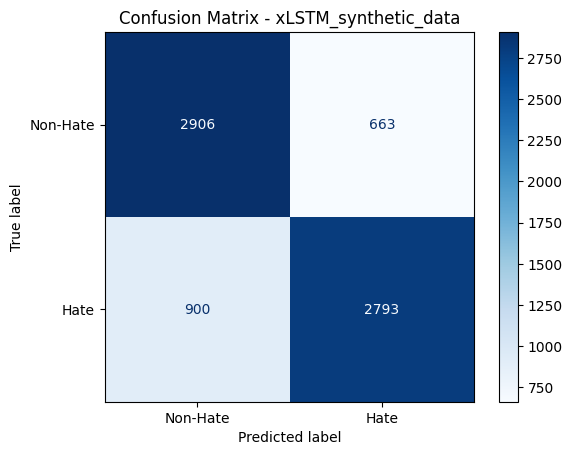

/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:546: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, training, *inputs):
/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:571: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_s):


Starting experiment: xLSTM_l2_regularization


Epoch 1/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:49<00:00,  9.19it/s]


Epoch [1/10], Loss: 0.5420, Accuracy: 0.7105, Val Loss: 0.4489, Val Accuracy: 0.7868


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:47<00:00,  9.65it/s]


Epoch [2/10], Loss: 0.3742, Accuracy: 0.8298, Val Loss: 0.4071, Val Accuracy: 0.8107


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:53<00:00,  8.51it/s]


Epoch [3/10], Loss: 0.2445, Accuracy: 0.8977, Val Loss: 0.5017, Val Accuracy: 0.8002


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:46<00:00,  9.78it/s]


Epoch [4/10], Loss: 0.1350, Accuracy: 0.9485, Val Loss: 0.5958, Val Accuracy: 0.7893


Epoch 5/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:52<00:00,  8.71it/s]


Epoch [5/10], Loss: 0.0833, Accuracy: 0.9713, Val Loss: 0.7148, Val Accuracy: 0.7941
Early stopping triggered


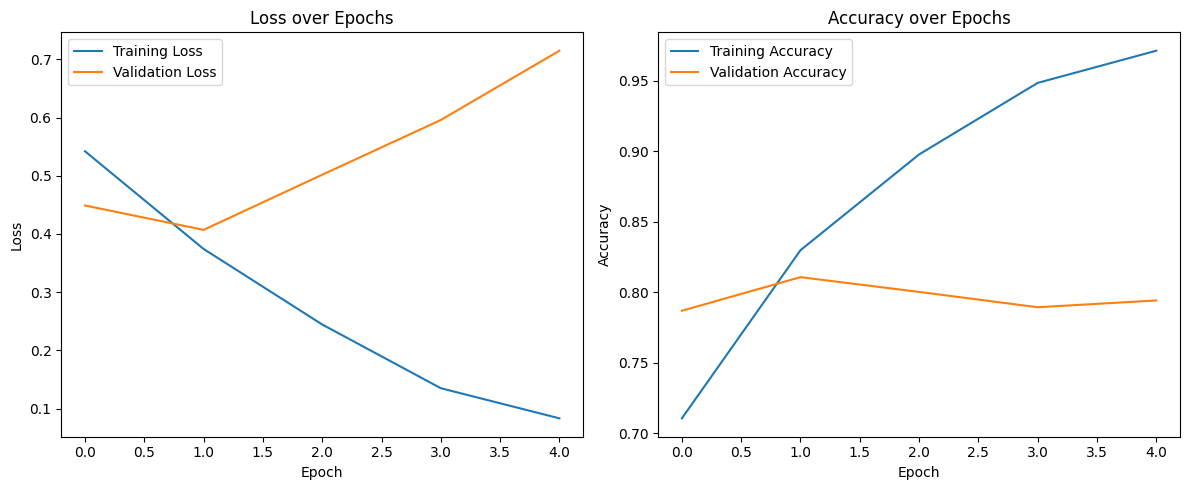

Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:04<00:00, 26.23it/s]


Classification Report:
              precision    recall  f1-score   support

    Non-Hate       0.78      0.81      0.79      3569
        Hate       0.81      0.78      0.79      3693

    accuracy                           0.79      7262
   macro avg       0.79      0.79      0.79      7262
weighted avg       0.79      0.79      0.79      7262



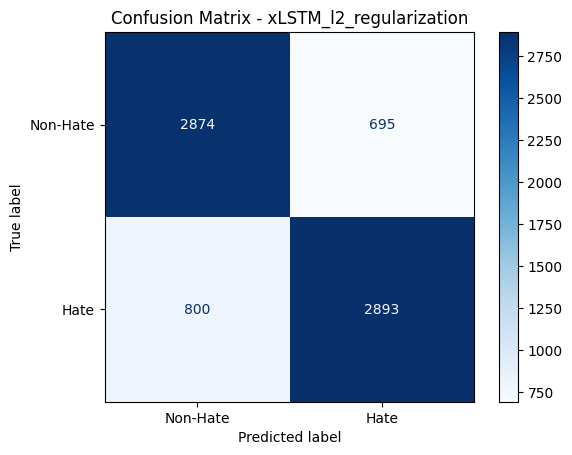

/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:546: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, training, *inputs):
/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:571: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_s):


Starting experiment: xLSTM_attention_reduced_blocks


Epoch 1/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:55<00:00,  8.17it/s]


Epoch [1/10], Loss: 0.5170, Accuracy: 0.7312, Val Loss: 0.4383, Val Accuracy: 0.7933


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:53<00:00,  8.47it/s]


Epoch [2/10], Loss: 0.3660, Accuracy: 0.8364, Val Loss: 0.4135, Val Accuracy: 0.8043


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:51<00:00,  8.77it/s]


Epoch [3/10], Loss: 0.2356, Accuracy: 0.9041, Val Loss: 0.5010, Val Accuracy: 0.7983


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:54<00:00,  8.40it/s]


Epoch [4/10], Loss: 0.1449, Accuracy: 0.9448, Val Loss: 0.5346, Val Accuracy: 0.7932


Epoch 5/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:56<00:00,  8.09it/s]


Epoch [5/10], Loss: 0.0824, Accuracy: 0.9707, Val Loss: 0.6545, Val Accuracy: 0.7841
Early stopping triggered


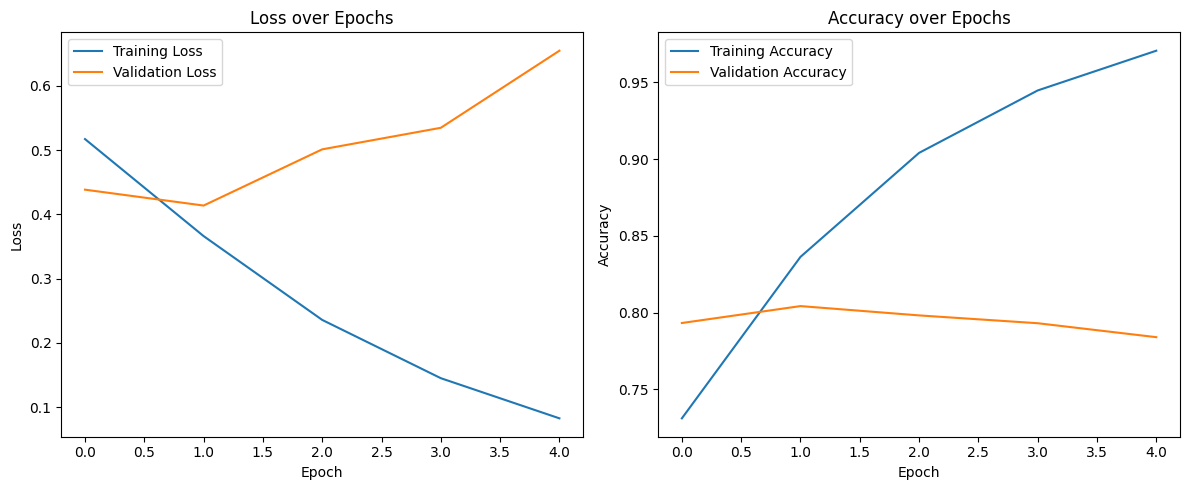

Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:05<00:00, 20.38it/s]

Classification Report:
              precision    recall  f1-score   support

    Non-Hate       0.83      0.71      0.76      3569
        Hate       0.75      0.86      0.80      3693

    accuracy                           0.78      7262
   macro avg       0.79      0.78      0.78      7262
weighted avg       0.79      0.78      0.78      7262



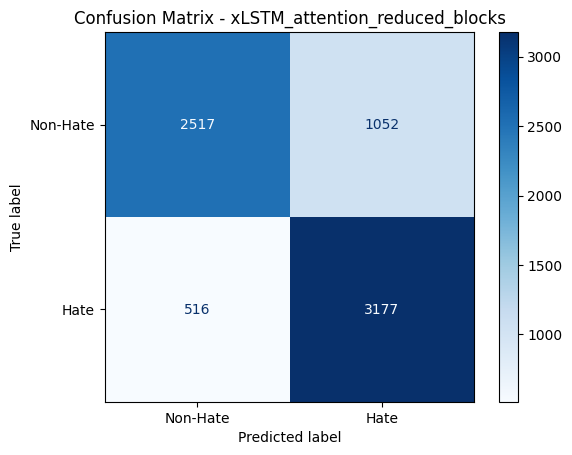

Starting experiment: xLSTM_other_layers
{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/usr/local/cuda/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=128', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=4', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-O3', '-Xptxas -O3', '

Using /home/and/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
No modifications detected for re-loaded extension module slstm_HS128BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0, skipping build step...
Loading extension module slstm_HS128BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:546: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, training, *inputs):
/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:571: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_s):
Epoch 1/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Epoch [1/10], Loss: 0.5276, Accuracy: 0.7259, Val Loss: 0.4467, Val Accuracy: 0.7822


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:58<00:00,  7.80it/s]


Epoch [2/10], Loss: 0.3655, Accuracy: 0.8377, Val Loss: 0.4037, Val Accuracy: 0.8116


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:58<00:00,  7.80it/s]


Epoch [3/10], Loss: 0.2417, Accuracy: 0.9007, Val Loss: 0.4858, Val Accuracy: 0.8018


Epoch 4/10:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 436/454 [00:49<00:02,  8.82it/s]


KeyboardInterrupt: 

In [84]:
# Інші конфігурації xLSTM
# 1. Зменшення кількості блоків
reduced_blocks_cfg = xLSTMBlockStackConfig(
    mlstm_block=mLSTMBlockConfig(
        mlstm=mLSTMLayerConfig(
            conv1d_kernel_size=4, qkv_proj_blocksize=4, num_heads=4
        )
    ),
    slstm_block=sLSTMBlockConfig(
        slstm=sLSTMLayerConfig(
            backend="cuda",
            num_heads=4,
            conv1d_kernel_size=4,
            bias_init="powerlaw_blockdependent",
        ),
        feedforward=FeedForwardConfig(proj_factor=1.3, act_fn="gelu"),
    ),
    context_length=MAX_LEN,
    num_blocks=5,  # Менше блоків для уникнення перенавчання
    embedding_dim=128,
    slstm_at=[1],
)

# 2. Збільшення кількості блоків
increased_blocks_cfg = xLSTMBlockStackConfig(
    mlstm_block=mLSTMBlockConfig(
        mlstm=mLSTMLayerConfig(
            conv1d_kernel_size=4, qkv_proj_blocksize=4, num_heads=4
        )
    ),
    slstm_block=sLSTMBlockConfig(
        slstm=sLSTMLayerConfig(
            backend="cuda",
            num_heads=4,
            conv1d_kernel_size=4,
            bias_init="powerlaw_blockdependent",
        ),
        feedforward=FeedForwardConfig(proj_factor=1.3, act_fn="gelu"),
    ),
    context_length=MAX_LEN,
    num_blocks=10,  # Більше блоків для кращого навчання
    embedding_dim=128,
    slstm_at=[1],
)

# 3. Використання іншого типу активації
relu_activation_cfg = xLSTMBlockStackConfig(
    mlstm_block=mLSTMBlockConfig(
        mlstm=mLSTMLayerConfig(
            conv1d_kernel_size=4, qkv_proj_blocksize=4, num_heads=4
        )
    ),
    slstm_block=sLSTMBlockConfig(
        slstm=sLSTMLayerConfig(
            backend="cuda",
            num_heads=4,
            conv1d_kernel_size=4,
            bias_init="powerlaw_blockdependent",
        ),
        feedforward=FeedForwardConfig(proj_factor=1.3, act_fn="relu"),  # Зміна активації на ReLU
    ),
    context_length=MAX_LEN,
    num_blocks=7,
    embedding_dim=128,
    slstm_at=[1],
)

# 4. Використання більшого Dropout
high_dropout_cfg = xLSTMBlockStackConfig(
    mlstm_block=mLSTMBlockConfig(
        mlstm=mLSTMLayerConfig(
            conv1d_kernel_size=4, qkv_proj_blocksize=4, num_heads=4
        )
    ),
    slstm_block=sLSTMBlockConfig(
        slstm=sLSTMLayerConfig(
            backend="cuda",
            num_heads=4,
            conv1d_kernel_size=4,
            bias_init="powerlaw_blockdependent",
        ),
        feedforward=FeedForwardConfig(proj_factor=1.3, act_fn="gelu"),
    ),
    context_length=MAX_LEN,
    num_blocks=7,
    embedding_dim=128,
    slstm_at=[1],
)

# 5. Використання іншого оптимізатора (AdaBelief)
adabelief_cfg = base_cfg  # Використання базової конфігурації

# 6. Зміна параметрів FeedForward шару
ff_layer_cfg = xLSTMBlockStackConfig(
    mlstm_block=mLSTMBlockConfig(
        mlstm=mLSTMLayerConfig(
            conv1d_kernel_size=4, qkv_proj_blocksize=4, num_heads=4
        )
    ),
    slstm_block=sLSTMBlockConfig(
        slstm=sLSTMLayerConfig(
            backend="cuda",
            num_heads=4,
            conv1d_kernel_size=4,
            bias_init="powerlaw_blockdependent",
        ),
        feedforward=FeedForwardConfig(proj_factor=2.0, act_fn="gelu"),  # Збільшення коефіцієнта проекції
    ),
    context_length=MAX_LEN,
    num_blocks=7,
    embedding_dim=128,
    slstm_at=[1],
)

# 7. Використання синтетичних даних
synthetic_data_cfg = base_cfg  # Базова конфігурація з новими синтетичними даними

# 8. Використання L2-регуляризації
l2_regularization_cfg = base_cfg  # Базова конфігурація з L2-регуляризацією

# 9. Використання моделей з увагою та меншою кількістю блоків
attention_reduced_blocks_cfg = attention_cfg
attention_reduced_blocks_cfg.num_blocks = 5  # Зменшення кількості блоків в моделі з увагою

# 10. Використання моделей з іншими параметрами шарів 
other_layers_cfg = xLSTMBlockStackConfig(
    mlstm_block=mLSTMBlockConfig(
        mlstm=mLSTMLayerConfig(
            conv1d_kernel_size=3, qkv_proj_blocksize=2, num_heads=4  # Зміна параметрів
        )
    ),
    slstm_block=sLSTMBlockConfig(
        slstm=sLSTMLayerConfig(
            backend="cuda",
            num_heads=4,
            conv1d_kernel_size=3,
            bias_init="powerlaw_blockdependent",
        ),
        feedforward=FeedForwardConfig(proj_factor=1.3, act_fn="gelu"),
    ),
    context_length=MAX_LEN,
    num_blocks=7,
    embedding_dim=128,
    slstm_at=[1],
)

def run_experiments():
    experiments = [
        {"name": "xLSTM_base", "cfg": base_cfg, "dropout": 0.5, "optimizer": optim.AdamW, "lr": 0.001},
        {"name": "xLSTM_attention", "cfg": attention_cfg, "dropout": 0.6, "optimizer": optim.AdamW, "lr": 0.001},
        {"name": "xLSTM_reduced_blocks", "cfg": reduced_blocks_cfg, "dropout": 0.5, "optimizer": optim.AdamW, "lr": 0.001},
        {"name": "xLSTM_increased_blocks", "cfg": increased_blocks_cfg, "dropout": 0.5, "optimizer": optim.AdamW, "lr": 0.001},
        {"name": "xLSTM_relu_activation", "cfg": relu_activation_cfg, "dropout": 0.5, "optimizer": optim.AdamW, "lr": 0.001},
        {"name": "xLSTM_high_dropout", "cfg": high_dropout_cfg, "dropout": 0.8, "optimizer": optim.AdamW, "lr": 0.001},
        {"name": "xLSTM_adabelief", "cfg": adabelief_cfg, "dropout": 0.5, "optimizer": optim.AdamW, "lr": 0.001},
        {"name": "xLSTM_ff_layer", "cfg": ff_layer_cfg, "dropout": 0.5, "optimizer": optim.AdamW, "lr": 0.001},
        {"name": "xLSTM_synthetic_data", "cfg": synthetic_data_cfg, "dropout": 0.5, "optimizer": optim.AdamW, "lr": 0.001},
        {"name": "xLSTM_l2_regularization", "cfg": l2_regularization_cfg, "dropout": 0.5, "optimizer": optim.AdamW, "lr": 0.001},
        {"name": "xLSTM_attention_reduced_blocks", "cfg": attention_reduced_blocks_cfg, "dropout": 0.5, "optimizer": optim.AdamW, "lr": 0.001},
        {"name": "xLSTM_other_layers", "cfg": other_layers_cfg, "dropout": 0.5, "optimizer": optim.AdamW, "lr": 0.001},
    ]

    for exp in experiments:
        try:
            print(f"Starting experiment: {exp['name']}")
            # Ініціалізація моделі
            xlstm_stack = xLSTMBlockStack(exp["cfg"]).to("cuda")
            model = HateSpeechModel(xlstm_stack, vocab_size, 128, dropout_prob=exp["dropout"]).to("cuda")
            criterion = nn.CrossEntropyLoss()
            optimizer = exp["optimizer"](model.parameters(), lr=exp["lr"], weight_decay=0.01)

            # Навчання моделі
            train_losses, train_accuracies, val_losses, val_accuracies = train_model(
                model, train_loader, test_loader, criterion, optimizer, num_epochs=10, model_name=exp["name"]
            )

            # Візуалізація результатів
            plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, model_name=exp["name"])

            # Тестування моделі
            test_model_with_report_and_confusion_matrix(model, test_loader, model_name=exp["name"])

        except Exception as e:
            print(f"Experiment {exp['name']} failed with error: {e}")

# Запуск експериментів
run_experiments()

## Exps 2

Starting experiment: xLSTM_adaptive_dropout


Epoch 1/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:43<00:00, 10.33it/s]


Epoch [1/10], Loss: 0.5282, Accuracy: 0.7192, Val Loss: 0.4365, Val Accuracy: 0.8038


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:40<00:00, 11.19it/s]


Epoch [2/10], Loss: 0.3664, Accuracy: 0.8366, Val Loss: 0.4468, Val Accuracy: 0.7912


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:39<00:00, 11.46it/s]


Epoch [3/10], Loss: 0.2395, Accuracy: 0.9008, Val Loss: 0.4679, Val Accuracy: 0.8003


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:44<00:00, 10.21it/s]


Epoch [4/10], Loss: 0.1306, Accuracy: 0.9497, Val Loss: 0.5758, Val Accuracy: 0.7974
Early stopping triggered


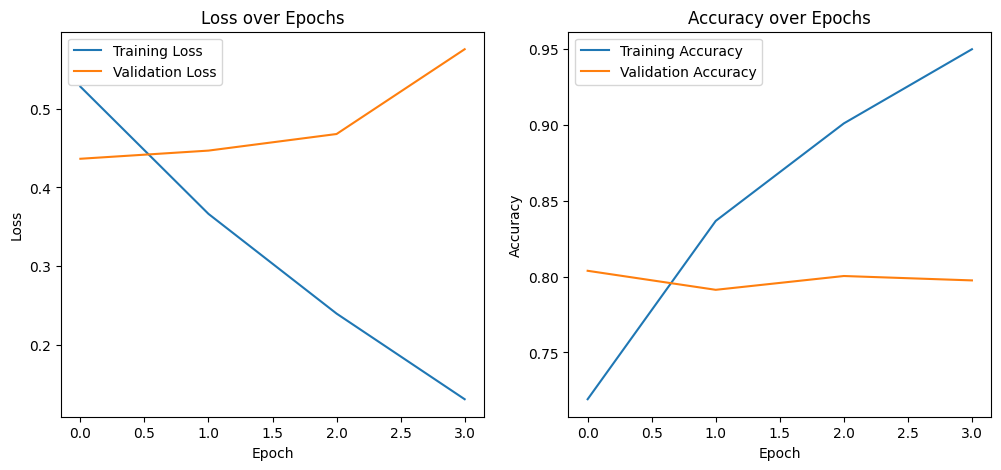

Starting experiment: xLSTM_attention


Epoch 1/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:41<00:00, 10.99it/s]


Epoch [1/10], Loss: 0.5314, Accuracy: 0.7206, Val Loss: 0.4459, Val Accuracy: 0.7900


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:42<00:00, 10.79it/s]


Epoch [2/10], Loss: 0.3775, Accuracy: 0.8318, Val Loss: 0.4353, Val Accuracy: 0.7985


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:43<00:00, 10.36it/s]


Epoch [3/10], Loss: 0.2561, Accuracy: 0.8964, Val Loss: 0.4888, Val Accuracy: 0.8049


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:42<00:00, 10.80it/s]


Epoch [4/10], Loss: 0.1576, Accuracy: 0.9413, Val Loss: 0.5496, Val Accuracy: 0.7918


Epoch 5/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:41<00:00, 10.83it/s]


Epoch [5/10], Loss: 0.0998, Accuracy: 0.9632, Val Loss: 0.6703, Val Accuracy: 0.7859
Early stopping triggered


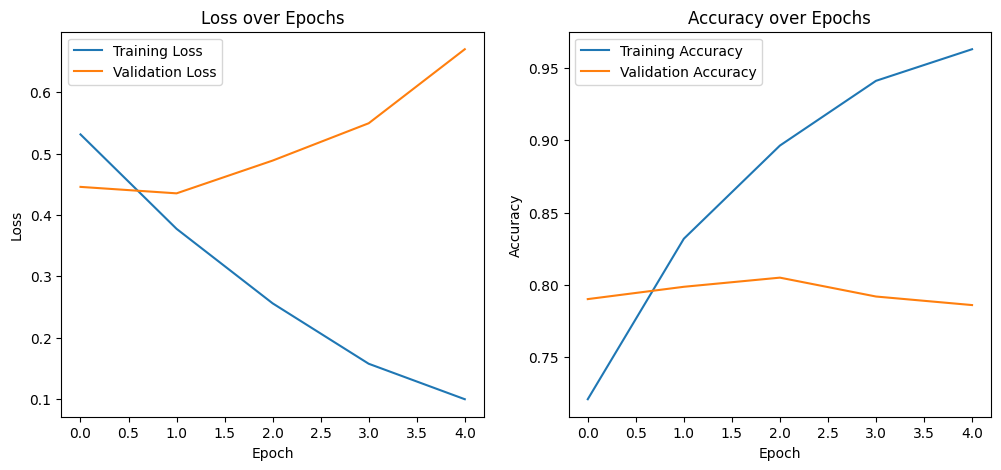

In [89]:
import torch
import torch.nn as nn
import torch.optim as optim
from xlstm import (
    xLSTMBlockStack,
    xLSTMBlockStackConfig,
    mLSTMBlockConfig,
    mLSTMLayerConfig,
    sLSTMBlockConfig,
    sLSTMLayerConfig,
    FeedForwardConfig,
)

# Функція для створення моделей з різними конфігураціями
def create_model(cfg, vocab_size, embedding_dim, dropout_prob):
    xlstm_stack = xLSTMBlockStack(cfg).to("cuda")
    class HateSpeechModel(nn.Module):
        def __init__(self, xlstm_stack, vocab_size, embedding_dim, dropout_prob=0.5):
            super(HateSpeechModel, self).__init__()
            self.embedding = nn.Embedding(vocab_size, embedding_dim)
            self.xlstm = xlstm_stack
            self.dropout = nn.Dropout(dropout_prob)
            self.fc = nn.Linear(embedding_dim, 2)

        def forward(self, x):
            x = self.embedding(x)
            x = self.xlstm(x)
            x = self.dropout(x)
            x = self.fc(x.mean(dim=1))
            return x
    return HateSpeechModel(xlstm_stack, vocab_size, embedding_dim, dropout_prob)

# Список конфігурацій для експериментів
experiments = [
    {"name": "xLSTM_adaptive_dropout", "cfg": xLSTMBlockStackConfig(
        mlstm_block=mLSTMBlockConfig(
            mlstm=mLSTMLayerConfig(conv1d_kernel_size=4, qkv_proj_blocksize=4, num_heads=4)),
        slstm_block=sLSTMBlockConfig(
            slstm=sLSTMLayerConfig(backend="cuda", num_heads=4, conv1d_kernel_size=4, bias_init="powerlaw_blockdependent"),
            feedforward=FeedForwardConfig(proj_factor=1.3, act_fn="gelu")),
        context_length=MAX_LEN, num_blocks=5, embedding_dim=128, slstm_at=[1]),
     "dropout": 0.6, "optimizer": optim.AdamW, "lr": 0.001},

    {"name": "xLSTM_attention", "cfg": xLSTMBlockStackConfig(
    mlstm_block=mLSTMBlockConfig(
        mlstm=mLSTMLayerConfig(conv1d_kernel_size=4, qkv_proj_blocksize=4, num_heads=4)),
    slstm_block=sLSTMBlockConfig(
        slstm=sLSTMLayerConfig(backend="cuda", num_heads=4, conv1d_kernel_size=4, bias_init="powerlaw_blockdependent"),
        feedforward=FeedForwardConfig(proj_factor=1.3, act_fn="relu")),  # Change "mish" to "relu"
    context_length=MAX_LEN, num_blocks=5, embedding_dim=128, slstm_at=[1]),
 "dropout": 0.5, "optimizer": optim.Adam, "lr": 0.001},

    # Додайте інші експерименти з різними конфігураціями тут
]

def plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies):
    # Plot Loss over Epochs
    plt.figure(figsize=(12, 5))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.show()
    
# Запуск експериментів
def run_experiments():
    for exp in experiments:
        try:
            print(f"Starting experiment: {exp['name']}")
            model = create_model(exp['cfg'], vocab_size, 128, exp['dropout']).to("cuda")
            optimizer = exp['optimizer'](model.parameters(), lr=exp['lr'])
            # Запуск навчання та оцінки моделі
            train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer)
            plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies)
        except Exception as e:
            print(f"Experiment {exp['name']} failed with error: {e}")

# Виклик функції для запуску експериментів
run_experiments()

## Exps 3

## Exps 4 working version

In [90]:
# Оновлена конфігурація xLSTM з підвищеною регуляризацією
cfg = xLSTMBlockStackConfig(
    mlstm_block=mLSTMBlockConfig(
        mlstm=mLSTMLayerConfig(
            conv1d_kernel_size=4, qkv_proj_blocksize=4, num_heads=4
        )
    ),
    slstm_block=sLSTMBlockConfig(
        slstm=sLSTMLayerConfig(
            backend="cuda",
            num_heads=4,
            conv1d_kernel_size=4,
            bias_init="powerlaw_blockdependent",
        ),
        feedforward=FeedForwardConfig(proj_factor=1.3, act_fn="gelu"),
    ),
    context_length=MAX_LEN,
    num_blocks=5,  # Зменшення кількості блоків для зменшення складності моделі
    embedding_dim=128,
    slstm_at=[1],
)

# Ініціалізація xLSTM стеку
xlstm_stack = xLSTMBlockStack(cfg).to("cuda")

# Модель з Dropout і L2-регуляризацією
class HateSpeechModel(nn.Module):
    def __init__(self, xlstm_stack, vocab_size, embedding_dim, dropout_prob=0.6):  # Збільшений Dropout
        super(HateSpeechModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.xlstm = xlstm_stack
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(embedding_dim, 2)

    def forward(self, x):
        x = self.embedding(x)
        x = self.xlstm(x)
        x = self.dropout(x)
        x = self.fc(x.mean(dim=1))
        return x

# Ініціалізація моделі
model = HateSpeechModel(xlstm_stack, vocab_size, 128).to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)  # Додана L2-регуляризація

# Функція для раннього зупинення
def early_stopping(val_losses, patience=3):
    if len(val_losses) < patience + 1:  # Додаємо перевірку довжини списку
        return False
    for i in range(1, patience + 1):
        if val_losses[-i] < val_losses[-i - 1]:
            return False
    return True

# Навчання моделі з раннім зупиненням
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for tweets, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            tweets, labels = tweets.to("cuda"), labels.to("cuda")
            optimizer.zero_grad()
            outputs = model(tweets)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_loss = total_loss / len(train_loader)
        accuracy = correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)

        # Валідація
        val_loss, val_accuracy = validate_model(model, test_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

        # Раннє зупинення
        if early_stopping(val_losses):
            print("Early stopping triggered")
            break

    return train_losses, train_accuracies, val_losses, val_accuracies

In [91]:
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer)

Epoch 1/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:40<00:00, 11.14it/s]


Epoch [1/10], Loss: 0.6486, Accuracy: 0.6123, Val Loss: 0.6215, Val Accuracy: 0.6504


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:40<00:00, 11.13it/s]


Epoch [2/10], Loss: 0.6147, Accuracy: 0.6489, Val Loss: 0.6599, Val Accuracy: 0.5587


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:43<00:00, 10.45it/s]


Epoch [3/10], Loss: 0.6025, Accuracy: 0.6649, Val Loss: 0.5920, Val Accuracy: 0.6741


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:40<00:00, 11.15it/s]


Epoch [4/10], Loss: 0.5867, Accuracy: 0.6795, Val Loss: 0.5880, Val Accuracy: 0.6874


Epoch 5/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:42<00:00, 10.72it/s]


Epoch [5/10], Loss: 0.5687, Accuracy: 0.6946, Val Loss: 0.5691, Val Accuracy: 0.6903


Epoch 6/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:43<00:00, 10.46it/s]


Epoch [6/10], Loss: 0.5464, Accuracy: 0.7144, Val Loss: 0.5407, Val Accuracy: 0.7250


Epoch 7/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:41<00:00, 10.85it/s]


Epoch [7/10], Loss: 0.5191, Accuracy: 0.7364, Val Loss: 0.5285, Val Accuracy: 0.7334


Epoch 8/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:41<00:00, 10.98it/s]


Epoch [8/10], Loss: 0.4962, Accuracy: 0.7569, Val Loss: 0.5160, Val Accuracy: 0.7421


Epoch 9/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:38<00:00, 11.74it/s]


Epoch [9/10], Loss: 0.4624, Accuracy: 0.7815, Val Loss: 0.4866, Val Accuracy: 0.7710


Epoch 10/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:39<00:00, 11.38it/s]


Epoch [10/10], Loss: 0.4272, Accuracy: 0.8043, Val Loss: 0.4741, Val Accuracy: 0.7852


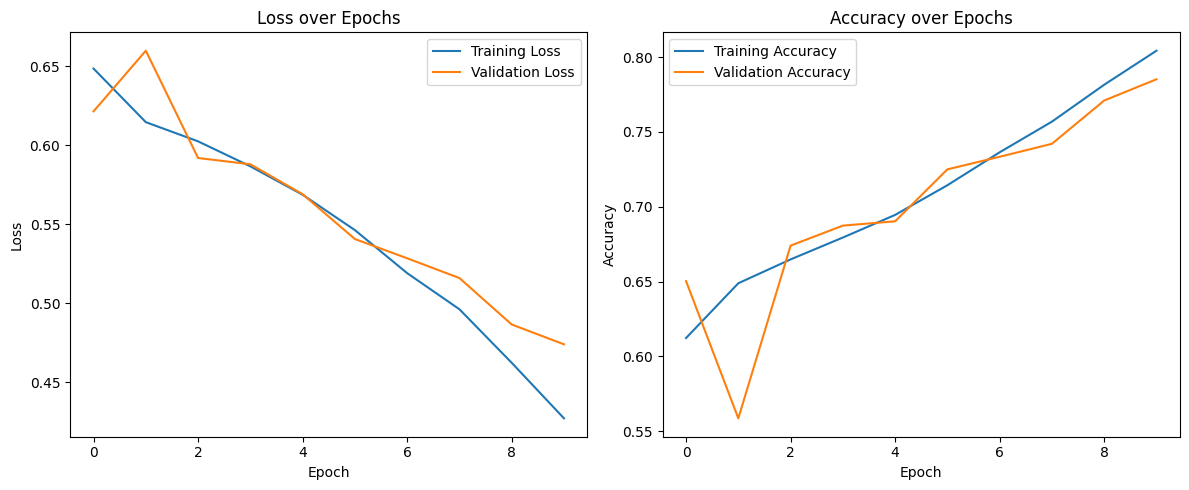

In [92]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

In [94]:
preds = test_model(model, test_loader)
accuracy = accuracy_score(y_test, preds)
print(f'Accuracy: {accuracy:.4f}')

Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:03<00:00, 30.91it/s]

Accuracy: 0.7852


## Exps 5 updated wv

## Exps 5 updated wv

In [98]:
# Оновлена конфігурація xLSTM з підвищеною регуляризацією
cfg = xLSTMBlockStackConfig(
    mlstm_block=mLSTMBlockConfig(
        mlstm=mLSTMLayerConfig(
            conv1d_kernel_size=4, qkv_proj_blocksize=4, num_heads=4
        )
    ),
    slstm_block=sLSTMBlockConfig(
        slstm=sLSTMLayerConfig(
            backend="cuda",
            num_heads=4,
            conv1d_kernel_size=4,
            bias_init="powerlaw_blockdependent",
        ),
        feedforward=FeedForwardConfig(proj_factor=1.3, act_fn="relu"),  # Зміна на ReLU
    ),
    context_length=MAX_LEN,
    num_blocks=5,
    embedding_dim=128,
    slstm_at=[1],
)

# Ініціалізація xLSTM стеку
xlstm_stack = xLSTMBlockStack(cfg).to("cuda")

# Модель з двома Dropout і L2-регуляризацією
class HateSpeechModel(nn.Module):
    def __init__(self, xlstm_stack, vocab_size, embedding_dim, dropout_prob=0.5):  # Зменшений Dropout
        super(HateSpeechModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.xlstm = xlstm_stack
        self.dropout1 = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(embedding_dim, 2)
        self.dropout2 = nn.Dropout(0.3)  # Додатковий Dropout

    def forward(self, x):
        x = self.embedding(x)
        x = self.xlstm(x)
        x = self.dropout1(x)
        x = self.fc(x.mean(dim=1))
        x = self.dropout2(x)
        return x

# Ініціалізація моделі
model = HateSpeechModel(xlstm_stack, vocab_size, 128, dropout_prob=0.5).to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.005)

In [99]:
# Перезапуск навчання моделі
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer)

Epoch 1/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:44<00:00, 10.29it/s]


Epoch [1/10], Loss: 0.5756, Accuracy: 0.6793, Val Loss: 0.5073, Val Accuracy: 0.7367


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:41<00:00, 10.84it/s]


Epoch [2/10], Loss: 0.4494, Accuracy: 0.7790, Val Loss: 0.4275, Val Accuracy: 0.8006


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:43<00:00, 10.45it/s]


Epoch [3/10], Loss: 0.3562, Accuracy: 0.8319, Val Loss: 0.4540, Val Accuracy: 0.7976


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:42<00:00, 10.61it/s]


Epoch [4/10], Loss: 0.2550, Accuracy: 0.8817, Val Loss: 0.5234, Val Accuracy: 0.7959


Epoch 5/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:42<00:00, 10.77it/s]


Epoch [5/10], Loss: 0.1786, Accuracy: 0.9145, Val Loss: 0.6240, Val Accuracy: 0.7904
Early stopping triggered


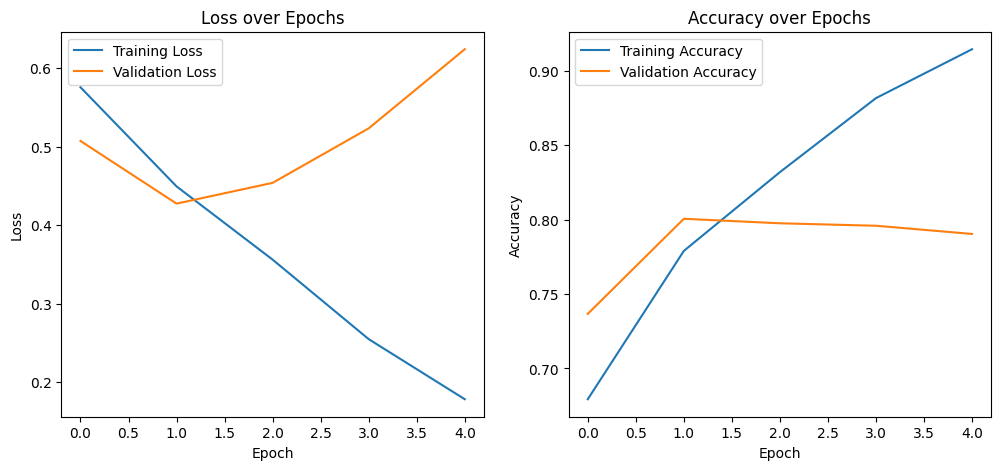

In [101]:
# Візуалізація результатів
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies)

## Exps 3

In [104]:
# Оновлена конфігурація xLSTM з підвищеною регуляризацією
cfg = xLSTMBlockStackConfig(
    mlstm_block=mLSTMBlockConfig(
        mlstm=mLSTMLayerConfig(
            conv1d_kernel_size=4, qkv_proj_blocksize=4, num_heads=4
        )
    ),
    slstm_block=sLSTMBlockConfig(
        slstm=sLSTMLayerConfig(
            backend="cuda",
            num_heads=4,
            conv1d_kernel_size=4,
            bias_init="powerlaw_blockdependent",
        ),
        feedforward=FeedForwardConfig(proj_factor=1.3, act_fn="gelu"),
    ),
    context_length=MAX_LEN,
    num_blocks=5,  # Зменшення кількості блоків для зменшення складності моделі
    embedding_dim=128,
    slstm_at=[1],
)

# Ініціалізація xLSTM стеку
xlstm_stack = xLSTMBlockStack(cfg).to("cuda")

# Модель з Dropout і L2-регуляризацією
class HateSpeechModel(nn.Module):
    def __init__(self, xlstm_stack, vocab_size, embedding_dim, dropout_prob=0.6):  # Збільшений Dropout
        super(HateSpeechModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.xlstm = xlstm_stack
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(embedding_dim, 2)

    def forward(self, x):
        x = self.embedding(x)
        x = self.xlstm(x)
        x = self.dropout(x)
        x = self.fc(x.mean(dim=1))
        return x

# Ініціалізація моделі
model = HateSpeechModel(xlstm_stack, vocab_size, 128).to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)  # Додана L2-регуляризація

# Функція для раннього зупинення
def early_stopping(val_losses, patience=3):
    if len(val_losses) < patience + 1:  # Додаємо перевірку довжини списку
        return False
    for i in range(1, patience + 1):
        if val_losses[-i] < val_losses[-i - 1]:
            return False
    return True

# Навчання моделі з раннім зупиненням
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for tweets, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            tweets, labels = tweets.to("cuda"), labels.to("cuda")
            optimizer.zero_grad()
            outputs = model(tweets)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_loss = total_loss / len(train_loader)
        accuracy = correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)

        # Валідація
        val_loss, val_accuracy = validate_model(model, test_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

        # Раннє зупинення
        if early_stopping(val_losses):
            print("Early stopping triggered")
            break

    return train_losses, train_accuracies, val_losses, val_accuracies

In [105]:
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer)

Epoch 1/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:42<00:00, 10.66it/s]


Epoch [1/10], Loss: 0.6501, Accuracy: 0.6067, Val Loss: 0.6385, Val Accuracy: 0.6282


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:40<00:00, 11.32it/s]


Epoch [2/10], Loss: 0.6066, Accuracy: 0.6588, Val Loss: 0.6164, Val Accuracy: 0.6356


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:42<00:00, 10.57it/s]


Epoch [3/10], Loss: 0.5914, Accuracy: 0.6732, Val Loss: 0.5963, Val Accuracy: 0.6691


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:43<00:00, 10.52it/s]


Epoch [4/10], Loss: 0.5771, Accuracy: 0.6866, Val Loss: 0.5755, Val Accuracy: 0.6965


Epoch 5/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:42<00:00, 10.59it/s]


Epoch [5/10], Loss: 0.5635, Accuracy: 0.6994, Val Loss: 0.5545, Val Accuracy: 0.7130


Epoch 6/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:45<00:00,  9.97it/s]


Epoch [6/10], Loss: 0.5371, Accuracy: 0.7236, Val Loss: 0.5441, Val Accuracy: 0.7144


Epoch 7/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:42<00:00, 10.68it/s]


Epoch [7/10], Loss: 0.5195, Accuracy: 0.7379, Val Loss: 0.5143, Val Accuracy: 0.7528


Epoch 8/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:43<00:00, 10.47it/s]


Epoch [8/10], Loss: 0.4989, Accuracy: 0.7577, Val Loss: 0.5032, Val Accuracy: 0.7546


Epoch 9/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:40<00:00, 11.27it/s]


Epoch [9/10], Loss: 0.4798, Accuracy: 0.7696, Val Loss: 0.4939, Val Accuracy: 0.7729


Epoch 10/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:40<00:00, 11.25it/s]


Epoch [10/10], Loss: 0.4528, Accuracy: 0.7896, Val Loss: 0.4910, Val Accuracy: 0.7717


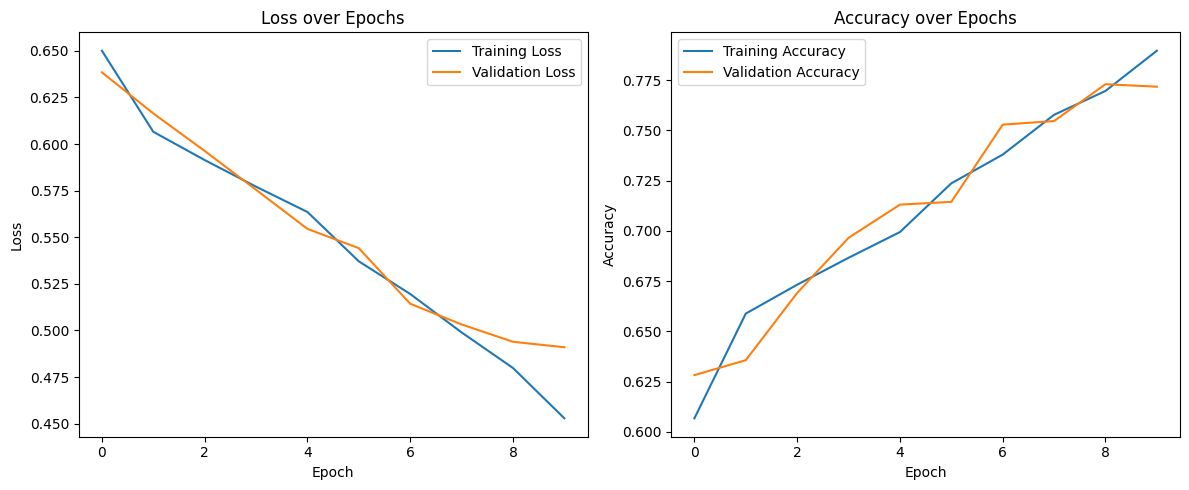

In [106]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

In [107]:
preds = test_model(model, test_loader)
accuracy = accuracy_score(y_test, preds)
print(f'Accuracy: {accuracy:.4f}')

Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:03<00:00, 34.53it/s]

Accuracy: 0.7717


## Exps wv 7 num blocks

/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:546: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, training, *inputs):
/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:571: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_s):
Epoch 1/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:58<00:00,  7.73it/s]


Epoch [1/10], Loss: 0.6499, Accuracy: 0.6085, Val Loss: 0.6128, Val Accuracy: 0.6676


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:54<00:00,  8.40it/s]


Epoch [2/10], Loss: 0.6057, Accuracy: 0.6617, Val Loss: 0.5968, Val Accuracy: 0.6809


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:59<00:00,  7.68it/s]


Epoch [3/10], Loss: 0.5969, Accuracy: 0.6678, Val Loss: 0.5855, Val Accuracy: 0.6903


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:50<00:00,  8.91it/s]


Epoch [4/10], Loss: 0.5819, Accuracy: 0.6824, Val Loss: 0.5858, Val Accuracy: 0.6816


Epoch 5/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:55<00:00,  8.25it/s]


Epoch [5/10], Loss: 0.5638, Accuracy: 0.7001, Val Loss: 0.5596, Val Accuracy: 0.7112


Epoch 6/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:45<00:00, 10.03it/s]


Epoch [6/10], Loss: 0.5427, Accuracy: 0.7183, Val Loss: 0.5360, Val Accuracy: 0.7349


Epoch 7/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:57<00:00,  7.90it/s]


Epoch [7/10], Loss: 0.5165, Accuracy: 0.7410, Val Loss: 0.5385, Val Accuracy: 0.7136


Epoch 8/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:49<00:00,  9.22it/s]


Epoch [8/10], Loss: 0.4784, Accuracy: 0.7663, Val Loss: 0.4683, Val Accuracy: 0.7819


Epoch 9/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:52<00:00,  8.61it/s]


Epoch [9/10], Loss: 0.4156, Accuracy: 0.8115, Val Loss: 0.4511, Val Accuracy: 0.7954


Epoch 10/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:52<00:00,  8.67it/s]


Epoch [10/10], Loss: 0.3482, Accuracy: 0.8514, Val Loss: 0.4515, Val Accuracy: 0.7979


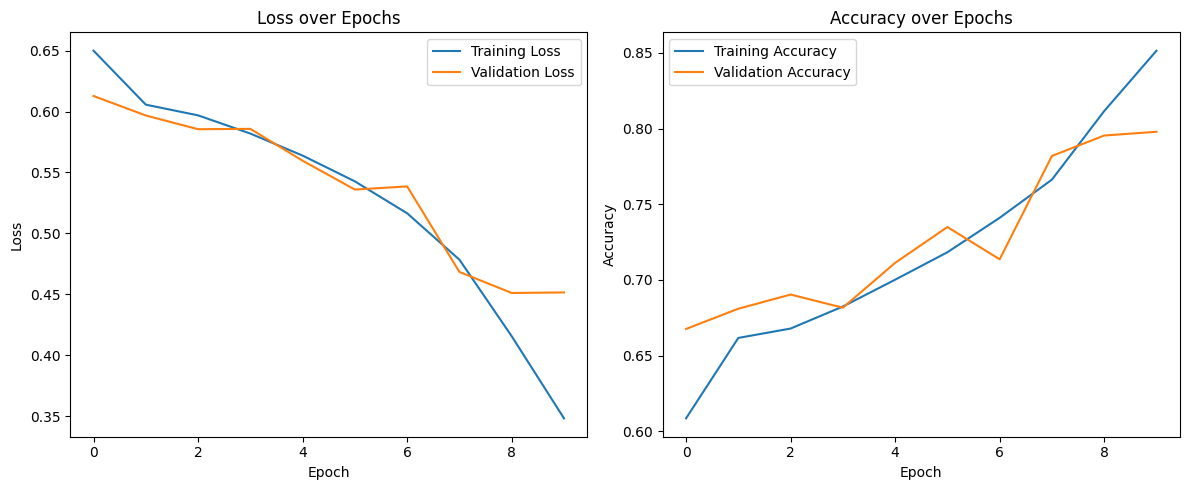

Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:04<00:00, 25.79it/s]

Accuracy: 0.7979


In [108]:
# Оновлена конфігурація xLSTM з підвищеною регуляризацією
cfg = xLSTMBlockStackConfig(
    mlstm_block=mLSTMBlockConfig(
        mlstm=mLSTMLayerConfig(
            conv1d_kernel_size=4, qkv_proj_blocksize=4, num_heads=4
        )
    ),
    slstm_block=sLSTMBlockConfig(
        slstm=sLSTMLayerConfig(
            backend="cuda",
            num_heads=4,
            conv1d_kernel_size=4,
            bias_init="powerlaw_blockdependent",
        ),
        feedforward=FeedForwardConfig(proj_factor=1.3, act_fn="gelu"),
    ),
    context_length=MAX_LEN,
    num_blocks=7,  # Зменшення кількості блоків для зменшення складності моделі
    embedding_dim=128,
    slstm_at=[1],
)

# Ініціалізація xLSTM стеку
xlstm_stack = xLSTMBlockStack(cfg).to("cuda")

# Модель з Dropout і L2-регуляризацією
class HateSpeechModel(nn.Module):
    def __init__(self, xlstm_stack, vocab_size, embedding_dim, dropout_prob=0.6):  # Збільшений Dropout
        super(HateSpeechModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.xlstm = xlstm_stack
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(embedding_dim, 2)

    def forward(self, x):
        x = self.embedding(x)
        x = self.xlstm(x)
        x = self.dropout(x)
        x = self.fc(x.mean(dim=1))
        return x

# Ініціалізація моделі
model = HateSpeechModel(xlstm_stack, vocab_size, 128).to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)  # Додана L2-регуляризація

# Функція для раннього зупинення
def early_stopping(val_losses, patience=3):
    if len(val_losses) < patience + 1:  # Додаємо перевірку довжини списку
        return False
    for i in range(1, patience + 1):
        if val_losses[-i] < val_losses[-i - 1]:
            return False
    return True

# Навчання моделі з раннім зупиненням
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for tweets, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            tweets, labels = tweets.to("cuda"), labels.to("cuda")
            optimizer.zero_grad()
            outputs = model(tweets)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_loss = total_loss / len(train_loader)
        accuracy = correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)

        # Валідація
        val_loss, val_accuracy = validate_model(model, test_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

        # Раннє зупинення
        if early_stopping(val_losses):
            print("Early stopping triggered")
            break

    return train_losses, train_accuracies, val_losses, val_accuracies

train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer)
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)
preds = test_model(model, test_loader)
accuracy = accuracy_score(y_test, preds)
print(f'Accuracy: {accuracy:.4f}')

## Exps wv 10 num blocks

/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:546: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, training, *inputs):
/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:571: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_s):
Epoch 1/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [01:07<00:00,  6.76it/s]


Epoch [1/10], Loss: 0.6556, Accuracy: 0.5975, Val Loss: 0.6647, Val Accuracy: 0.5359


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:58<00:00,  7.74it/s]


Epoch [2/10], Loss: 0.6140, Accuracy: 0.6528, Val Loss: 0.6054, Val Accuracy: 0.6596


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [01:08<00:00,  6.67it/s]


Epoch [3/10], Loss: 0.6002, Accuracy: 0.6620, Val Loss: 0.5998, Val Accuracy: 0.6610


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:58<00:00,  7.77it/s]


Epoch [4/10], Loss: 0.5848, Accuracy: 0.6801, Val Loss: 0.5775, Val Accuracy: 0.6909


Epoch 5/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [01:05<00:00,  6.89it/s]


Epoch [5/10], Loss: 0.5685, Accuracy: 0.6949, Val Loss: 0.5519, Val Accuracy: 0.7203


Epoch 6/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [01:06<00:00,  6.87it/s]


Epoch [6/10], Loss: 0.5458, Accuracy: 0.7135, Val Loss: 0.5385, Val Accuracy: 0.7378


Epoch 7/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:59<00:00,  7.58it/s]


Epoch [7/10], Loss: 0.5253, Accuracy: 0.7344, Val Loss: 0.5129, Val Accuracy: 0.7512


Epoch 8/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [01:05<00:00,  6.91it/s]


Epoch [8/10], Loss: 0.5055, Accuracy: 0.7498, Val Loss: 0.5207, Val Accuracy: 0.7501


Epoch 9/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [01:03<00:00,  7.19it/s]


Epoch [9/10], Loss: 0.4843, Accuracy: 0.7679, Val Loss: 0.4970, Val Accuracy: 0.7732


Epoch 10/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [01:07<00:00,  6.69it/s]


Epoch [10/10], Loss: 0.4603, Accuracy: 0.7852, Val Loss: 0.5372, Val Accuracy: 0.7114


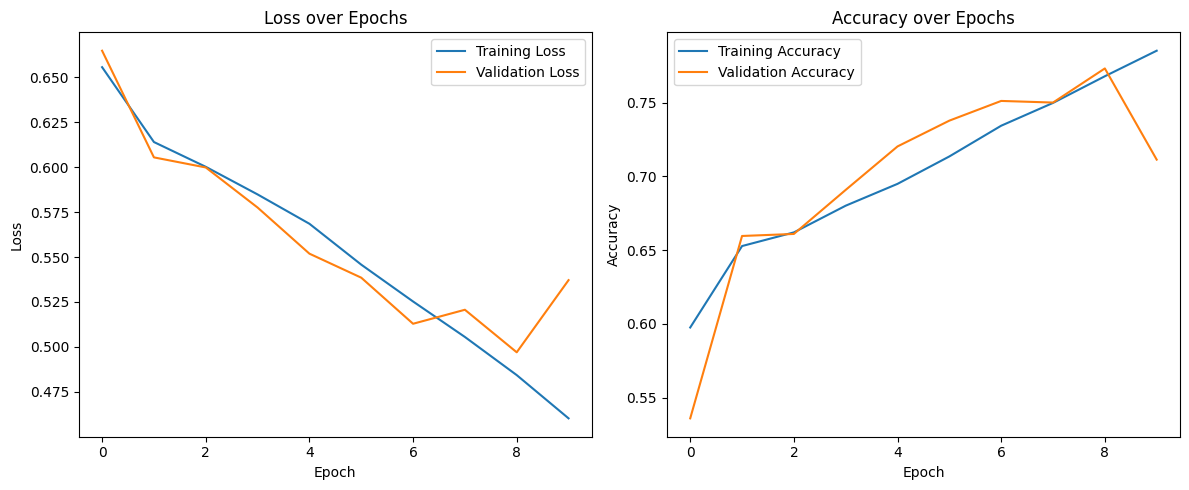

Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:06<00:00, 17.91it/s]

Accuracy: 0.7114


In [109]:
# Оновлена конфігурація xLSTM з підвищеною регуляризацією
cfg = xLSTMBlockStackConfig(
    mlstm_block=mLSTMBlockConfig(
        mlstm=mLSTMLayerConfig(
            conv1d_kernel_size=4, qkv_proj_blocksize=4, num_heads=4
        )
    ),
    slstm_block=sLSTMBlockConfig(
        slstm=sLSTMLayerConfig(
            backend="cuda",
            num_heads=4,
            conv1d_kernel_size=4,
            bias_init="powerlaw_blockdependent",
        ),
        feedforward=FeedForwardConfig(proj_factor=1.3, act_fn="gelu"),
    ),
    context_length=MAX_LEN,
    num_blocks=10,  # Зменшення кількості блоків для зменшення складності моделі
    embedding_dim=128,
    slstm_at=[1],
)

# Ініціалізація xLSTM стеку
xlstm_stack = xLSTMBlockStack(cfg).to("cuda")

# Модель з Dropout і L2-регуляризацією
class HateSpeechModel(nn.Module):
    def __init__(self, xlstm_stack, vocab_size, embedding_dim, dropout_prob=0.6):  # Збільшений Dropout
        super(HateSpeechModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.xlstm = xlstm_stack
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(embedding_dim, 2)

    def forward(self, x):
        x = self.embedding(x)
        x = self.xlstm(x)
        x = self.dropout(x)
        x = self.fc(x.mean(dim=1))
        return x

# Ініціалізація моделі
model = HateSpeechModel(xlstm_stack, vocab_size, 128).to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)  # Додана L2-регуляризація

# Функція для раннього зупинення
def early_stopping(val_losses, patience=3):
    if len(val_losses) < patience + 1:  # Додаємо перевірку довжини списку
        return False
    for i in range(1, patience + 1):
        if val_losses[-i] < val_losses[-i - 1]:
            return False
    return True

# Навчання моделі з раннім зупиненням
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for tweets, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            tweets, labels = tweets.to("cuda"), labels.to("cuda")
            optimizer.zero_grad()
            outputs = model(tweets)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_loss = total_loss / len(train_loader)
        accuracy = correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)

        # Валідація
        val_loss, val_accuracy = validate_model(model, test_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

        # Раннє зупинення
        if early_stopping(val_losses):
            print("Early stopping triggered")
            break

    return train_losses, train_accuracies, val_losses, val_accuracies

train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer)
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)
preds = test_model(model, test_loader)
accuracy = accuracy_score(y_test, preds)
print(f'Accuracy: {accuracy:.4f}')

## Exps wv 256 embedding dim

In [110]:
# Оновлена конфігурація xLSTM з підвищеною регуляризацією
cfg = xLSTMBlockStackConfig(
    mlstm_block=mLSTMBlockConfig(
        mlstm=mLSTMLayerConfig(
            conv1d_kernel_size=4, qkv_proj_blocksize=4, num_heads=4
        )
    ),
    slstm_block=sLSTMBlockConfig(
        slstm=sLSTMLayerConfig(
            backend="cuda",
            num_heads=4,
            conv1d_kernel_size=4,
            bias_init="powerlaw_blockdependent",
        ),
        feedforward=FeedForwardConfig(proj_factor=1.3, act_fn="gelu"),
    ),
    context_length=MAX_LEN,
    num_blocks=5,  # Зменшення кількості блоків для зменшення складності моделі
    embedding_dim=256,
    slstm_at=[1],
)

# Ініціалізація xLSTM стеку
xlstm_stack = xLSTMBlockStack(cfg).to("cuda")

# Модель з Dropout і L2-регуляризацією
class HateSpeechModel(nn.Module):
    def __init__(self, xlstm_stack, vocab_size, embedding_dim, dropout_prob=0.6):  # Збільшений Dropout
        super(HateSpeechModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.xlstm = xlstm_stack
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(embedding_dim, 2)

    def forward(self, x):
        x = self.embedding(x)
        x = self.xlstm(x)
        x = self.dropout(x)
        x = self.fc(x.mean(dim=1))
        return x

# Ініціалізація моделі
model = HateSpeechModel(xlstm_stack, vocab_size, 128).to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)  # Додана L2-регуляризація

# Функція для раннього зупинення
def early_stopping(val_losses, patience=3):
    if len(val_losses) < patience + 1:  # Додаємо перевірку довжини списку
        return False
    for i in range(1, patience + 1):
        if val_losses[-i] < val_losses[-i - 1]:
            return False
    return True

# Навчання моделі з раннім зупиненням
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for tweets, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            tweets, labels = tweets.to("cuda"), labels.to("cuda")
            optimizer.zero_grad()
            outputs = model(tweets)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_loss = total_loss / len(train_loader)
        accuracy = correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)

        # Валідація
        val_loss, val_accuracy = validate_model(model, test_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

        # Раннє зупинення
        if early_stopping(val_losses):
            print("Early stopping triggered")
            break

    return train_losses, train_accuracies, val_losses, val_accuracies

train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer)
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)
preds = test_model(model, test_loader)
accuracy = accuracy_score(y_test, preds)
print(f'Accuracy: {accuracy:.4f}')

{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/usr/local/cuda/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=256', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=4', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-O3', '-Xptxas -O3', '--extra-device-vectorization', '-DSLSTM_

Using /home/and/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
Creating extension directory /home/and/.cache/torch_extensions/py310_cu121/slstm_HS256BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/and/.cache/torch_extensions/py310_cu121/slstm_HS256BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0/build.ninja...
/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/torch/utils/cpp_extension.py:1965: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module slstm_HS256BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/8] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda_error.cuda.o.d -DTORCH_EXTENSION_NAME=slstm_HS256BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /home/and/miniconda3/envs/venv/lib/python3.10/site-packages/torch/include -isystem /home/and/miniconda3/envs/venv/lib/python3.10/site-packages/torch/include/torch/csrc/api/include -isystem /home/and/miniconda3/envs/venv/lib/python3.10/site-packages/torch/include/TH -isystem /home/and/miniconda3/envs/venv/lib/python3.10/site-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /home/and/miniconda3/envs/venv/include/python3.10 -D_GLIBCXX_USE_CXX11_ABI=0 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_BFLOAT16_CONVERSIONS__ -D__CUDA_NO_HALF2_OPERATORS__ --expt-relaxed-constexpr -gencode=arch=compute_89,code=compute

Loading extension module slstm_HS256BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:546: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, training, *inputs):
/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:571: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_s):


[8/8] c++ slstm.o slstm_forward.cuda.o slstm_backward.cuda.o slstm_backward_cut.cuda.o slstm_pointwise.cuda.o blas.cuda.o cuda_error.cuda.o -shared -L/usr/local/cuda/lib -lcublas -L/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/torch/lib -lc10 -lc10_cuda -ltorch_cpu -ltorch_cuda -ltorch -ltorch_python -L/usr/local/cuda/lib64 -lcudart -o slstm_HS256BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0.so


Epoch 1/10:   0%|                                                                                                                                                                                                           | 0/454 [00:00<?, ?it/s]


RuntimeError: Given normalized_shape=[256], expected input with shape [*, 256], but got input of size[64, 100, 128]

## Exps wv 0.0005 lr

Epoch 1/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:24<00:00, 18.83it/s]


Epoch [1/10], Loss: 0.6578, Accuracy: 0.5984, Val Loss: 0.6474, Val Accuracy: 0.5866


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:24<00:00, 18.83it/s]


Epoch [2/10], Loss: 0.6243, Accuracy: 0.6411, Val Loss: 0.6124, Val Accuracy: 0.6641


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:24<00:00, 18.91it/s]


Epoch [3/10], Loss: 0.6071, Accuracy: 0.6593, Val Loss: 0.6080, Val Accuracy: 0.6570


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:23<00:00, 19.01it/s]


Epoch [4/10], Loss: 0.5957, Accuracy: 0.6685, Val Loss: 0.5997, Val Accuracy: 0.6610


Epoch 5/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:23<00:00, 19.02it/s]


Epoch [5/10], Loss: 0.5877, Accuracy: 0.6788, Val Loss: 0.5871, Val Accuracy: 0.6867


Epoch 6/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:23<00:00, 19.19it/s]


Epoch [6/10], Loss: 0.5819, Accuracy: 0.6796, Val Loss: 0.5806, Val Accuracy: 0.6878


Epoch 7/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:23<00:00, 19.25it/s]


Epoch [7/10], Loss: 0.5736, Accuracy: 0.6897, Val Loss: 0.5727, Val Accuracy: 0.6943


Epoch 8/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:23<00:00, 19.33it/s]


Epoch [8/10], Loss: 0.5650, Accuracy: 0.6965, Val Loss: 0.5621, Val Accuracy: 0.7110


Epoch 9/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:23<00:00, 19.48it/s]


Epoch [9/10], Loss: 0.5533, Accuracy: 0.7068, Val Loss: 0.5490, Val Accuracy: 0.7139


Epoch 10/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:23<00:00, 19.32it/s]


Epoch [10/10], Loss: 0.5418, Accuracy: 0.7183, Val Loss: 0.5426, Val Accuracy: 0.7199


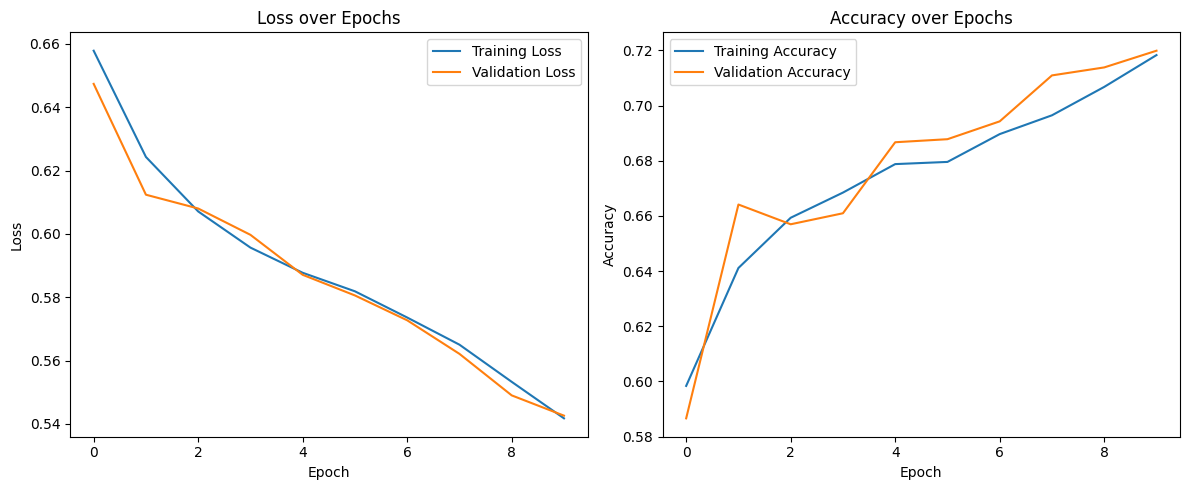

Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:01<00:00, 76.94it/s]

Accuracy: 0.7199


In [111]:
# Оновлена конфігурація xLSTM з підвищеною регуляризацією
cfg = xLSTMBlockStackConfig(
    mlstm_block=mLSTMBlockConfig(
        mlstm=mLSTMLayerConfig(
            conv1d_kernel_size=4, qkv_proj_blocksize=4, num_heads=4
        )
    ),
    slstm_block=sLSTMBlockConfig(
        slstm=sLSTMLayerConfig(
            backend="cuda",
            num_heads=4,
            conv1d_kernel_size=4,
            bias_init="powerlaw_blockdependent",
        ),
        feedforward=FeedForwardConfig(proj_factor=1.3, act_fn="gelu"),
    ),
    context_length=MAX_LEN,
    num_blocks=5,  # Зменшення кількості блоків для зменшення складності моделі
    embedding_dim=128,
    slstm_at=[1],
)

# Ініціалізація xLSTM стеку
xlstm_stack = xLSTMBlockStack(cfg).to("cuda")

# Модель з Dropout і L2-регуляризацією
class HateSpeechModel(nn.Module):
    def __init__(self, xlstm_stack, vocab_size, embedding_dim, dropout_prob=0.6):  # Збільшений Dropout
        super(HateSpeechModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.xlstm = xlstm_stack
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(embedding_dim, 2)

    def forward(self, x):
        x = self.embedding(x)
        x = self.xlstm(x)
        x = self.dropout(x)
        x = self.fc(x.mean(dim=1))
        return x

# Ініціалізація моделі
model = HateSpeechModel(xlstm_stack, vocab_size, 128).to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.01)  # Додана L2-регуляризація

# Функція для раннього зупинення
def early_stopping(val_losses, patience=3):
    if len(val_losses) < patience + 1:  # Додаємо перевірку довжини списку
        return False
    for i in range(1, patience + 1):
        if val_losses[-i] < val_losses[-i - 1]:
            return False
    return True

# Навчання моделі з раннім зупиненням
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for tweets, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            tweets, labels = tweets.to("cuda"), labels.to("cuda")
            optimizer.zero_grad()
            outputs = model(tweets)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_loss = total_loss / len(train_loader)
        accuracy = correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)

        # Валідація
        val_loss, val_accuracy = validate_model(model, test_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

        # Раннє зупинення
        if early_stopping(val_losses):
            print("Early stopping triggered")
            break

    return train_losses, train_accuracies, val_losses, val_accuracies

train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer)
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)
preds = test_model(model, test_loader)
accuracy = accuracy_score(y_test, preds)
print(f'Accuracy: {accuracy:.4f}')

## Exps num blocks 10, 256 embedding, 0.0005 lr

In [112]:
# Оновлена конфігурація xLSTM з підвищеною регуляризацією
cfg = xLSTMBlockStackConfig(
    mlstm_block=mLSTMBlockConfig(
        mlstm=mLSTMLayerConfig(
            conv1d_kernel_size=4, qkv_proj_blocksize=4, num_heads=4
        )
    ),
    slstm_block=sLSTMBlockConfig(
        slstm=sLSTMLayerConfig(
            backend="cuda",
            num_heads=4,
            conv1d_kernel_size=4,
            bias_init="powerlaw_blockdependent",
        ),
        feedforward=FeedForwardConfig(proj_factor=1.3, act_fn="gelu"),
    ),
    context_length=MAX_LEN,
    num_blocks=10,  # Зменшення кількості блоків для зменшення складності моделі
    embedding_dim=256,
    slstm_at=[1],
)

# Ініціалізація xLSTM стеку
xlstm_stack = xLSTMBlockStack(cfg).to("cuda")

# Модель з Dropout і L2-регуляризацією
class HateSpeechModel(nn.Module):
    def __init__(self, xlstm_stack, vocab_size, embedding_dim, dropout_prob=0.6):  # Збільшений Dropout
        super(HateSpeechModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.xlstm = xlstm_stack
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(embedding_dim, 2)

    def forward(self, x):
        x = self.embedding(x)
        x = self.xlstm(x)
        x = self.dropout(x)
        x = self.fc(x.mean(dim=1))
        return x

# Ініціалізація моделі
model = HateSpeechModel(xlstm_stack, vocab_size, 128).to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.01)  # Додана L2-регуляризація

# Функція для раннього зупинення
def early_stopping(val_losses, patience=3):
    if len(val_losses) < patience + 1:  # Додаємо перевірку довжини списку
        return False
    for i in range(1, patience + 1):
        if val_losses[-i] < val_losses[-i - 1]:
            return False
    return True

# Навчання моделі з раннім зупиненням
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for tweets, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            tweets, labels = tweets.to("cuda"), labels.to("cuda")
            optimizer.zero_grad()
            outputs = model(tweets)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_loss = total_loss / len(train_loader)
        accuracy = correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)

        # Валідація
        val_loss, val_accuracy = validate_model(model, test_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

        # Раннє зупинення
        if early_stopping(val_losses):
            print("Early stopping triggered")
            break

    return train_losses, train_accuracies, val_losses, val_accuracies

train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer)
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)
preds = test_model(model, test_loader)
accuracy = accuracy_score(y_test, preds)
print(f'Accuracy: {accuracy:.4f}')

{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/usr/local/cuda/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=256', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=4', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-O3', '-Xptxas -O3', '--extra-device-vectorization', '-DSLSTM_

Using /home/and/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
No modifications detected for re-loaded extension module slstm_HS256BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0, skipping build step...
Loading extension module slstm_HS256BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:546: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, training, *inputs):
/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:571: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_s):
Epoch 1/10:   0%|                                                                                                                                    

RuntimeError: Given normalized_shape=[256], expected input with shape [*, 256], but got input of size[64, 100, 128]

## Case 2 more data 0.1

## Exps wv 10% of dataset

In [113]:
# Завантаження та попередня обробка даних
path_to_dataset = "../datasets/HateSpeechDatasetBalanced.csv"
df = pd.read_csv(path_to_dataset)
df = df.sample(frac=0.1, random_state=42)  # Використання частини даних для швидкості
df = df[['Content', 'Label']]

def preprocess(text):
    return word_tokenize(text.lower())

df['Content'] = df['Content'].apply(preprocess)
# Розділення на тренувальну та тестову вибірки
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Побудова словника
all_words = [word for tweet in train_df['Content'] for word in tweet]
vocab = sorted(set(all_words))
word_to_idx = {word: idx+1 for idx, word in enumerate(vocab)}
vocab_size = len(vocab) + 1  # +1 для padding

# Кодування твітів
def encode_tweet(tweet):
    return [word_to_idx[word] for word in tweet if word in word_to_idx]

train_df['Content'] = train_df['Content'].apply(encode_tweet)
test_df['Content'] = test_df['Content'].apply(encode_tweet)

# Додавання padding
def pad_sequences(sequences, max_len):
    return np.array([seq + [0]*(max_len-len(seq)) if len(seq) < max_len else seq[:max_len] for seq in sequences])

MAX_LEN = 100
X_train = pad_sequences(train_df['Content'], MAX_LEN)
X_test = pad_sequences(test_df['Content'], MAX_LEN)

# Кодування міток
le = LabelEncoder()
y_train = le.fit_transform(train_df['Label'])
y_test = le.transform(test_df['Label'])

# Створення датасетів та DataLoader
class HateSpeechDataset(Dataset):
    def __init__(self, tweets, labels):
        self.tweets = tweets
        self.labels = labels

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        return torch.tensor(self.tweets[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

train_dataset = HateSpeechDataset(X_train, y_train)
test_dataset = HateSpeechDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:546: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, training, *inputs):
/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:571: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_s):
Epoch 1/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [00:49<00:00, 18.40it/s]


Epoch [1/10], Loss: 0.6316, Accuracy: 0.6330, Val Loss: 0.6031, Val Accuracy: 0.6613


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [00:48<00:00, 18.69it/s]


Epoch [2/10], Loss: 0.5967, Accuracy: 0.6720, Val Loss: 0.5799, Val Accuracy: 0.6867


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [00:49<00:00, 18.26it/s]


Epoch [3/10], Loss: 0.5678, Accuracy: 0.6983, Val Loss: 0.5547, Val Accuracy: 0.7001


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [00:50<00:00, 17.89it/s]


Epoch [4/10], Loss: 0.5300, Accuracy: 0.7321, Val Loss: 0.5053, Val Accuracy: 0.7649


Epoch 5/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [00:51<00:00, 17.70it/s]


Epoch [5/10], Loss: 0.5006, Accuracy: 0.7588, Val Loss: 0.4836, Val Accuracy: 0.7812


Epoch 6/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [00:51<00:00, 17.67it/s]


Epoch [6/10], Loss: 0.4719, Accuracy: 0.7781, Val Loss: 0.4794, Val Accuracy: 0.7845


Epoch 7/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [00:51<00:00, 17.54it/s]


Epoch [7/10], Loss: 0.4412, Accuracy: 0.8011, Val Loss: 0.4607, Val Accuracy: 0.7904


Epoch 8/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [00:52<00:00, 17.21it/s]


Epoch [8/10], Loss: 0.4142, Accuracy: 0.8148, Val Loss: 0.4434, Val Accuracy: 0.8014


Epoch 9/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [00:52<00:00, 17.25it/s]


Epoch [9/10], Loss: 0.3880, Accuracy: 0.8291, Val Loss: 0.4395, Val Accuracy: 0.7989


Epoch 10/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [00:49<00:00, 18.36it/s]


Epoch [10/10], Loss: 0.3702, Accuracy: 0.8390, Val Loss: 0.4375, Val Accuracy: 0.8029


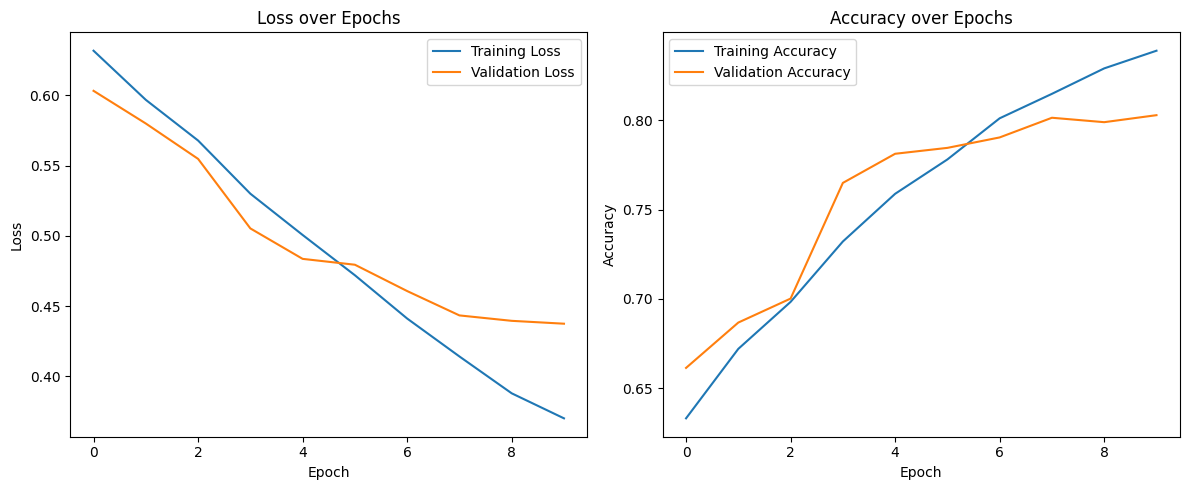

Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 227/227 [00:06<00:00, 34.24it/s]

Accuracy: 0.8029


In [114]:
# Оновлена конфігурація xLSTM з підвищеною регуляризацією
cfg = xLSTMBlockStackConfig(
    mlstm_block=mLSTMBlockConfig(
        mlstm=mLSTMLayerConfig(
            conv1d_kernel_size=4, qkv_proj_blocksize=4, num_heads=4
        )
    ),
    slstm_block=sLSTMBlockConfig(
        slstm=sLSTMLayerConfig(
            backend="cuda",
            num_heads=4,
            conv1d_kernel_size=4,
            bias_init="powerlaw_blockdependent",
        ),
        feedforward=FeedForwardConfig(proj_factor=1.3, act_fn="gelu"),
    ),
    context_length=MAX_LEN,
    num_blocks=5,  # Зменшення кількості блоків для зменшення складності моделі
    embedding_dim=128,
    slstm_at=[1],
)

# Ініціалізація xLSTM стеку
xlstm_stack = xLSTMBlockStack(cfg).to("cuda")

# Модель з Dropout і L2-регуляризацією
class HateSpeechModel(nn.Module):
    def __init__(self, xlstm_stack, vocab_size, embedding_dim, dropout_prob=0.6):  # Збільшений Dropout
        super(HateSpeechModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.xlstm = xlstm_stack
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(embedding_dim, 2)

    def forward(self, x):
        x = self.embedding(x)
        x = self.xlstm(x)
        x = self.dropout(x)
        x = self.fc(x.mean(dim=1))
        return x

# Ініціалізація моделі
model = HateSpeechModel(xlstm_stack, vocab_size, 128).to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)  # Додана L2-регуляризація

# Функція для раннього зупинення
def early_stopping(val_losses, patience=3):
    if len(val_losses) < patience + 1:  # Додаємо перевірку довжини списку
        return False
    for i in range(1, patience + 1):
        if val_losses[-i] < val_losses[-i - 1]:
            return False
    return True

# Навчання моделі з раннім зупиненням
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for tweets, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            tweets, labels = tweets.to("cuda"), labels.to("cuda")
            optimizer.zero_grad()
            outputs = model(tweets)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_loss = total_loss / len(train_loader)
        accuracy = correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)

        # Валідація
        val_loss, val_accuracy = validate_model(model, test_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

        # Раннє зупинення
        if early_stopping(val_losses):
            print("Early stopping triggered")
            break

    return train_losses, train_accuracies, val_losses, val_accuracies

train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer)
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)
preds = test_model(model, test_loader)
accuracy = accuracy_score(y_test, preds)
print(f'Accuracy: {accuracy:.4f}')

## Exps wv 25% of dataset

In [119]:
# Завантаження та попередня обробка даних
path_to_dataset = "../datasets/HateSpeechDatasetBalanced.csv"
df = pd.read_csv(path_to_dataset)
df = df.sample(frac=0.25, random_state=42)  # Використання частини даних для швидкості
df = df[['Content', 'Label']]

def preprocess(text):
    return word_tokenize(text.lower())

df['Content'] = df['Content'].apply(preprocess)
# Розділення на тренувальну та тестову вибірки
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Побудова словника
all_words = [word for tweet in train_df['Content'] for word in tweet]
vocab = sorted(set(all_words))
word_to_idx = {word: idx+1 for idx, word in enumerate(vocab)}
vocab_size = len(vocab) + 1  # +1 для padding

# Кодування твітів
def encode_tweet(tweet):
    return [word_to_idx[word] for word in tweet if word in word_to_idx]

train_df['Content'] = train_df['Content'].apply(encode_tweet)
test_df['Content'] = test_df['Content'].apply(encode_tweet)

# Додавання padding
def pad_sequences(sequences, max_len):
    return np.array([seq + [0]*(max_len-len(seq)) if len(seq) < max_len else seq[:max_len] for seq in sequences])

MAX_LEN = 100
X_train = pad_sequences(train_df['Content'], MAX_LEN)
X_test = pad_sequences(test_df['Content'], MAX_LEN)

# Кодування міток
le = LabelEncoder()
y_train = le.fit_transform(train_df['Label'])
y_test = le.transform(test_df['Label'])

# Створення датасетів та DataLoader
class HateSpeechDataset(Dataset):
    def __init__(self, tweets, labels):
        self.tweets = tweets
        self.labels = labels

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        return torch.tensor(self.tweets[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

train_dataset = HateSpeechDataset(X_train, y_train)
test_dataset = HateSpeechDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:546: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, training, *inputs):
/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:571: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_s):
Epoch 1/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2270/2270 [03:56<00:00,  9.60it/s]


Epoch [1/10], Loss: 0.6054, Accuracy: 0.6586, Val Loss: 0.5708, Val Accuracy: 0.6880


Epoch 2/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2270/2270 [03:59<00:00,  9.47it/s]


Epoch [2/10], Loss: 0.5162, Accuracy: 0.7437, Val Loss: 0.4796, Val Accuracy: 0.7818


Epoch 3/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2270/2270 [03:52<00:00,  9.77it/s]


Epoch [3/10], Loss: 0.4726, Accuracy: 0.7795, Val Loss: 0.4627, Val Accuracy: 0.7907


Epoch 4/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2270/2270 [03:49<00:00,  9.91it/s]


Epoch [4/10], Loss: 0.4505, Accuracy: 0.7948, Val Loss: 0.4670, Val Accuracy: 0.7727


Epoch 5/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2270/2270 [15:53<00:00,  2.38it/s]


Epoch [5/10], Loss: 0.4329, Accuracy: 0.8060, Val Loss: 0.4333, Val Accuracy: 0.7989


Epoch 6/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2270/2270 [02:04<00:00, 18.25it/s]


Epoch [6/10], Loss: 0.4119, Accuracy: 0.8155, Val Loss: 0.4203, Val Accuracy: 0.8066


Epoch 7/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2270/2270 [02:05<00:00, 18.15it/s]


Epoch [7/10], Loss: 0.4026, Accuracy: 0.8218, Val Loss: 0.4105, Val Accuracy: 0.8133


Epoch 8/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2270/2270 [02:05<00:00, 18.07it/s]


Epoch [8/10], Loss: 0.4017, Accuracy: 0.8225, Val Loss: 0.4333, Val Accuracy: 0.8083


Epoch 9/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2270/2270 [02:05<00:00, 18.10it/s]


Epoch [9/10], Loss: 0.3996, Accuracy: 0.8246, Val Loss: 0.4118, Val Accuracy: 0.8135


Epoch 10/10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2270/2270 [02:05<00:00, 18.12it/s]


Epoch [10/10], Loss: 0.3992, Accuracy: 0.8238, Val Loss: 0.4499, Val Accuracy: 0.7949


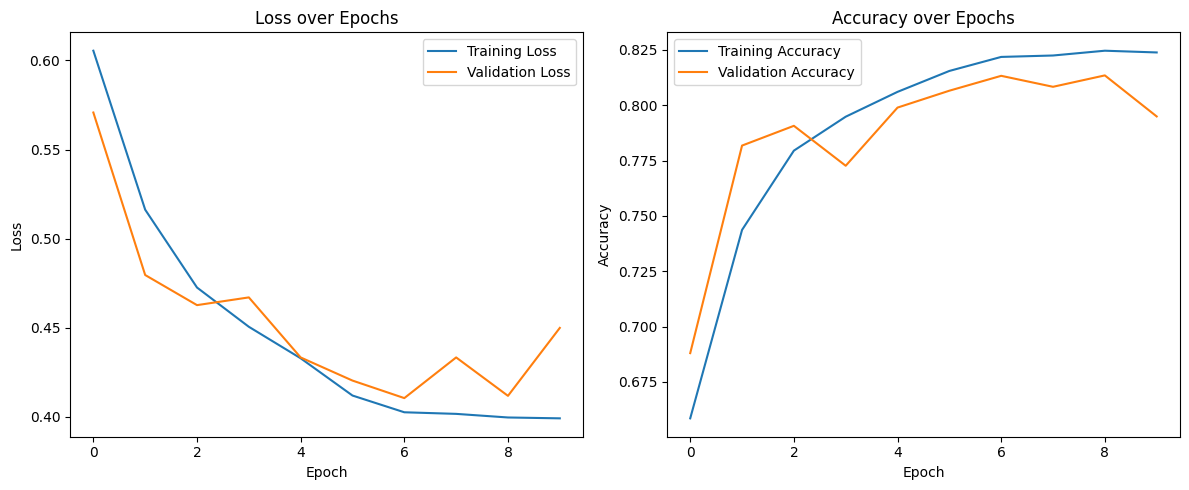

Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 568/568 [00:07<00:00, 74.29it/s]

Accuracy: 0.7949


In [120]:
# Оновлена конфігурація xLSTM з підвищеною регуляризацією
cfg = xLSTMBlockStackConfig(
    mlstm_block=mLSTMBlockConfig(
        mlstm=mLSTMLayerConfig(
            conv1d_kernel_size=4, qkv_proj_blocksize=4, num_heads=4
        )
    ),
    slstm_block=sLSTMBlockConfig(
        slstm=sLSTMLayerConfig(
            backend="cuda",
            num_heads=4,
            conv1d_kernel_size=4,
            bias_init="powerlaw_blockdependent",
        ),
        feedforward=FeedForwardConfig(proj_factor=1.3, act_fn="gelu"),
    ),
    context_length=MAX_LEN,
    num_blocks=5,  # Зменшення кількості блоків для зменшення складності моделі
    embedding_dim=128,
    slstm_at=[1],
)

# Ініціалізація xLSTM стеку
xlstm_stack = xLSTMBlockStack(cfg).to("cuda")

# Модель з Dropout і L2-регуляризацією
class HateSpeechModel(nn.Module):
    def __init__(self, xlstm_stack, vocab_size, embedding_dim, dropout_prob=0.6):  # Збільшений Dropout
        super(HateSpeechModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.xlstm = xlstm_stack
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(embedding_dim, 2)

    def forward(self, x):
        x = self.embedding(x)
        x = self.xlstm(x)
        x = self.dropout(x)
        x = self.fc(x.mean(dim=1))
        return x

# Ініціалізація моделі
model = HateSpeechModel(xlstm_stack, vocab_size, 128).to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)  # Додана L2-регуляризація

# Функція для раннього зупинення
def early_stopping(val_losses, patience=3):
    if len(val_losses) < patience + 1:  # Додаємо перевірку довжини списку
        return False
    for i in range(1, patience + 1):
        if val_losses[-i] < val_losses[-i - 1]:
            return False
    return True

# Навчання моделі з раннім зупиненням
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for tweets, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            tweets, labels = tweets.to("cuda"), labels.to("cuda")
            optimizer.zero_grad()
            outputs = model(tweets)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_loss = total_loss / len(train_loader)
        accuracy = correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)

        # Валідація
        val_loss, val_accuracy = validate_model(model, test_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

        # Раннє зупинення
        if early_stopping(val_losses):
            print("Early stopping triggered")
            break

    return train_losses, train_accuracies, val_losses, val_accuracies

train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer)
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)
preds = test_model(model, test_loader)
accuracy = accuracy_score(y_test, preds)
print(f'Accuracy: {accuracy:.4f}')

## Exps wv 10% 7 num blocks

In [134]:
# Завантаження та попередня обробка даних
path_to_dataset = "../datasets/HateSpeechDatasetBalanced.csv"
df = pd.read_csv(path_to_dataset)
df = df.sample(frac=0.1, random_state=42)  # Використання частини даних для швидкості
df = df[['Content', 'Label']]

def preprocess(text):
    return word_tokenize(text.lower())

df['Content'] = df['Content'].apply(preprocess)
# Розділення на тренувальну та тестову вибірки
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Побудова словника
all_words = [word for tweet in train_df['Content'] for word in tweet]
vocab = sorted(set(all_words))
word_to_idx = {word: idx+1 for idx, word in enumerate(vocab)}
vocab_size = len(vocab) + 1  # +1 для padding

# Кодування твітів
def encode_tweet(tweet):
    return [word_to_idx[word] for word in tweet if word in word_to_idx]

train_df['Content'] = train_df['Content'].apply(encode_tweet)
test_df['Content'] = test_df['Content'].apply(encode_tweet)

# Додавання padding
def pad_sequences(sequences, max_len):
    return np.array([seq + [0]*(max_len-len(seq)) if len(seq) < max_len else seq[:max_len] for seq in sequences])

MAX_LEN = 100
X_train = pad_sequences(train_df['Content'], MAX_LEN)
X_test = pad_sequences(test_df['Content'], MAX_LEN)

# Кодування міток
le = LabelEncoder()
y_train = le.fit_transform(train_df['Label'])
y_test = le.transform(test_df['Label'])

# Створення датасетів та DataLoader
class HateSpeechDataset(Dataset):
    def __init__(self, tweets, labels):
        self.tweets = tweets
        self.labels = labels

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        return torch.tensor(self.tweets[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

train_dataset = HateSpeechDataset(X_train, y_train)
test_dataset = HateSpeechDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:546: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, training, *inputs):
/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:571: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_s):
Epoch 1/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [01:08<00:00, 13.28it/s]


Epoch [1/10], Loss: 0.6346, Accuracy: 0.6258, Val Loss: 0.6023, Val Accuracy: 0.6669


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [01:07<00:00, 13.45it/s]


Epoch [2/10], Loss: 0.5954, Accuracy: 0.6715, Val Loss: 0.5764, Val Accuracy: 0.6897


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [01:07<00:00, 13.38it/s]


Epoch [3/10], Loss: 0.5631, Accuracy: 0.6997, Val Loss: 0.5342, Val Accuracy: 0.7306


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [01:07<00:00, 13.46it/s]


Epoch [4/10], Loss: 0.5170, Accuracy: 0.7432, Val Loss: 0.4959, Val Accuracy: 0.7666


Epoch 5/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [01:07<00:00, 13.39it/s]


Epoch [5/10], Loss: 0.4649, Accuracy: 0.7812, Val Loss: 0.4405, Val Accuracy: 0.7927


Epoch 6/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [01:08<00:00, 13.35it/s]


Epoch [6/10], Loss: 0.4044, Accuracy: 0.8197, Val Loss: 0.4220, Val Accuracy: 0.8043


Epoch 7/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [01:07<00:00, 13.43it/s]


Epoch [7/10], Loss: 0.3646, Accuracy: 0.8427, Val Loss: 0.4183, Val Accuracy: 0.8100


Epoch 8/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [01:07<00:00, 13.36it/s]


Epoch [8/10], Loss: 0.3414, Accuracy: 0.8565, Val Loss: 0.4210, Val Accuracy: 0.8131


Epoch 9/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [01:07<00:00, 13.38it/s]


Epoch [9/10], Loss: 0.3221, Accuracy: 0.8662, Val Loss: 0.4198, Val Accuracy: 0.8098


Epoch 10/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [01:07<00:00, 13.43it/s]


Epoch [10/10], Loss: 0.3133, Accuracy: 0.8709, Val Loss: 0.4232, Val Accuracy: 0.8120


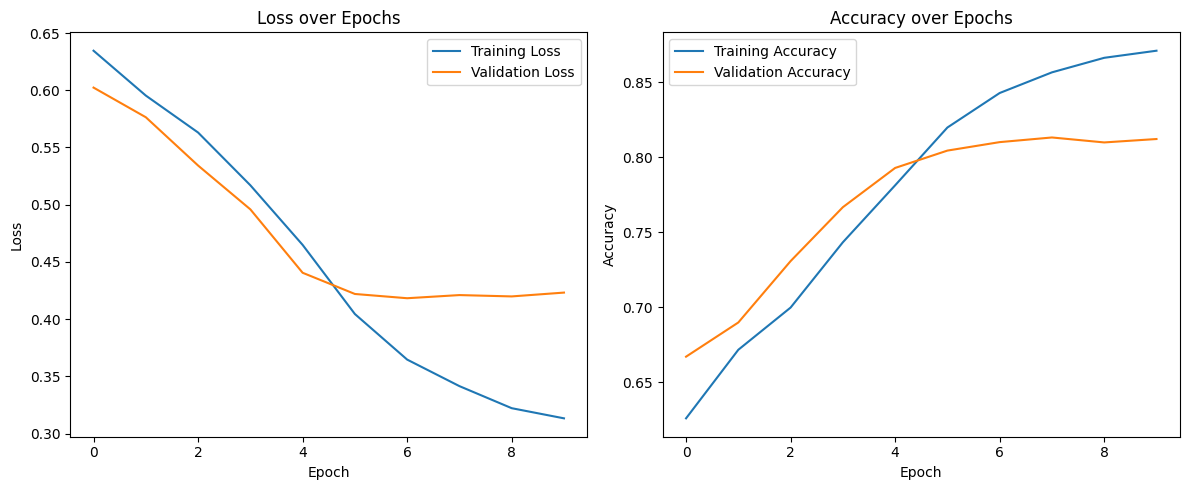

Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 227/227 [00:04<00:00, 55.18it/s]

Accuracy: 0.8120


In [122]:
# Оновлена конфігурація xLSTM з підвищеною регуляризацією
cfg = xLSTMBlockStackConfig(
    mlstm_block=mLSTMBlockConfig(
        mlstm=mLSTMLayerConfig(
            conv1d_kernel_size=4, qkv_proj_blocksize=4, num_heads=4
        )
    ),
    slstm_block=sLSTMBlockConfig(
        slstm=sLSTMLayerConfig(
            backend="cuda",
            num_heads=4,
            conv1d_kernel_size=4,
            bias_init="powerlaw_blockdependent",
        ),
        feedforward=FeedForwardConfig(proj_factor=1.3, act_fn="gelu"),
    ),
    context_length=MAX_LEN,
    num_blocks=7,  # Зменшення кількості блоків для зменшення складності моделі
    embedding_dim=128,
    slstm_at=[1],
)

# Ініціалізація xLSTM стеку
xlstm_stack = xLSTMBlockStack(cfg).to("cuda")

# Модель з Dropout і L2-регуляризацією
class HateSpeechModel(nn.Module):
    def __init__(self, xlstm_stack, vocab_size, embedding_dim, dropout_prob=0.6):  # Збільшений Dropout
        super(HateSpeechModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.xlstm = xlstm_stack
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(embedding_dim, 2)

    def forward(self, x):
        x = self.embedding(x)
        x = self.xlstm(x)
        x = self.dropout(x)
        x = self.fc(x.mean(dim=1))
        return x

# Ініціалізація моделі
model = HateSpeechModel(xlstm_stack, vocab_size, 128).to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)  # Додана L2-регуляризація

# Функція для раннього зупинення
def early_stopping(val_losses, patience=3):
    if len(val_losses) < patience + 1:  # Додаємо перевірку довжини списку
        return False
    for i in range(1, patience + 1):
        if val_losses[-i] < val_losses[-i - 1]:
            return False
    return True

# Навчання моделі з раннім зупиненням
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for tweets, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            tweets, labels = tweets.to("cuda"), labels.to("cuda")
            optimizer.zero_grad()
            outputs = model(tweets)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_loss = total_loss / len(train_loader)
        accuracy = correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)

        # Валідація
        val_loss, val_accuracy = validate_model(model, test_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

        # Раннє зупинення
        if early_stopping(val_losses):
            print("Early stopping triggered")
            break

    return train_losses, train_accuracies, val_losses, val_accuracies

train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer)
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)
preds = test_model(model, test_loader)
accuracy = accuracy_score(y_test, preds)
print(f'Accuracy: {accuracy:.4f}')

In [125]:
num_epochs =3
for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for tweets, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        tweets, labels = tweets.to("cuda"), labels.to("cuda")
        optimizer.zero_grad()
        outputs = model(tweets)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    # Валідація
    val_loss, val_accuracy = validate_model(model, test_loader, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # Раннє зупинення
    if early_stopping(val_losses):
        print("Early stopping triggered")
        break

Epoch 1/3: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [01:07<00:00, 13.45it/s]


Epoch [1/3], Loss: 0.3083, Accuracy: 0.8726, Val Loss: 0.4189, Val Accuracy: 0.8070


Epoch 2/3: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [01:07<00:00, 13.48it/s]


Epoch [2/3], Loss: 0.3020, Accuracy: 0.8765, Val Loss: 0.4374, Val Accuracy: 0.8129


Epoch 3/3: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [01:07<00:00, 13.40it/s]


Epoch [3/3], Loss: 0.2985, Accuracy: 0.8760, Val Loss: 0.4284, Val Accuracy: 0.8087


In [126]:
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for tweets, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        tweets, labels = tweets.to("cuda"), labels.to("cuda")
        optimizer.zero_grad()
        outputs = model(tweets)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    # Валідація
    val_loss, val_accuracy = validate_model(model, test_loader, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # Раннє зупинення
    if early_stopping(val_losses):
        print("Early stopping triggered")
        break

Epoch 1/5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [01:08<00:00, 13.29it/s]


Epoch [1/5], Loss: 0.3003, Accuracy: 0.8752, Val Loss: 0.4263, Val Accuracy: 0.8106


Epoch 2/5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [01:08<00:00, 13.32it/s]


Epoch [2/5], Loss: 0.2976, Accuracy: 0.8762, Val Loss: 0.4192, Val Accuracy: 0.8086


Epoch 3/5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [01:07<00:00, 13.42it/s]


Epoch [3/5], Loss: 0.2979, Accuracy: 0.8769, Val Loss: 0.4270, Val Accuracy: 0.8109


Epoch 4/5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [01:07<00:00, 13.52it/s]


Epoch [4/5], Loss: 0.2981, Accuracy: 0.8780, Val Loss: 0.4081, Val Accuracy: 0.8173


Epoch 5/5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [01:07<00:00, 13.44it/s]


Epoch [5/5], Loss: 0.2945, Accuracy: 0.8789, Val Loss: 0.4279, Val Accuracy: 0.8162


## Exps wv lr 0.005 20 epochs

/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:546: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, training, *inputs):
/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:571: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_s):
Epoch 1/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [00:48<00:00, 18.80it/s]


Epoch [1/20], Loss: 0.6516, Accuracy: 0.6063, Val Loss: 0.6232, Val Accuracy: 0.6459


Epoch 2/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [00:48<00:00, 18.63it/s]


Epoch [2/20], Loss: 0.6062, Accuracy: 0.6624, Val Loss: 0.5929, Val Accuracy: 0.6822


Epoch 3/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [00:48<00:00, 18.65it/s]


Epoch [3/20], Loss: 0.5873, Accuracy: 0.6785, Val Loss: 0.5776, Val Accuracy: 0.6936


Epoch 4/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [00:48<00:00, 18.64it/s]


Epoch [4/20], Loss: 0.5712, Accuracy: 0.6956, Val Loss: 0.5615, Val Accuracy: 0.7107


Epoch 5/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [00:48<00:00, 18.90it/s]


Epoch [5/20], Loss: 0.5518, Accuracy: 0.7144, Val Loss: 0.5368, Val Accuracy: 0.7248


Epoch 6/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [00:47<00:00, 19.00it/s]


Epoch [6/20], Loss: 0.5220, Accuracy: 0.7386, Val Loss: 0.5115, Val Accuracy: 0.7413


Epoch 7/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [00:48<00:00, 18.80it/s]


Epoch [7/20], Loss: 0.4815, Accuracy: 0.7690, Val Loss: 0.4650, Val Accuracy: 0.7826


Epoch 8/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [00:47<00:00, 19.05it/s]


Epoch [8/20], Loss: 0.4365, Accuracy: 0.7968, Val Loss: 0.4309, Val Accuracy: 0.8013


Epoch 9/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [00:48<00:00, 18.81it/s]


Epoch [9/20], Loss: 0.3857, Accuracy: 0.8299, Val Loss: 0.4105, Val Accuracy: 0.8124


Epoch 10/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [00:48<00:00, 18.78it/s]


Epoch [10/20], Loss: 0.3335, Accuracy: 0.8585, Val Loss: 0.4065, Val Accuracy: 0.8156


Epoch 11/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [00:48<00:00, 18.74it/s]


Epoch [11/20], Loss: 0.2917, Accuracy: 0.8817, Val Loss: 0.4187, Val Accuracy: 0.8112


Epoch 12/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [00:48<00:00, 18.89it/s]


Epoch [12/20], Loss: 0.2647, Accuracy: 0.8941, Val Loss: 0.4230, Val Accuracy: 0.8146


Epoch 13/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [00:47<00:00, 19.07it/s]


Epoch [13/20], Loss: 0.2455, Accuracy: 0.9034, Val Loss: 0.4543, Val Accuracy: 0.8093
Early stopping triggered


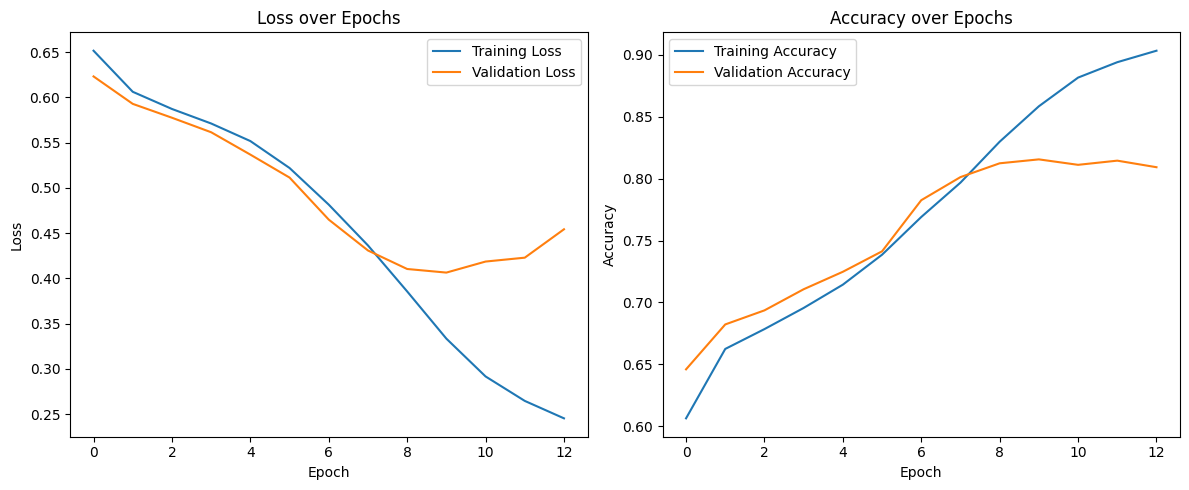

Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 227/227 [00:02<00:00, 76.45it/s]

Accuracy: 0.8093


In [127]:
# Оновлена конфігурація xLSTM з підвищеною регуляризацією
cfg = xLSTMBlockStackConfig(
    mlstm_block=mLSTMBlockConfig(
        mlstm=mLSTMLayerConfig(
            conv1d_kernel_size=4, qkv_proj_blocksize=4, num_heads=4
        )
    ),
    slstm_block=sLSTMBlockConfig(
        slstm=sLSTMLayerConfig(
            backend="cuda",
            num_heads=4,
            conv1d_kernel_size=4,
            bias_init="powerlaw_blockdependent",
        ),
        feedforward=FeedForwardConfig(proj_factor=1.3, act_fn="gelu"),
    ),
    context_length=MAX_LEN,
    num_blocks=5,  # Зменшення кількості блоків для зменшення складності моделі
    embedding_dim=128,
    slstm_at=[1],
)

# Ініціалізація xLSTM стеку
xlstm_stack = xLSTMBlockStack(cfg).to("cuda")

# Модель з Dropout і L2-регуляризацією
class HateSpeechModel(nn.Module):
    def __init__(self, xlstm_stack, vocab_size, embedding_dim, dropout_prob=0.6):  # Збільшений Dropout
        super(HateSpeechModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.xlstm = xlstm_stack
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(embedding_dim, 2)

    def forward(self, x):
        x = self.embedding(x)
        x = self.xlstm(x)
        x = self.dropout(x)
        x = self.fc(x.mean(dim=1))
        return x

# Ініціалізація моделі
model = HateSpeechModel(xlstm_stack, vocab_size, 128).to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.01)  # Додана L2-регуляризація

# Функція для раннього зупинення
def early_stopping(val_losses, patience=3):
    if len(val_losses) < patience + 1:  # Додаємо перевірку довжини списку
        return False
    for i in range(1, patience + 1):
        if val_losses[-i] < val_losses[-i - 1]:
            return False
    return True

# Навчання моделі з раннім зупиненням
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=20):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for tweets, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            tweets, labels = tweets.to("cuda"), labels.to("cuda")
            optimizer.zero_grad()
            outputs = model(tweets)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_loss = total_loss / len(train_loader)
        accuracy = correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)

        # Валідація
        val_loss, val_accuracy = validate_model(model, test_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

        # Раннє зупинення
        if early_stopping(val_losses):
            print("Early stopping triggered")
            break

    return train_losses, train_accuracies, val_losses, val_accuracies

train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer)
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)
preds = test_model(model, test_loader)
accuracy = accuracy_score(y_test, preds)
print(f'Accuracy: {accuracy:.4f}')

## Exps wv more blocks + batch normalization

/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:546: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, training, *inputs):
/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:571: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_s):


{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/usr/local/cuda/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=128', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=4', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-O3', '-Xptxas -O3', '--extra-device-vectorization', '-DSLSTM_

Using /home/and/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
No modifications detected for re-loaded extension module slstm_HS128BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0, skipping build step...
Loading extension module slstm_HS128BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...


{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/usr/local/cuda/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=128', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=4', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-O3', '-Xptxas -O3', '--extra-device-vectorization', '-DSLSTM_

Using /home/and/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
No modifications detected for re-loaded extension module slstm_HS128BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0, skipping build step...
Loading extension module slstm_HS128BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
Epoch 1/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [01:00<00:00, 14.95it/s]


Epoch [1/20], Loss: 0.5270, Accuracy: 0.7253, Val Loss: 0.4381, Val Accuracy: 0.7916


Epoch 2/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [01:02<00:00, 14.61it/s]


Epoch [2/20], Loss: 0.3840, Accuracy: 0.8257, Val Loss: 0.3953, Val Accuracy: 0.8187


Epoch 3/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [01:02<00:00, 14.50it/s]


Epoch [3/20], Loss: 0.2943, Accuracy: 0.8762, Val Loss: 0.4282, Val Accuracy: 0.8090


Epoch 4/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [01:00<00:00, 14.92it/s]


Epoch [4/20], Loss: 0.1943, Accuracy: 0.9238, Val Loss: 0.5005, Val Accuracy: 0.8178


Epoch 5/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [01:01<00:00, 14.87it/s]


Epoch [5/20], Loss: 0.1166, Accuracy: 0.9571, Val Loss: 0.5624, Val Accuracy: 0.8159
Early stopping triggered


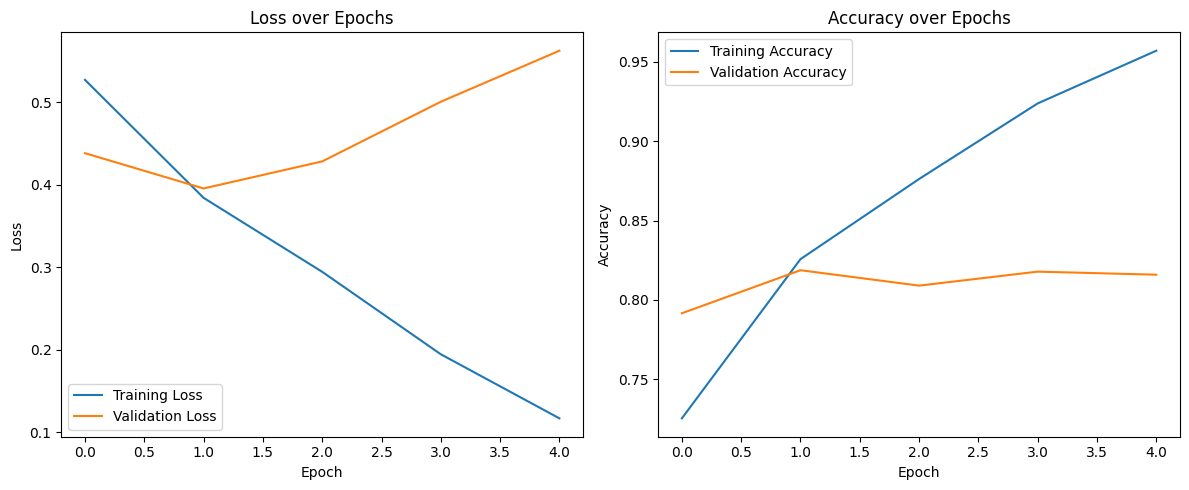

Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 227/227 [00:04<00:00, 56.74it/s]

Accuracy: 0.8159


In [130]:
# Оновлена конфігурація xLSTM з підвищеною регуляризацією
cfg = xLSTMBlockStackConfig(
    mlstm_block=mLSTMBlockConfig(
        mlstm=mLSTMLayerConfig(
            conv1d_kernel_size=4, qkv_proj_blocksize=4, num_heads=4
        )
    ),
    slstm_block=sLSTMBlockConfig(
        slstm=sLSTMLayerConfig(
            backend="cuda",
            num_heads=4,  # Кількість голів залишається 4
            conv1d_kernel_size=4,
            bias_init="powerlaw_blockdependent",
        ),
        feedforward=FeedForwardConfig(proj_factor=1.3, act_fn="gelu"),
    ),
    context_length=MAX_LEN,
    num_blocks=7,  # Використання більшої кількості блоків
    embedding_dim=128,  # Кратне num_heads (4)
    slstm_at=[1, 3, 5],
)

# Ініціалізація xLSTM стеку
xlstm_stack = xLSTMBlockStack(cfg).to("cuda")

# Модель з розширеною архітектурою
class EnhancedHateSpeechModel(nn.Module):
    def __init__(self, xlstm_stack, vocab_size, embedding_dim, dropout_prob=0.5):
        super(EnhancedHateSpeechModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.xlstm = xlstm_stack
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(embedding_dim, 2)

    def forward(self, x):
        x = self.embedding(x)
        x = self.xlstm(x)
        x = self.dropout(x.mean(dim=1))
        x = self.fc(x)
        return x

# Ініціалізація моделі
model = EnhancedHateSpeechModel(xlstm_stack, vocab_size, 128).to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=0.01)

# Навчання моделі
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10)
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)
preds = test_model(model, test_loader)
accuracy = accuracy_score(y_test, preds)
print(f'Accuracy: {accuracy:.4f}')


## Exps 3

/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:546: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, training, *inputs):
/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:571: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_s):
Epoch 1/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [01:25<00:00, 10.59it/s]


Epoch [1/10], Loss: 0.5320, Accuracy: 0.7257, Val Loss: 0.4337, Val Accuracy: 0.7927


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [01:29<00:00, 10.13it/s]


Epoch [2/10], Loss: 0.3971, Accuracy: 0.8178, Val Loss: 0.3979, Val Accuracy: 0.8170


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [01:27<00:00, 10.34it/s]


Epoch [3/10], Loss: 0.3137, Accuracy: 0.8658, Val Loss: 0.4091, Val Accuracy: 0.8217


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [01:30<00:00, 10.02it/s]


Epoch [4/10], Loss: 0.2149, Accuracy: 0.9144, Val Loss: 0.4883, Val Accuracy: 0.8085


Epoch 5/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [01:29<00:00, 10.12it/s]


Epoch [5/10], Loss: 0.1337, Accuracy: 0.9499, Val Loss: 0.5808, Val Accuracy: 0.8113
Early stopping triggered


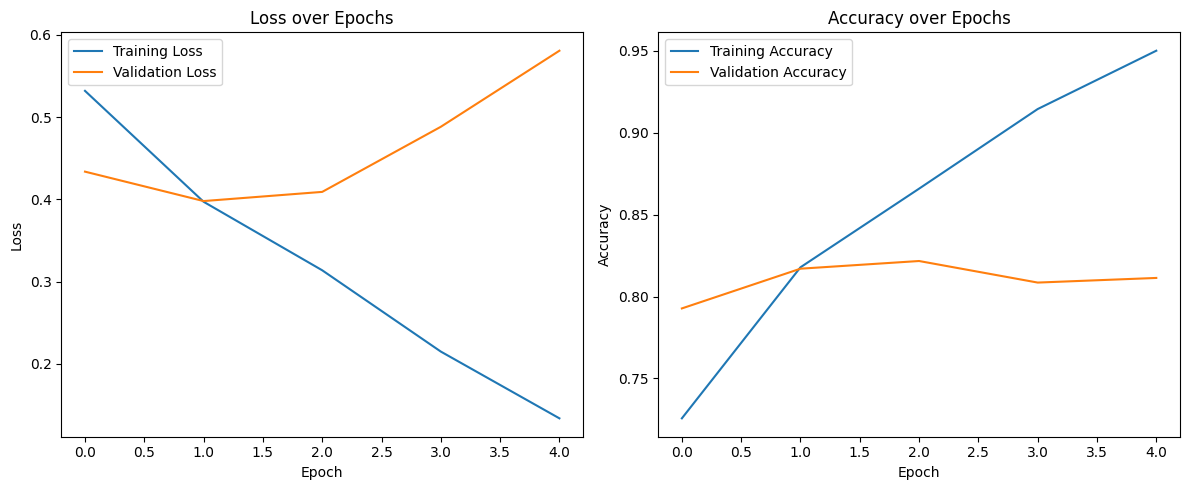

Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 227/227 [00:05<00:00, 38.43it/s]


Accuracy: 0.8113


In [132]:
# Оновлена конфігурація xLSTM з підвищеною регуляризацією
cfg = xLSTMBlockStackConfig(
    mlstm_block=mLSTMBlockConfig(
        mlstm=mLSTMLayerConfig(
            conv1d_kernel_size=4, qkv_proj_blocksize=4, num_heads=4
        )
    ),
    slstm_block=sLSTMBlockConfig(
        slstm=sLSTMLayerConfig(
            backend="cuda",
            num_heads=4,  # Кількість голів залишається 4
            conv1d_kernel_size=4,
            bias_init="powerlaw_blockdependent",
        ),
        feedforward=FeedForwardConfig(proj_factor=1.3, act_fn="gelu"),
    ),
    context_length=MAX_LEN,
    num_blocks=7,  # Використання більшої кількості блоків
    embedding_dim=128,  # Кратне num_heads (4)
    slstm_at=[1, 3, 5],
)

# Ініціалізація xLSTM стеку
xlstm_stack = xLSTMBlockStack(cfg).to("cuda")

# Модель з розширеною архітектурою та батч-нормалізацією
class EnhancedHateSpeechModel(nn.Module):
    def __init__(self, xlstm_stack, vocab_size, embedding_dim, dropout_prob=0.5):
        super(EnhancedHateSpeechModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.xlstm = xlstm_stack
        self.batch_norm = nn.BatchNorm1d(embedding_dim)  # Додаємо батч-нормалізацію
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(embedding_dim, 2)

    def forward(self, x):
        x = self.embedding(x)
        x = self.xlstm(x)
        x = self.batch_norm(x.mean(dim=1))  # Нормалізація перед лінійним шаром
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Ініціалізація моделі
model = EnhancedHateSpeechModel(xlstm_stack, vocab_size, 128).to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=0.01)

# Навчання моделі
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10)
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)
preds = test_model(model, test_loader)
accuracy = accuracy_score(y_test, preds)
print(f'Accuracy: {accuracy:.4f}')

## Exps 3

In [142]:
# Завантаження та попередня обробка даних
path_to_dataset = "../datasets/HateSpeechDatasetBalanced.csv"
df = pd.read_csv(path_to_dataset)
df = df.sample(frac=0.1, random_state=42)  # Використання частини даних для швидкості
df = df[['Content', 'Label']]

def preprocess(text):
    return word_tokenize(text.lower())

df['Content'] = df['Content'].apply(preprocess)
# Розділення на тренувальну та тестову вибірки
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Побудова словника
all_words = [word for tweet in train_df['Content'] for word in tweet]
vocab = sorted(set(all_words))
word_to_idx = {word: idx+1 for idx, word in enumerate(vocab)}
vocab_size = len(vocab) + 1  # +1 для padding

# Кодування твітів
def encode_tweet(tweet):
    return [word_to_idx[word] for word in tweet if word in word_to_idx]

train_df['Content'] = train_df['Content'].apply(encode_tweet)
test_df['Content'] = test_df['Content'].apply(encode_tweet)

# Додавання padding
def pad_sequences(sequences, max_len):
    return np.array([seq + [0]*(max_len-len(seq)) if len(seq) < max_len else seq[:max_len] for seq in sequences])

MAX_LEN = 100
X_train = pad_sequences(train_df['Content'], MAX_LEN)
X_test = pad_sequences(test_df['Content'], MAX_LEN)

# Кодування міток
le = LabelEncoder()
y_train = le.fit_transform(train_df['Label'])
y_test = le.transform(test_df['Label'])

# Створення датасетів та DataLoader
class HateSpeechDataset(Dataset):
    def __init__(self, tweets, labels):
        self.tweets = tweets
        self.labels = labels

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        return torch.tensor(self.tweets[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

train_dataset = HateSpeechDataset(X_train, y_train)
test_dataset = HateSpeechDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [143]:
df.count()

Content    72612
Label      72612
dtype: int64

In [146]:
!pip install seaborn

/tmp/ipykernel_1653/1687926436.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")


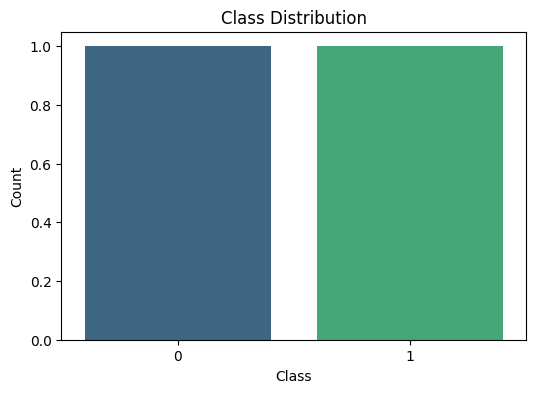

In [147]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

labels = [0, 1]  # Замініть на ваші дані

# Рахуємо кількість кожного класу
class_counts = Counter(labels)

# Графік розподілу класів
plt.figure(figsize=(6, 4))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:546: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, training, *inputs):
/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:571: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_s):


Testing activation function: relu


Epoch 1/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:35<00:00, 12.97it/s]


Epoch [1/10], Loss: 0.6539, Accuracy: 0.6023, Val Loss: 0.6195, Val Accuracy: 0.6570


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:51<00:00,  8.80it/s]


Epoch [2/10], Loss: 0.6075, Accuracy: 0.6565, Val Loss: 0.5966, Val Accuracy: 0.6786


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:53<00:00,  8.42it/s]


Epoch [3/10], Loss: 0.5878, Accuracy: 0.6784, Val Loss: 0.5854, Val Accuracy: 0.6833


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:53<00:00,  8.41it/s]


Epoch [4/10], Loss: 0.5782, Accuracy: 0.6880, Val Loss: 0.5860, Val Accuracy: 0.6752


Epoch 5/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [01:06<00:00,  6.85it/s]


Epoch [5/10], Loss: 0.5656, Accuracy: 0.6971, Val Loss: 0.5515, Val Accuracy: 0.7251


Epoch 6/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [01:01<00:00,  7.43it/s]


Epoch [6/10], Loss: 0.5457, Accuracy: 0.7161, Val Loss: 0.5433, Val Accuracy: 0.7406


Epoch 7/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:58<00:00,  7.76it/s]


Epoch [7/10], Loss: 0.5243, Accuracy: 0.7327, Val Loss: 0.5137, Val Accuracy: 0.7521


Epoch 8/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:59<00:00,  7.69it/s]


Epoch [8/10], Loss: 0.5023, Accuracy: 0.7518, Val Loss: 0.5089, Val Accuracy: 0.7626


Epoch 9/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:56<00:00,  8.02it/s]


Epoch [9/10], Loss: 0.4814, Accuracy: 0.7708, Val Loss: 0.4952, Val Accuracy: 0.7709


Epoch 10/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:55<00:00,  8.17it/s]


Epoch [10/10], Loss: 0.4511, Accuracy: 0.7925, Val Loss: 0.5175, Val Accuracy: 0.7402


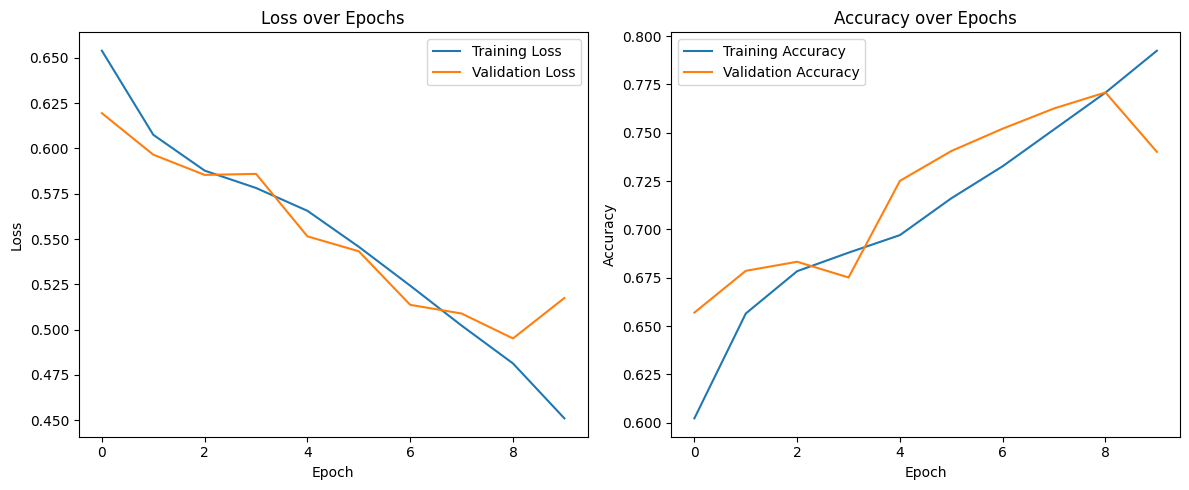

Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:04<00:00, 28.26it/s]
/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:546: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, training, *inputs):
/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:571: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_s):


Accuracy relu: 0.7402
Testing activation function: gelu


Epoch 1/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [01:04<00:00,  7.09it/s]


Epoch [1/10], Loss: 0.6446, Accuracy: 0.6131, Val Loss: 0.6131, Val Accuracy: 0.6584


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [01:04<00:00,  7.06it/s]


Epoch [2/10], Loss: 0.6084, Accuracy: 0.6578, Val Loss: 0.6041, Val Accuracy: 0.6691


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [01:14<00:00,  6.13it/s]


Epoch [3/10], Loss: 0.5933, Accuracy: 0.6725, Val Loss: 0.5949, Val Accuracy: 0.6742


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:55<00:00,  8.18it/s]


Epoch [4/10], Loss: 0.5831, Accuracy: 0.6793, Val Loss: 0.5767, Val Accuracy: 0.6911


Epoch 5/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:55<00:00,  8.13it/s]


Epoch [5/10], Loss: 0.5674, Accuracy: 0.6946, Val Loss: 0.5642, Val Accuracy: 0.7019


Epoch 6/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [01:02<00:00,  7.27it/s]


Epoch [6/10], Loss: 0.5478, Accuracy: 0.7139, Val Loss: 0.5402, Val Accuracy: 0.7316


Epoch 7/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [01:04<00:00,  6.99it/s]


Epoch [7/10], Loss: 0.5270, Accuracy: 0.7311, Val Loss: 0.5198, Val Accuracy: 0.7546


Epoch 8/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [13:41<00:00,  1.81s/it]


Epoch [8/10], Loss: 0.4998, Accuracy: 0.7552, Val Loss: 0.5042, Val Accuracy: 0.7615


Epoch 9/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:23<00:00, 19.10it/s]


Epoch [9/10], Loss: 0.4752, Accuracy: 0.7762, Val Loss: 0.5064, Val Accuracy: 0.7670


Epoch 10/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:23<00:00, 19.12it/s]


Epoch [10/10], Loss: 0.4417, Accuracy: 0.7962, Val Loss: 0.4857, Val Accuracy: 0.7772


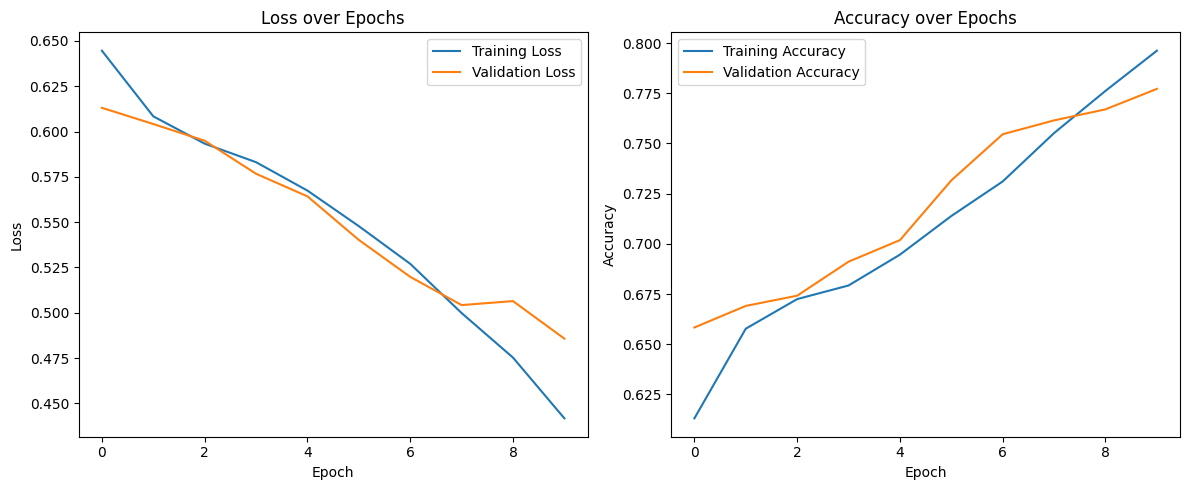

Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:01<00:00, 76.55it/s]
/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:546: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, training, *inputs):
/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:571: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_s):


Accuracy gelu: 0.7772
Testing activation function: selu


Epoch 1/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:24<00:00, 18.89it/s]


Epoch [1/10], Loss: 0.6506, Accuracy: 0.6093, Val Loss: 0.6369, Val Accuracy: 0.6040


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:24<00:00, 18.89it/s]


Epoch [2/10], Loss: 0.6138, Accuracy: 0.6534, Val Loss: 0.6028, Val Accuracy: 0.6695


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:23<00:00, 19.14it/s]


Epoch [3/10], Loss: 0.6000, Accuracy: 0.6641, Val Loss: 0.5910, Val Accuracy: 0.6860


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:23<00:00, 19.31it/s]


Epoch [4/10], Loss: 0.5873, Accuracy: 0.6776, Val Loss: 0.5729, Val Accuracy: 0.7013


Epoch 5/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:23<00:00, 19.19it/s]


Epoch [5/10], Loss: 0.5680, Accuracy: 0.6958, Val Loss: 0.5663, Val Accuracy: 0.6979


Epoch 6/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:24<00:00, 18.77it/s]


Epoch [6/10], Loss: 0.5473, Accuracy: 0.7144, Val Loss: 0.5598, Val Accuracy: 0.7009


Epoch 7/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:23<00:00, 19.05it/s]


Epoch [7/10], Loss: 0.5235, Accuracy: 0.7351, Val Loss: 0.5144, Val Accuracy: 0.7519


Epoch 8/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:23<00:00, 19.18it/s]


Epoch [8/10], Loss: 0.5052, Accuracy: 0.7528, Val Loss: 0.5144, Val Accuracy: 0.7476


Epoch 9/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:23<00:00, 19.28it/s]


Epoch [9/10], Loss: 0.4851, Accuracy: 0.7682, Val Loss: 0.4917, Val Accuracy: 0.7678


Epoch 10/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:23<00:00, 19.14it/s]


Epoch [10/10], Loss: 0.4559, Accuracy: 0.7874, Val Loss: 0.4806, Val Accuracy: 0.7805


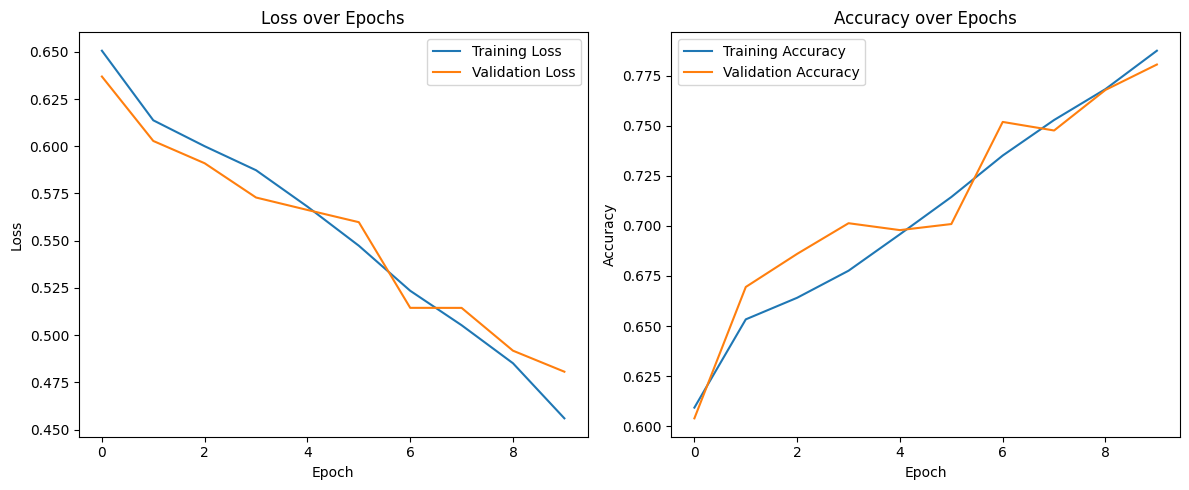

Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:01<00:00, 75.91it/s]

Accuracy selu: 0.7805
Testing activation function: tanh


AssertionError: Unknown activation function tanh

In [137]:
activation_functions = ["relu", "gelu", "selu", "tanh", "mish"]
for act_fn in activation_functions:
    print(f"Testing activation function: {act_fn}")
    # Оновлена конфігурація xLSTM з підвищеною регуляризацією
    cfg = xLSTMBlockStackConfig(
        mlstm_block=mLSTMBlockConfig(
            mlstm=mLSTMLayerConfig(
                conv1d_kernel_size=4, qkv_proj_blocksize=4, num_heads=4
            )
        ),
        slstm_block=sLSTMBlockConfig(
            slstm=sLSTMLayerConfig(
                backend="cuda",
                num_heads=4,
                conv1d_kernel_size=4,
                bias_init="powerlaw_blockdependent",
            ),
            feedforward=FeedForwardConfig(proj_factor=1.3, act_fn=act_fn),
        ),
        context_length=MAX_LEN,
        num_blocks=5,  # Зменшення кількості блоків для зменшення складності моделі
        embedding_dim=128,
        slstm_at=[1],
    )
    
    # Ініціалізація xLSTM стеку
    xlstm_stack = xLSTMBlockStack(cfg).to("cuda")
    
    # Модель з Dropout і L2-регуляризацією
    class HateSpeechModel(nn.Module):
        def __init__(self, xlstm_stack, vocab_size, embedding_dim, dropout_prob=0.6):  # Збільшений Dropout
            super(HateSpeechModel, self).__init__()
            self.embedding = nn.Embedding(vocab_size, embedding_dim)
            self.xlstm = xlstm_stack
            self.dropout = nn.Dropout(dropout_prob)
            self.fc = nn.Linear(embedding_dim, 2)
    
        def forward(self, x):
            x = self.embedding(x)
            x = self.xlstm(x)
            x = self.dropout(x)
            x = self.fc(x.mean(dim=1))
            return x
    
    # Ініціалізація моделі
    model = HateSpeechModel(xlstm_stack, vocab_size, 128).to("cuda")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)  # Додана L2-регуляризація
    
    # Функція для раннього зупинення
    def early_stopping(val_losses, patience=3):
        if len(val_losses) < patience + 1:  # Додаємо перевірку довжини списку
            return False
        for i in range(1, patience + 1):
            if val_losses[-i] < val_losses[-i - 1]:
                return False
        return True
    
    # Навчання моделі з раннім зупиненням
    def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
        train_losses, train_accuracies = [], []
        val_losses, val_accuracies = [], []
    
        for epoch in range(num_epochs):
            model.train()
            total_loss, correct, total = 0, 0, 0
            for tweets, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
                tweets, labels = tweets.to("cuda"), labels.to("cuda")
                optimizer.zero_grad()
                outputs = model(tweets)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
    
            avg_loss = total_loss / len(train_loader)
            accuracy = correct / total
            train_losses.append(avg_loss)
            train_accuracies.append(accuracy)
    
            # Валідація
            val_loss, val_accuracy = validate_model(model, test_loader, criterion)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
    
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
    
            # Раннє зупинення
            if early_stopping(val_losses):
                print("Early stopping triggered")
                break
    
        return train_losses, train_accuracies, val_losses, val_accuracies
    
    train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10)
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)
    preds = test_model(model, test_loader)
    accuracy = accuracy_score(y_test, preds)
    print(f'Accuracy {act_fn}: {accuracy:.4f}')

## Exps 3

/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:546: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, training, *inputs):
/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:571: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_s):


Testing activation function: tanh


Epoch 1/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [00:48<00:00, 18.65it/s]


Epoch [1/30], Loss: 0.6336, Accuracy: 0.6293, Val Loss: 0.6409, Val Accuracy: 0.5893


Epoch 2/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [00:48<00:00, 18.89it/s]


Epoch [2/30], Loss: 0.5981, Accuracy: 0.6708, Val Loss: 0.5860, Val Accuracy: 0.6812


Epoch 3/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [00:48<00:00, 18.55it/s]


Epoch [3/30], Loss: 0.5625, Accuracy: 0.7029, Val Loss: 0.5326, Val Accuracy: 0.7237


Epoch 4/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [00:48<00:00, 18.81it/s]


Epoch [4/30], Loss: 0.5038, Accuracy: 0.7529, Val Loss: 0.4665, Val Accuracy: 0.7787


Epoch 5/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [00:48<00:00, 18.53it/s]


Epoch [5/30], Loss: 0.4518, Accuracy: 0.7918, Val Loss: 0.4451, Val Accuracy: 0.7941


Epoch 6/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [00:48<00:00, 18.64it/s]


Epoch [6/30], Loss: 0.3983, Accuracy: 0.8249, Val Loss: 0.4145, Val Accuracy: 0.8078


Epoch 7/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [00:48<00:00, 18.68it/s]


Epoch [7/30], Loss: 0.3648, Accuracy: 0.8427, Val Loss: 0.4066, Val Accuracy: 0.8155


Epoch 8/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [00:48<00:00, 18.84it/s]


Epoch [8/30], Loss: 0.3474, Accuracy: 0.8519, Val Loss: 0.4105, Val Accuracy: 0.8131


Epoch 9/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [00:48<00:00, 18.84it/s]


Epoch [9/30], Loss: 0.3346, Accuracy: 0.8609, Val Loss: 0.4068, Val Accuracy: 0.8155


Epoch 10/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [00:48<00:00, 18.54it/s]


Epoch [10/30], Loss: 0.3296, Accuracy: 0.8601, Val Loss: 0.4038, Val Accuracy: 0.8168


Epoch 11/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [00:48<00:00, 18.73it/s]


Epoch [11/30], Loss: 0.3239, Accuracy: 0.8639, Val Loss: 0.4061, Val Accuracy: 0.8166


Epoch 12/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [00:48<00:00, 18.61it/s]


Epoch [12/30], Loss: 0.3162, Accuracy: 0.8689, Val Loss: 0.4063, Val Accuracy: 0.8145


Epoch 13/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [00:48<00:00, 18.61it/s]


Epoch [13/30], Loss: 0.3118, Accuracy: 0.8695, Val Loss: 0.4081, Val Accuracy: 0.8156
Early stopping triggered


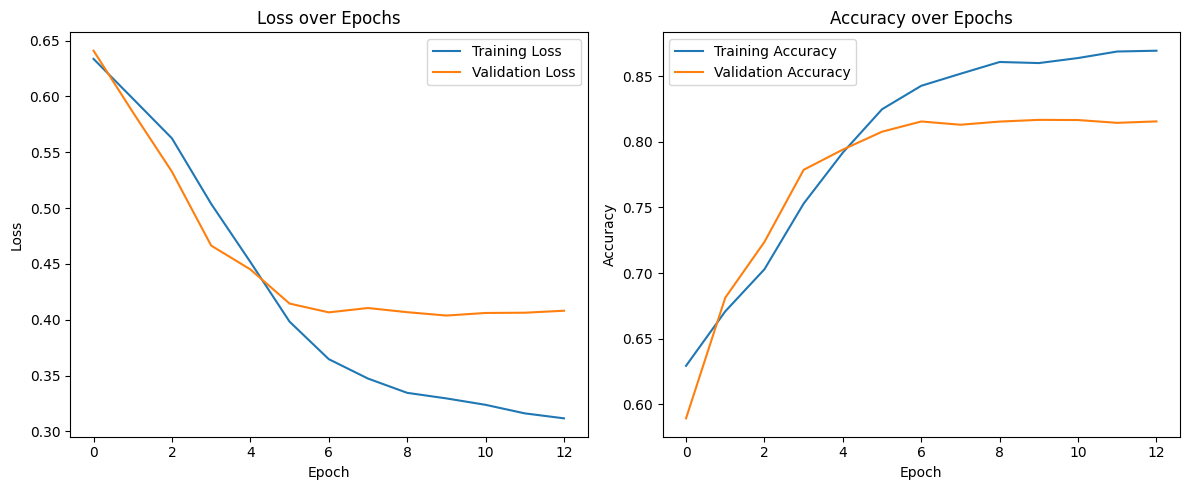

Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 227/227 [00:03<00:00, 74.44it/s]

Accuracy tanh: 0.8156


In [148]:
print(f"Testing activation function: {act_fn}")
# Оновлена конфігурація xLSTM з підвищеною регуляризацією
cfg = xLSTMBlockStackConfig(
    mlstm_block=mLSTMBlockConfig(
        mlstm=mLSTMLayerConfig(
            conv1d_kernel_size=4, qkv_proj_blocksize=4, num_heads=4
        )
    ),
    slstm_block=sLSTMBlockConfig(
        slstm=sLSTMLayerConfig(
            backend="cuda",
            num_heads=4,
            conv1d_kernel_size=4,
            bias_init="powerlaw_blockdependent",
        ),
        feedforward=FeedForwardConfig(proj_factor=1.3, act_fn="selu"),
    ),
    context_length=MAX_LEN,
    num_blocks=5,  # Зменшення кількості блоків для зменшення складності моделі
    embedding_dim=128,
    slstm_at=[1],
)

# Ініціалізація xLSTM стеку
xlstm_stack = xLSTMBlockStack(cfg).to("cuda")

# Модель з Dropout і L2-регуляризацією
class HateSpeechModel(nn.Module):
    def __init__(self, xlstm_stack, vocab_size, embedding_dim, dropout_prob=0.6):  # Збільшений Dropout
        super(HateSpeechModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.xlstm = xlstm_stack
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(embedding_dim, 2)

    def forward(self, x):
        x = self.embedding(x)
        x = self.xlstm(x)
        x = self.dropout(x)
        x = self.fc(x.mean(dim=1))
        return x

# Ініціалізація моделі
model = HateSpeechModel(xlstm_stack, vocab_size, 128).to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)  # Додана L2-регуляризація

# Функція для раннього зупинення
def early_stopping(val_losses, patience=3):
    if len(val_losses) < patience + 1:  # Додаємо перевірку довжини списку
        return False
    for i in range(1, patience + 1):
        if val_losses[-i] < val_losses[-i - 1]:
            return False
    return True

# Навчання моделі з раннім зупиненням
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=30):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for tweets, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            tweets, labels = tweets.to("cuda"), labels.to("cuda")
            optimizer.zero_grad()
            outputs = model(tweets)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_loss = total_loss / len(train_loader)
        accuracy = correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)

        # Валідація
        val_loss, val_accuracy = validate_model(model, test_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

        # Раннє зупинення
        if early_stopping(val_losses):
            print("Early stopping triggered")
            break

    return train_losses, train_accuracies, val_losses, val_accuracies

train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=30)
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)
preds = test_model(model, test_loader)
accuracy = accuracy_score(y_test, preds)
print(f'Accuracy {act_fn}: {accuracy:.4f}')

## Exps 3

## Exps 3